In [1]:
# import module
import random
import numpy as np
from itertools import count
from collections import deque

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import gym

# make game
env = gym.make('CartPole-v1')

# seed the experiment
env.seed(9)
np.random.seed(9)
random.seed(9)
torch.manual_seed(9)

/Users/Kevin/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [2]:
# define our policy
class DQN(nn.Module):
    def __init__(self, observation_space, action_space):
        super(DQN, self).__init__()
        self.observation_space = observation_space
        self.action_space = action_space
        self.fc1 = nn.Linear(self.observation_space, 32)
        self.fc2 = nn.Linear(32, 16)
        self.fc3 = nn.Linear(16, self.action_space)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


# define our agent
class Agent:
    def __init__(self, policy_net):
        MEMORY_SIZE = 10000
        GAMMA = 0.6
        BATCH_SIZE = 128
        EXPLORATION_MAX = 0.9
        EXPLORATION_MIN = 0.05
        EXPLORATION_DECAY = 0.95

        self.policy_net = policy_net
        self.optimizer = optim.RMSprop(policy_net.parameters(), lr=1e-3)
        self.memory = deque(maxlen=MEMORY_SIZE)
        self.gamma = GAMMA
        self.batch_size = BATCH_SIZE
        self.exploration_rate = EXPLORATION_MAX
        self.exploration_min = EXPLORATION_MIN
        self.exploration_decay = EXPLORATION_DECAY
    
    def select_action(self, state):
        if np.random.rand() < self.exploration_rate:
            return torch.tensor([[random.randrange(self.policy_net.action_space)]])
        else:
            with torch.no_grad():
                q_values = self.policy_net(state)
            return q_values.max(1)[1].view(1,1)

    def remember(self, state, action, reward, next_state):
        self.memory.append((state, action, reward, next_state))

    def experience_replay(self):
        if len(self.memory) < self.batch_size:
            return
        # fetch data
        print("[ Experience replay ] starts")
        batch = random.sample(self.memory, self.batch_size)
        batch_state = torch.cat(tuple([x[0] for x in batch]))
        batch_action = torch.cat(tuple([x[1] for x in batch]))
        batch_reward = torch.cat(tuple([x[2] for x in batch]))
        batch_next_state = [x[3] for x in batch]
        non_final_next_states = torch.cat(tuple([s for s in batch_next_state if s is not None]))
        non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch_next_state)), dtype=torch.bool)
        
        # forward pass to get Q values
        state_action_values = self.policy_net(batch_state).gather(1, batch_action)
        # forward pass to get Q values of next state
        next_state_values = torch.zeros(self.batch_size)
        next_state_values[non_final_mask] = self.policy_net(non_final_next_states).max(1)[0].detach()
        expected_state_action_values = (next_state_values * self.gamma).unsqueeze(1) + batch_reward

        # train policy
        policy_loss = F.smooth_l1_loss(state_action_values, expected_state_action_values)
        policy_loss.backward()
        self.optimizer.step()
        self.optimizer.zero_grad()

        # the more policy gets replayed, the less the agent explores
        self.exploration_rate *= self.exploration_decay
        self.exploration_rate = max(self.exploration_min, self.exploration_rate)

In [3]:
# create policy
observation_space = env.observation_space.shape[0]
action_space = env.action_space.n
policy_net = DQN(observation_space, action_space)

# create agent
agent = Agent(policy_net)

# play game
game_durations = []
for i_episode in count(1):
    state = env.reset()
    state = torch.tensor([state]).float()
    print("[ episode {} ] state={}".format(i_episode, state))
    for t in range(1, 10000):
        action = agent.select_action(state)
        state_next, reward, done, _ = env.step(action.item())
        if done:
            state_next = None
        else:
            state_next = torch.tensor([state_next]).float()
        agent.remember(state, action, torch.tensor([[reward]]).float(), state_next)
        print("[ episode {} ][ timestamp {} ] state={}, action={}, reward={}, next_state={}".format(i_episode, t, state, action, reward, state_next))
        state = state_next
        agent.experience_replay()
        if done:
            game_durations.append(t)
            break
    print("[ Ended! ] Episode {}: Exploration_rate={}. Score={}.".format(i_episode, agent.exploration_rate, t))

    # end game criteria
    if t > env.spec.reward_threshold:
        print("[ Solved! ] Score is now {}".format(t))
        break
    elif i_episode > 500:
        print("[ Failed! ] took more than 500 episodes")
        break


[ episode 1 ] state=tensor([[-0.0055,  0.0210,  0.0088,  0.0255]])
[ episode 1 ][ timestamp 1 ] state=tensor([[-0.0055,  0.0210,  0.0088,  0.0255]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.0051,  0.2160,  0.0094, -0.2644]])
[ episode 1 ][ timestamp 2 ] state=tensor([[-0.0051,  0.2160,  0.0094, -0.2644]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.0008,  0.4110,  0.0041, -0.5541]])
[ episode 1 ][ timestamp 3 ] state=tensor([[-0.0008,  0.4110,  0.0041, -0.5541]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[ 0.0074,  0.6061, -0.0070, -0.8455]])
[ episode 1 ][ timestamp 4 ] state=tensor([[ 0.0074,  0.6061, -0.0070, -0.8455]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0196,  0.4110, -0.0239, -0.5551]])
[ episode 1 ][ timestamp 5 ] state=tensor([[ 0.0196,  0.4110, -0.0239, -0.5551]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0278,  0.2163, -0.0350, -0.2700]])
[ episode 1 ][ timestamp 6 ] state=tensor([[ 0.0278,  0.21

[ episode 7 ][ timestamp 3 ] state=tensor([[-0.0223, -0.0217,  0.0014,  0.0033]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.0227,  0.1734,  0.0015, -0.2889]])
[ Experience replay ] starts
[ episode 7 ][ timestamp 4 ] state=tensor([[-0.0227,  0.1734,  0.0015, -0.2889]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.0192, -0.0218, -0.0043,  0.0043]])
[ Experience replay ] starts
[ episode 7 ][ timestamp 5 ] state=tensor([[-0.0192, -0.0218, -0.0043,  0.0043]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.0197, -0.2168, -0.0042,  0.2956]])
[ Experience replay ] starts
[ episode 7 ][ timestamp 6 ] state=tensor([[-0.0197, -0.2168, -0.0042,  0.2956]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.0240, -0.0216,  0.0017,  0.0016]])
[ Experience replay ] starts
[ episode 7 ][ timestamp 7 ] state=tensor([[-0.0240, -0.0216,  0.0017,  0.0016]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.0244,  0.1735,  0.0017, -0.2906]])
[ Experie

[ episode 11 ][ timestamp 9 ] state=tensor([[ 0.0614,  0.7860, -0.1021, -1.1522]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[ 0.0771,  0.9823, -0.1252, -1.4751]])
[ Experience replay ] starts
[ episode 11 ][ timestamp 10 ] state=tensor([[ 0.0771,  0.9823, -0.1252, -1.4751]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0967,  0.7889, -0.1547, -1.2239]])
[ Experience replay ] starts
[ episode 11 ][ timestamp 11 ] state=tensor([[ 0.0967,  0.7889, -0.1547, -1.2239]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[ 0.1125,  0.9857, -0.1792, -1.5608]])
[ Experience replay ] starts
[ episode 11 ][ timestamp 12 ] state=tensor([[ 0.1125,  0.9857, -0.1792, -1.5608]]), action=tensor([[1]]), reward=1.0, next_state=None
[ Experience replay ] starts
[ Ended! ] Episode 11: Exploration_rate=0.05. Score=12.
[ episode 12 ] state=tensor([[ 0.0202, -0.0475,  0.0480, -0.0268]])
[ episode 12 ][ timestamp 1 ] state=tensor([[ 0.0202, -0.0475,  0.0480, -0.0268]]), action=tens

[ episode 15 ][ timestamp 4 ] state=tensor([[ 0.0195,  0.1696,  0.0006, -0.2441]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0229, -0.0255, -0.0043,  0.0488]])
[ Experience replay ] starts
[ episode 15 ][ timestamp 5 ] state=tensor([[ 0.0229, -0.0255, -0.0043,  0.0488]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[ 0.0224,  0.1696, -0.0033, -0.2452]])
[ Experience replay ] starts
[ episode 15 ][ timestamp 6 ] state=tensor([[ 0.0224,  0.1696, -0.0033, -0.2452]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[ 0.0258,  0.3648, -0.0082, -0.5389]])
[ Experience replay ] starts
[ episode 15 ][ timestamp 7 ] state=tensor([[ 0.0258,  0.3648, -0.0082, -0.5389]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[ 0.0331,  0.5600, -0.0190, -0.8342]])
[ Experience replay ] starts
[ episode 15 ][ timestamp 8 ] state=tensor([[ 0.0331,  0.5600, -0.0190, -0.8342]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[ 0.0443,  0.7554, -0.0357, -1.1328]])
[ Ex

[ episode 17 ][ timestamp 15 ] state=tensor([[ 0.1615,  0.4178, -0.1953, -0.8688]]), action=tensor([[1]]), reward=1.0, next_state=None
[ Experience replay ] starts
[ Ended! ] Episode 17: Exploration_rate=0.05. Score=15.
[ episode 18 ] state=tensor([[-0.0382,  0.0317, -0.0049, -0.0367]])
[ episode 18 ][ timestamp 1 ] state=tensor([[-0.0382,  0.0317, -0.0049, -0.0367]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.0375,  0.2269, -0.0057, -0.3309]])
[ Experience replay ] starts
[ episode 18 ][ timestamp 2 ] state=tensor([[-0.0375,  0.2269, -0.0057, -0.3309]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.0330,  0.4221, -0.0123, -0.6254]])
[ Experience replay ] starts
[ episode 18 ][ timestamp 3 ] state=tensor([[-0.0330,  0.4221, -0.0123, -0.6254]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.0246,  0.6174, -0.0248, -0.9219]])
[ Experience replay ] starts
[ episode 18 ][ timestamp 4 ] state=tensor([[-0.0246,  0.6174, -0.0248, -0.9219]]), action=tensor

[ episode 20 ][ timestamp 15 ] state=tensor([[ 0.0852,  0.4176, -0.1446, -0.7499]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0936,  0.2247, -0.1596, -0.5060]])
[ Experience replay ] starts
[ episode 20 ][ timestamp 16 ] state=tensor([[ 0.0936,  0.2247, -0.1596, -0.5060]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[ 0.0981,  0.4217, -0.1697, -0.8444]])
[ Experience replay ] starts
[ episode 20 ][ timestamp 17 ] state=tensor([[ 0.0981,  0.4217, -0.1697, -0.8444]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[ 0.1065,  0.6187, -0.1866, -1.1853]])
[ Experience replay ] starts
[ episode 20 ][ timestamp 18 ] state=tensor([[ 0.1065,  0.6187, -0.1866, -1.1853]]), action=tensor([[0]]), reward=1.0, next_state=None
[ Experience replay ] starts
[ Ended! ] Episode 20: Exploration_rate=0.05. Score=18.
[ episode 21 ] state=tensor([[-0.0201, -0.0006,  0.0207,  0.0008]])
[ episode 21 ][ timestamp 1 ] state=tensor([[-0.0201, -0.0006,  0.0207,  0.0008]]), action=ten

[ episode 23 ][ timestamp 9 ] state=tensor([[ 0.0165,  0.3523, -0.1056, -0.6953]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[ 0.0236,  0.5487, -0.1195, -1.0193]])
[ Experience replay ] starts
[ episode 23 ][ timestamp 10 ] state=tensor([[ 0.0236,  0.5487, -0.1195, -1.0193]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[ 0.0346,  0.7452, -0.1399, -1.3470]])
[ Experience replay ] starts
[ episode 23 ][ timestamp 11 ] state=tensor([[ 0.0346,  0.7452, -0.1399, -1.3470]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0495,  0.5521, -0.1668, -1.1012]])
[ Experience replay ] starts
[ episode 23 ][ timestamp 12 ] state=tensor([[ 0.0495,  0.5521, -0.1668, -1.1012]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0605,  0.3595, -0.1889, -0.8651]])
[ Experience replay ] starts
[ episode 23 ][ timestamp 13 ] state=tensor([[ 0.0605,  0.3595, -0.1889, -0.8651]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[ 0.0677,  0.5567, -0.2062, -1.2107]])


[ episode 25 ][ timestamp 16 ] state=tensor([[ 0.1398,  0.5482, -0.1471, -1.0606]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.1508,  0.3553, -0.1683, -0.8175]])
[ Experience replay ] starts
[ episode 25 ][ timestamp 17 ] state=tensor([[ 0.1508,  0.3553, -0.1683, -0.8175]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[ 0.1579,  0.5523, -0.1846, -1.1580]])
[ Experience replay ] starts
[ episode 25 ][ timestamp 18 ] state=tensor([[ 0.1579,  0.5523, -0.1846, -1.1580]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.1689,  0.3600, -0.2078, -0.9284]])
[ Experience replay ] starts
[ episode 25 ][ timestamp 19 ] state=tensor([[ 0.1689,  0.3600, -0.2078, -0.9284]]), action=tensor([[0]]), reward=1.0, next_state=None
[ Experience replay ] starts
[ Ended! ] Episode 25: Exploration_rate=0.05. Score=19.
[ episode 26 ] state=tensor([[ 0.0161, -0.0146, -0.0021, -0.0143]])
[ episode 26 ][ timestamp 1 ] state=tensor([[ 0.0161, -0.0146, -0.0021, -0.0143]]), action=ten

[ Ended! ] Episode 27: Exploration_rate=0.05. Score=32.
[ episode 28 ] state=tensor([[-0.0144, -0.0184,  0.0075, -0.0398]])
[ episode 28 ][ timestamp 1 ] state=tensor([[-0.0144, -0.0184,  0.0075, -0.0398]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.0148,  0.1766,  0.0067, -0.3301]])
[ Experience replay ] starts
[ episode 28 ][ timestamp 2 ] state=tensor([[-0.0148,  0.1766,  0.0067, -0.3301]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-1.1251e-02,  3.7165e-01,  7.7888e-05, -6.2068e-01]])
[ Experience replay ] starts
[ episode 28 ][ timestamp 3 ] state=tensor([[-1.1251e-02,  3.7165e-01,  7.7888e-05, -6.2068e-01]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.0038,  0.5668, -0.0123, -0.9133]])
[ Experience replay ] starts
[ episode 28 ][ timestamp 4 ] state=tensor([[-0.0038,  0.5668, -0.0123, -0.9133]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0075,  0.3718, -0.0306, -0.6246]])
[ Experience replay ] starts
[ episode 28 ][ timestam

[ episode 30 ][ timestamp 7 ] state=tensor([[ 0.0306,  0.3943, -0.1101, -0.6843]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0384,  0.2009, -0.1238, -0.4282]])
[ Experience replay ] starts
[ episode 30 ][ timestamp 8 ] state=tensor([[ 0.0384,  0.2009, -0.1238, -0.4282]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[ 0.0425,  0.3975, -0.1324, -0.7572]])
[ Experience replay ] starts
[ episode 30 ][ timestamp 9 ] state=tensor([[ 0.0425,  0.3975, -0.1324, -0.7572]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0504,  0.2044, -0.1475, -0.5089]])
[ Experience replay ] starts
[ episode 30 ][ timestamp 10 ] state=tensor([[ 0.0504,  0.2044, -0.1475, -0.5089]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[ 0.0545,  0.4013, -0.1577, -0.8442]])
[ Experience replay ] starts
[ episode 30 ][ timestamp 11 ] state=tensor([[ 0.0545,  0.4013, -0.1577, -0.8442]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0625,  0.2086, -0.1746, -0.6050]])
[ 

[ episode 33 ][ timestamp 6 ] state=tensor([[-0.0208,  0.2115, -0.0209, -0.2607]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.0166,  0.4069, -0.0261, -0.5599]])
[ Experience replay ] starts
[ episode 33 ][ timestamp 7 ] state=tensor([[-0.0166,  0.4069, -0.0261, -0.5599]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.0084,  0.6024, -0.0373, -0.8607]])
[ Experience replay ] starts
[ episode 33 ][ timestamp 8 ] state=tensor([[-0.0084,  0.6024, -0.0373, -0.8607]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0036,  0.4078, -0.0545, -0.5799]])
[ Experience replay ] starts
[ episode 33 ][ timestamp 9 ] state=tensor([[ 0.0036,  0.4078, -0.0545, -0.5799]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[ 0.0118,  0.6037, -0.0661, -0.8893]])
[ Experience replay ] starts
[ episode 33 ][ timestamp 10 ] state=tensor([[ 0.0118,  0.6037, -0.0661, -0.8893]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0238,  0.4095, -0.0839, -0.6181]])
[ E

[ episode 35 ][ timestamp 20 ] state=tensor([[ 0.0384, -0.5553,  0.1185,  1.1993]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0273, -0.7517,  0.1425,  1.5267]])
[ Experience replay ] starts
[ episode 35 ][ timestamp 21 ] state=tensor([[ 0.0273, -0.7517,  0.1425,  1.5267]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0123, -0.9482,  0.1731,  1.8602]])
[ Experience replay ] starts
[ episode 35 ][ timestamp 22 ] state=tensor([[ 0.0123, -0.9482,  0.1731,  1.8602]]), action=tensor([[0]]), reward=1.0, next_state=None
[ Experience replay ] starts
[ Ended! ] Episode 35: Exploration_rate=0.05. Score=22.
[ episode 36 ] state=tensor([[-0.0202,  0.0160,  0.0235, -0.0219]])
[ episode 36 ][ timestamp 1 ] state=tensor([[-0.0202,  0.0160,  0.0235, -0.0219]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.0199,  0.2107,  0.0230, -0.3071]])
[ Experience replay ] starts
[ episode 36 ][ timestamp 2 ] state=tensor([[-0.0199,  0.2107,  0.0230, -0.3071]]), action=tens

[ episode 40 ][ timestamp 2 ] state=tensor([[-0.0343,  0.2436,  0.0312, -0.3199]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.0294,  0.0480,  0.0248, -0.0176]])
[ Experience replay ] starts
[ episode 40 ][ timestamp 3 ] state=tensor([[-0.0294,  0.0480,  0.0248, -0.0176]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.0284,  0.2428,  0.0244, -0.3023]])
[ Experience replay ] starts
[ episode 40 ][ timestamp 4 ] state=tensor([[-0.0284,  0.2428,  0.0244, -0.3023]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.0236,  0.0473,  0.0184, -0.0020]])
[ Experience replay ] starts
[ episode 40 ][ timestamp 5 ] state=tensor([[-0.0236,  0.0473,  0.0184, -0.0020]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.0226,  0.2422,  0.0183, -0.2889]])
[ Experience replay ] starts
[ episode 40 ][ timestamp 6 ] state=tensor([[-0.0226,  0.2422,  0.0183, -0.2889]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.0178,  0.0468,  0.0126,  0.0095]])
[ Ex

[ Experience replay ] starts
[ episode 43 ][ timestamp 15 ] state=tensor([[ 0.1080,  0.3676, -0.1106, -0.7313]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.1153,  0.1742, -0.1252, -0.4754]])
[ Experience replay ] starts
[ episode 43 ][ timestamp 16 ] state=tensor([[ 0.1153,  0.1742, -0.1252, -0.4754]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[ 0.1188,  0.3708, -0.1347, -0.8047]])
[ Experience replay ] starts
[ episode 43 ][ timestamp 17 ] state=tensor([[ 0.1188,  0.3708, -0.1347, -0.8047]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[ 0.1262,  0.5675, -0.1508, -1.1366]])
[ Experience replay ] starts
[ episode 43 ][ timestamp 18 ] state=tensor([[ 0.1262,  0.5675, -0.1508, -1.1366]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.1376,  0.3746, -0.1736, -0.8948]])
[ Experience replay ] starts
[ episode 43 ][ timestamp 19 ] state=tensor([[ 0.1376,  0.3746, -0.1736, -0.8948]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[ 0.1451,

[ episode 46 ][ timestamp 6 ] state=tensor([[ 0.0018,  0.1497, -0.0475, -0.3288]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[ 0.0048,  0.3455, -0.0541, -0.6360]])
[ Experience replay ] starts
[ episode 46 ][ timestamp 7 ] state=tensor([[ 0.0048,  0.3455, -0.0541, -0.6360]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0117,  0.1511, -0.0668, -0.3609]])
[ Experience replay ] starts
[ episode 46 ][ timestamp 8 ] state=tensor([[ 0.0117,  0.1511, -0.0668, -0.3609]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[ 0.0148,  0.3471, -0.0741, -0.6739]])
[ Experience replay ] starts
[ episode 46 ][ timestamp 9 ] state=tensor([[ 0.0148,  0.3471, -0.0741, -0.6739]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0217,  0.1531, -0.0875, -0.4054]])
[ Experience replay ] starts
[ episode 46 ][ timestamp 10 ] state=tensor([[ 0.0217,  0.1531, -0.0875, -0.4054]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[ 0.0248,  0.3494, -0.0956, -0.7243]])
[ E

[ episode 48 ][ timestamp 18 ] state=tensor([[-0.0169,  0.1553,  0.0442, -0.0262]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.0138, -0.0405,  0.0436,  0.2801]])
[ Experience replay ] starts
[ episode 48 ][ timestamp 19 ] state=tensor([[-0.0138, -0.0405,  0.0436,  0.2801]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.0146,  0.1540,  0.0493,  0.0015]])
[ Experience replay ] starts
[ episode 48 ][ timestamp 20 ] state=tensor([[-0.0146,  0.1540,  0.0493,  0.0015]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.0115,  0.3484,  0.0493, -0.2752]])
[ Experience replay ] starts
[ episode 48 ][ timestamp 21 ] state=tensor([[-0.0115,  0.3484,  0.0493, -0.2752]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.0045,  0.1526,  0.0438,  0.0326]])
[ Experience replay ] starts
[ episode 48 ][ timestamp 22 ] state=tensor([[-0.0045,  0.1526,  0.0438,  0.0326]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.0015, -0.0431,  0.0444,  0.3387]])

[ episode 51 ][ timestamp 17 ] state=tensor([[ 0.1109,  0.4285, -0.0905, -0.6565]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.1195,  0.2347, -0.1036, -0.3936]])
[ Experience replay ] starts
[ episode 51 ][ timestamp 18 ] state=tensor([[ 0.1195,  0.2347, -0.1036, -0.3936]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[ 0.1242,  0.4311, -0.1115, -0.7171]])
[ Experience replay ] starts
[ episode 51 ][ timestamp 19 ] state=tensor([[ 0.1242,  0.4311, -0.1115, -0.7171]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.1328,  0.2377, -0.1258, -0.4615]])
[ Experience replay ] starts
[ episode 51 ][ timestamp 20 ] state=tensor([[ 0.1328,  0.2377, -0.1258, -0.4615]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.1376,  0.0446, -0.1350, -0.2109]])
[ Experience replay ] starts
[ episode 51 ][ timestamp 21 ] state=tensor([[ 0.1376,  0.0446, -0.1350, -0.2109]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[ 0.1385,  0.2414, -0.1393, -0.5430]])

[ Experience replay ] starts
[ episode 53 ][ timestamp 25 ] state=tensor([[ 0.1498,  0.3789, -0.2070, -0.9512]]), action=tensor([[0]]), reward=1.0, next_state=None
[ Experience replay ] starts
[ Ended! ] Episode 53: Exploration_rate=0.05. Score=25.
[ episode 54 ] state=tensor([[-1.7468e-02, -2.4283e-03,  1.0245e-06,  6.1355e-03]])
[ episode 54 ][ timestamp 1 ] state=tensor([[-1.7468e-02, -2.4283e-03,  1.0245e-06,  6.1355e-03]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-1.7516e-02,  1.9269e-01,  1.2374e-04, -2.8655e-01]])
[ Experience replay ] starts
[ episode 54 ][ timestamp 2 ] state=tensor([[-1.7516e-02,  1.9269e-01,  1.2374e-04, -2.8655e-01]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.0137,  0.3878, -0.0056, -0.5792]])
[ Experience replay ] starts
[ episode 54 ][ timestamp 3 ] state=tensor([[-0.0137,  0.3878, -0.0056, -0.5792]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.0059,  0.1928, -0.0172, -0.2883]])
[ Experience replay ] starts
[ ep

[ episode 56 ][ timestamp 16 ] state=tensor([[ 0.0293,  0.2534, -0.1174, -0.5126]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[ 0.0344,  0.4500, -0.1276, -0.8399]])
[ Experience replay ] starts
[ episode 56 ][ timestamp 17 ] state=tensor([[ 0.0344,  0.4500, -0.1276, -0.8399]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0434,  0.2568, -0.1444, -0.5899]])
[ Experience replay ] starts
[ episode 56 ][ timestamp 18 ] state=tensor([[ 0.0434,  0.2568, -0.1444, -0.5899]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[ 0.0485,  0.4536, -0.1562, -0.9244]])
[ Experience replay ] starts
[ episode 56 ][ timestamp 19 ] state=tensor([[ 0.0485,  0.4536, -0.1562, -0.9244]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0576,  0.2609, -0.1747, -0.6846]])
[ Experience replay ] starts
[ episode 56 ][ timestamp 20 ] state=tensor([[ 0.0576,  0.2609, -0.1747, -0.6846]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0628,  0.0686, -0.1884, -0.4516]])

[ episode 58 ][ timestamp 13 ] state=tensor([[ 0.0725,  0.0370, -0.1276, -0.2510]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[ 0.0733,  0.2337, -0.1326, -0.5811]])
[ Experience replay ] starts
[ episode 58 ][ timestamp 14 ] state=tensor([[ 0.0733,  0.2337, -0.1326, -0.5811]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[ 0.0780,  0.4304, -0.1442, -0.9124]])
[ Experience replay ] starts
[ episode 58 ][ timestamp 15 ] state=tensor([[ 0.0780,  0.4304, -0.1442, -0.9124]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0866,  0.2375, -0.1625, -0.6683]])
[ Experience replay ] starts
[ episode 58 ][ timestamp 16 ] state=tensor([[ 0.0866,  0.2375, -0.1625, -0.6683]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0913,  0.0450, -0.1758, -0.4309]])
[ Experience replay ] starts
[ episode 58 ][ timestamp 17 ] state=tensor([[ 0.0913,  0.0450, -0.1758, -0.4309]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[ 0.0922,  0.2421, -0.1845, -0.7734]])

[ episode 61 ][ timestamp 11 ] state=tensor([[ 0.0806,  0.3779, -0.0617, -0.5849]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0881,  0.1836, -0.0734, -0.3123]])
[ Experience replay ] starts
[ episode 61 ][ timestamp 12 ] state=tensor([[ 0.0881,  0.1836, -0.0734, -0.3123]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[ 0.0918,  0.3797, -0.0797, -0.6272]])
[ Experience replay ] starts
[ episode 61 ][ timestamp 13 ] state=tensor([[ 0.0918,  0.3797, -0.0797, -0.6272]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[ 0.0994,  0.5759, -0.0922, -0.9439]])
[ Experience replay ] starts
[ episode 61 ][ timestamp 14 ] state=tensor([[ 0.0994,  0.5759, -0.0922, -0.9439]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.1109,  0.3821, -0.1111, -0.6815]])
[ Experience replay ] starts
[ episode 61 ][ timestamp 15 ] state=tensor([[ 0.1109,  0.3821, -0.1111, -0.6815]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.1186,  0.1887, -0.1247, -0.4258]])

[ Ended! ] Episode 63: Exploration_rate=0.05. Score=26.
[ episode 64 ] state=tensor([[ 0.0490,  0.0470, -0.0341,  0.0367]])
[ episode 64 ][ timestamp 1 ] state=tensor([[ 0.0490,  0.0470, -0.0341,  0.0367]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[ 0.0499,  0.2426, -0.0334, -0.2665]])
[ Experience replay ] starts
[ episode 64 ][ timestamp 2 ] state=tensor([[ 0.0499,  0.2426, -0.0334, -0.2665]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[ 0.0548,  0.4382, -0.0387, -0.5695]])
[ Experience replay ] starts
[ episode 64 ][ timestamp 3 ] state=tensor([[ 0.0548,  0.4382, -0.0387, -0.5695]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0635,  0.2437, -0.0501, -0.2893]])
[ Experience replay ] starts
[ episode 64 ][ timestamp 4 ] state=tensor([[ 0.0635,  0.2437, -0.0501, -0.2893]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[ 0.0684,  0.4395, -0.0559, -0.5973]])
[ Experience replay ] starts
[ episode 64 ][ timestamp 5 ] state=tensor([[ 0.0684,  0

[ episode 66 ][ timestamp 6 ] state=tensor([[ 0.0382,  0.1577, -0.0443, -0.3378]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[ 0.0414,  0.3534, -0.0510, -0.6441]])
[ Experience replay ] starts
[ episode 66 ][ timestamp 7 ] state=tensor([[ 0.0414,  0.3534, -0.0510, -0.6441]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0485,  0.1590, -0.0639, -0.3679]])
[ Experience replay ] starts
[ episode 66 ][ timestamp 8 ] state=tensor([[ 0.0485,  0.1590, -0.0639, -0.3679]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[ 0.0516,  0.3550, -0.0713, -0.6800]])
[ Experience replay ] starts
[ episode 66 ][ timestamp 9 ] state=tensor([[ 0.0516,  0.3550, -0.0713, -0.6800]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0587,  0.1609, -0.0849, -0.4106]])
[ Experience replay ] starts
[ episode 66 ][ timestamp 10 ] state=tensor([[ 0.0587,  0.1609, -0.0849, -0.4106]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[ 0.0620,  0.3572, -0.0931, -0.7288]])
[ E

[ episode 69 ] state=tensor([[-0.0046, -0.0472, -0.0105,  0.0444]])
[ episode 69 ][ timestamp 1 ] state=tensor([[-0.0046, -0.0472, -0.0105,  0.0444]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.0055,  0.1481, -0.0097, -0.2515]])
[ Experience replay ] starts
[ episode 69 ][ timestamp 2 ] state=tensor([[-0.0055,  0.1481, -0.0097, -0.2515]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.0026,  0.3434, -0.0147, -0.5473]])
[ Experience replay ] starts
[ episode 69 ][ timestamp 3 ] state=tensor([[-0.0026,  0.3434, -0.0147, -0.5473]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0043,  0.1485, -0.0256, -0.2592]])
[ Experience replay ] starts
[ episode 69 ][ timestamp 4 ] state=tensor([[ 0.0043,  0.1485, -0.0256, -0.2592]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[ 0.0073,  0.3439, -0.0308, -0.5599]])
[ Experience replay ] starts
[ episode 69 ][ timestamp 5 ] state=tensor([[ 0.0073,  0.3439, -0.0308, -0.5599]]), action=tensor([[0]]), reward

[ episode 71 ][ timestamp 5 ] state=tensor([[ 1.9381e-03,  3.3942e-01, -2.8650e-04, -5.9114e-01]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[ 0.0087,  0.5345, -0.0121, -0.8839]])
[ Experience replay ] starts
[ episode 71 ][ timestamp 6 ] state=tensor([[ 0.0087,  0.5345, -0.0121, -0.8839]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0194,  0.3396, -0.0298, -0.5951]])
[ Experience replay ] starts
[ episode 71 ][ timestamp 7 ] state=tensor([[ 0.0194,  0.3396, -0.0298, -0.5951]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[ 0.0262,  0.5351, -0.0417, -0.8970]])
[ Experience replay ] starts
[ episode 71 ][ timestamp 8 ] state=tensor([[ 0.0262,  0.5351, -0.0417, -0.8970]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0369,  0.3406, -0.0596, -0.6177]])
[ Experience replay ] starts
[ episode 71 ][ timestamp 9 ] state=tensor([[ 0.0369,  0.3406, -0.0596, -0.6177]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0437,  0.1463, -0.0720,

[ episode 73 ][ timestamp 16 ] state=tensor([[ 0.0601,  0.1949, -0.1643, -0.6913]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0640,  0.0024, -0.1782, -0.4545]])
[ Experience replay ] starts
[ episode 73 ][ timestamp 17 ] state=tensor([[ 0.0640,  0.0024, -0.1782, -0.4545]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0640, -0.1898, -0.1873, -0.2228]])
[ Experience replay ] starts
[ episode 73 ][ timestamp 18 ] state=tensor([[ 0.0640, -0.1898, -0.1873, -0.2228]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[ 0.0602,  0.0074, -0.1917, -0.5683]])
[ Experience replay ] starts
[ episode 73 ][ timestamp 19 ] state=tensor([[ 0.0602,  0.0074, -0.1917, -0.5683]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0604, -0.1846, -0.2031, -0.3416]])
[ Experience replay ] starts
[ episode 73 ][ timestamp 20 ] state=tensor([[ 0.0604, -0.1846, -0.2031, -0.3416]]), action=tensor([[1]]), reward=1.0, next_state=None
[ Experience replay ] starts
[ Ended! ] E

[ episode 75 ][ timestamp 15 ] state=tensor([[ 0.0575,  0.0277, -0.1122, -0.2077]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[ 0.0581,  0.2243, -0.1163, -0.5335]])
[ Experience replay ] starts
[ episode 75 ][ timestamp 16 ] state=tensor([[ 0.0581,  0.2243, -0.1163, -0.5335]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0626,  0.0309, -0.1270, -0.2796]])
[ Experience replay ] starts
[ episode 75 ][ timestamp 17 ] state=tensor([[ 0.0626,  0.0309, -0.1270, -0.2796]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[ 0.0632,  0.2276, -0.1326, -0.6095]])
[ Experience replay ] starts
[ episode 75 ][ timestamp 18 ] state=tensor([[ 0.0632,  0.2276, -0.1326, -0.6095]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0677,  0.0346, -0.1448, -0.3614]])
[ Experience replay ] starts
[ episode 75 ][ timestamp 19 ] state=tensor([[ 0.0677,  0.0346, -0.1448, -0.3614]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[ 0.0684,  0.2314, -0.1520, -0.6960]])

[ episode 77 ][ timestamp 18 ] state=tensor([[ 0.0044, -0.1525, -0.1559, -0.2111]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[ 0.0014,  0.0445, -0.1601, -0.5486]])
[ Experience replay ] starts
[ episode 77 ][ timestamp 19 ] state=tensor([[ 0.0014,  0.0445, -0.1601, -0.5486]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0022, -0.1481, -0.1711, -0.3104]])
[ Experience replay ] starts
[ episode 77 ][ timestamp 20 ] state=tensor([[ 0.0022, -0.1481, -0.1711, -0.3104]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.0007, -0.3404, -0.1773, -0.0761]])
[ Experience replay ] starts
[ episode 77 ][ timestamp 21 ] state=tensor([[-0.0007, -0.3404, -0.1773, -0.0761]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.0075, -0.1433, -0.1788, -0.4191]])
[ Experience replay ] starts
[ episode 77 ][ timestamp 22 ] state=tensor([[-0.0075, -0.1433, -0.1788, -0.4191]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.0104, -0.3355, -0.1872, -0.1877]])

[ episode 79 ][ timestamp 13 ] state=tensor([[ 0.0252,  0.3945, -0.0732, -0.6586]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0331,  0.2005, -0.0863, -0.3898]])
[ Experience replay ] starts
[ episode 79 ][ timestamp 14 ] state=tensor([[ 0.0331,  0.2005, -0.0863, -0.3898]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0371,  0.0067, -0.0941, -0.1256]])
[ Experience replay ] starts
[ episode 79 ][ timestamp 15 ] state=tensor([[ 0.0371,  0.0067, -0.0941, -0.1256]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[ 0.0372,  0.2031, -0.0967, -0.4464]])
[ Experience replay ] starts
[ episode 79 ][ timestamp 16 ] state=tensor([[ 0.0372,  0.2031, -0.0967, -0.4464]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0413,  0.0094, -0.1056, -0.1857]])
[ Experience replay ] starts
[ episode 79 ][ timestamp 17 ] state=tensor([[ 0.0413,  0.0094, -0.1056, -0.1857]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0415, -0.1840, -0.1093,  0.0719]])

[ Ended! ] Episode 80: Exploration_rate=0.05. Score=32.
[ episode 81 ] state=tensor([[-0.0129,  0.0473, -0.0476,  0.0283]])
[ episode 81 ][ timestamp 1 ] state=tensor([[-0.0129,  0.0473, -0.0476,  0.0283]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.0120, -0.1471, -0.0470,  0.3057]])
[ Experience replay ] starts
[ episode 81 ][ timestamp 2 ] state=tensor([[-0.0120, -0.1471, -0.0470,  0.3057]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.0149,  0.0487, -0.0409, -0.0015]])
[ Experience replay ] starts
[ episode 81 ][ timestamp 3 ] state=tensor([[-0.0149,  0.0487, -0.0409, -0.0015]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.0139,  0.2443, -0.0409, -0.3068]])
[ Experience replay ] starts
[ episode 81 ][ timestamp 4 ] state=tensor([[-0.0139,  0.2443, -0.0409, -0.3068]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.0091,  0.0498, -0.0470, -0.0273]])
[ Experience replay ] starts
[ episode 81 ][ timestamp 5 ] state=tensor([[-0.0091,  0

[ episode 81 ][ timestamp 68 ] state=tensor([[-0.2921, -0.4927, -0.0736, -0.0948]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.3020, -0.6867, -0.0755,  0.1737]])
[ Experience replay ] starts
[ episode 81 ][ timestamp 69 ] state=tensor([[-0.3020, -0.6867, -0.0755,  0.1737]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.3157, -0.4906, -0.0721, -0.1418]])
[ Experience replay ] starts
[ episode 81 ][ timestamp 70 ] state=tensor([[-0.3157, -0.4906, -0.0721, -0.1418]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.3255, -0.6846, -0.0749,  0.1273]])
[ Experience replay ] starts
[ episode 81 ][ timestamp 71 ] state=tensor([[-0.3255, -0.6846, -0.0749,  0.1273]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.3392, -0.4885, -0.0723, -0.1880]])
[ Experience replay ] starts
[ episode 81 ][ timestamp 72 ] state=tensor([[-0.3392, -0.4885, -0.0723, -0.1880]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.3490, -0.6825, -0.0761,  0.0810]])

[ episode 82 ][ timestamp 27 ] state=tensor([[-0.0571, -0.3390,  0.0854,  0.4876]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.0639, -0.1451,  0.0951,  0.2230]])
[ Experience replay ] starts
[ episode 82 ][ timestamp 28 ] state=tensor([[-0.0639, -0.1451,  0.0951,  0.2230]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.0668,  0.0485,  0.0996, -0.0383]])
[ Experience replay ] starts
[ episode 82 ][ timestamp 29 ] state=tensor([[-0.0668,  0.0485,  0.0996, -0.0383]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.0659,  0.2421,  0.0988, -0.2979]])
[ Experience replay ] starts
[ episode 82 ][ timestamp 30 ] state=tensor([[-0.0659,  0.2421,  0.0988, -0.2979]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.0610,  0.4357,  0.0928, -0.5579]])
[ Experience replay ] starts
[ episode 82 ][ timestamp 31 ] state=tensor([[-0.0610,  0.4357,  0.0928, -0.5579]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.0523,  0.6294,  0.0817, -0.8200]])

[ episode 83 ][ timestamp 17 ] state=tensor([[-0.0562, -1.5840,  0.1005,  2.3146]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.0879, -1.7799,  0.1467,  2.6364]])
[ Experience replay ] starts
[ episode 83 ][ timestamp 18 ] state=tensor([[-0.0879, -1.7799,  0.1467,  2.6364]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.1235, -1.9758,  0.1995,  2.9701]])
[ Experience replay ] starts
[ episode 83 ][ timestamp 19 ] state=tensor([[-0.1235, -1.9758,  0.1995,  2.9701]]), action=tensor([[0]]), reward=1.0, next_state=None
[ Experience replay ] starts
[ Ended! ] Episode 83: Exploration_rate=0.05. Score=19.
[ episode 84 ] state=tensor([[-0.0285, -0.0301, -0.0498,  0.0044]])
[ episode 84 ][ timestamp 1 ] state=tensor([[-0.0285, -0.0301, -0.0498,  0.0044]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.0291,  0.1657, -0.0498, -0.3036]])
[ Experience replay ] starts
[ episode 84 ][ timestamp 2 ] state=tensor([[-0.0291,  0.1657, -0.0498, -0.3036]]), action=tens

[ episode 84 ][ timestamp 76 ] state=tensor([[-0.4382, -0.5691, -0.1053, -0.1397]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.4496, -0.3727, -0.1080, -0.4636]])
[ Experience replay ] starts
[ episode 84 ][ timestamp 77 ] state=tensor([[-0.4496, -0.3727, -0.1080, -0.4636]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.4570, -0.5661, -0.1173, -0.2069]])
[ Experience replay ] starts
[ episode 84 ][ timestamp 78 ] state=tensor([[-0.4570, -0.5661, -0.1173, -0.2069]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.4683, -0.7594, -0.1215,  0.0466]])
[ Experience replay ] starts
[ episode 84 ][ timestamp 79 ] state=tensor([[-0.4683, -0.7594, -0.1215,  0.0466]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.4835, -0.9526, -0.1205,  0.2987]])
[ Experience replay ] starts
[ episode 84 ][ timestamp 80 ] state=tensor([[-0.4835, -0.9526, -0.1205,  0.2987]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.5026, -0.7560, -0.1146, -0.0295]])

[ episode 85 ][ timestamp 39 ] state=tensor([[ 0.0554, -0.7332, -0.1182,  0.7411]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0408, -0.9265, -0.1034,  0.9944]])
[ Experience replay ] starts
[ episode 85 ][ timestamp 40 ] state=tensor([[ 0.0408, -0.9265, -0.1034,  0.9944]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0222, -1.1201, -0.0835,  1.2529]])
[ Experience replay ] starts
[ episode 85 ][ timestamp 41 ] state=tensor([[ 0.0222, -1.1201, -0.0835,  1.2529]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.5911e-04, -1.3140e+00, -5.8410e-02,  1.5183e+00]])
[ Experience replay ] starts
[ episode 85 ][ timestamp 42 ] state=tensor([[-1.5911e-04, -1.3140e+00, -5.8410e-02,  1.5183e+00]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.0264, -1.5084, -0.0280,  1.7922]])
[ Experience replay ] starts
[ episode 85 ][ timestamp 43 ] state=tensor([[-0.0264, -1.5084, -0.0280,  1.7922]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.05

[ episode 87 ][ timestamp 7 ] state=tensor([[ 0.0491,  0.4196, -0.0378, -0.5806]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0575,  0.2250, -0.0495, -0.3000]])
[ Experience replay ] starts
[ episode 87 ][ timestamp 8 ] state=tensor([[ 0.0575,  0.2250, -0.0495, -0.3000]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0620,  0.0307, -0.0555, -0.0233]])
[ Experience replay ] starts
[ episode 87 ][ timestamp 9 ] state=tensor([[ 0.0620,  0.0307, -0.0555, -0.0233]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0626, -0.1636, -0.0559,  0.2513]])
[ Experience replay ] starts
[ episode 87 ][ timestamp 10 ] state=tensor([[ 0.0626, -0.1636, -0.0559,  0.2513]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0594, -0.3579, -0.0509,  0.5259]])
[ Experience replay ] starts
[ episode 87 ][ timestamp 11 ] state=tensor([[ 0.0594, -0.3579, -0.0509,  0.5259]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[ 0.0522, -0.1621, -0.0404,  0.2176]])
[ 

[ episode 90 ][ timestamp 16 ] state=tensor([[-0.0062, -0.2092,  0.0049,  0.1944]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.0103, -0.0141,  0.0088, -0.0967]])
[ Experience replay ] starts
[ episode 90 ][ timestamp 17 ] state=tensor([[-0.0103, -0.0141,  0.0088, -0.0967]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.0106, -0.2094,  0.0068,  0.1987]])
[ Experience replay ] starts
[ episode 90 ][ timestamp 18 ] state=tensor([[-0.0106, -0.2094,  0.0068,  0.1987]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.0148, -0.4046,  0.0108,  0.4935]])
[ Experience replay ] starts
[ episode 90 ][ timestamp 19 ] state=tensor([[-0.0148, -0.4046,  0.0108,  0.4935]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.0229, -0.5999,  0.0207,  0.7896]])
[ Experience replay ] starts
[ episode 90 ][ timestamp 20 ] state=tensor([[-0.0229, -0.5999,  0.0207,  0.7896]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.0349, -0.4050,  0.0365,  0.5035]])

[ episode 90 ][ timestamp 80 ] state=tensor([[-0.1527, -0.1965, -0.0131, -0.0847]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.1566, -0.3915, -0.0148,  0.2038]])
[ Experience replay ] starts
[ episode 90 ][ timestamp 81 ] state=tensor([[-0.1566, -0.3915, -0.0148,  0.2038]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.1645, -0.1961, -0.0107, -0.0935]])
[ Experience replay ] starts
[ episode 90 ][ timestamp 82 ] state=tensor([[-0.1645, -0.1961, -0.0107, -0.0935]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.1684, -0.3911, -0.0126,  0.1958]])
[ Experience replay ] starts
[ episode 90 ][ timestamp 83 ] state=tensor([[-0.1684, -0.3911, -0.0126,  0.1958]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.1762, -0.1958, -0.0087, -0.1009]])
[ Experience replay ] starts
[ episode 90 ][ timestamp 84 ] state=tensor([[-0.1762, -0.1958, -0.0087, -0.1009]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.1801, -0.3908, -0.0107,  0.1891]])

[ episode 90 ][ timestamp 122 ] state=tensor([[-0.4453, -0.5564, -0.0791, -0.1701]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.4564, -0.7503, -0.0825,  0.0966]])
[ Experience replay ] starts
[ episode 90 ][ timestamp 123 ] state=tensor([[-0.4564, -0.7503, -0.0825,  0.0966]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.4714, -0.5541, -0.0806, -0.2209]])
[ Experience replay ] starts
[ episode 90 ][ timestamp 124 ] state=tensor([[-0.4714, -0.5541, -0.0806, -0.2209]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.4825, -0.7480, -0.0850,  0.0453]])
[ Experience replay ] starts
[ episode 90 ][ timestamp 125 ] state=tensor([[-0.4825, -0.7480, -0.0850,  0.0453]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.4975, -0.5517, -0.0841, -0.2730]])
[ Experience replay ] starts
[ episode 90 ][ timestamp 126 ] state=tensor([[-0.4975, -0.5517, -0.0841, -0.2730]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.5085, -0.7456, -0.0896, -0.00

[ episode 91 ][ timestamp 45 ] state=tensor([[-0.0672, -0.0261,  0.0440, -0.1072]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.0677,  0.1684,  0.0419, -0.3856]])
[ Experience replay ] starts
[ episode 91 ][ timestamp 46 ] state=tensor([[-0.0677,  0.1684,  0.0419, -0.3856]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.0643,  0.3629,  0.0341, -0.6648]])
[ Experience replay ] starts
[ episode 91 ][ timestamp 47 ] state=tensor([[-0.0643,  0.3629,  0.0341, -0.6648]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.0571,  0.5575,  0.0208, -0.9466]])
[ Experience replay ] starts
[ episode 91 ][ timestamp 48 ] state=tensor([[-0.0571,  0.5575,  0.0208, -0.9466]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.0459,  0.3621,  0.0019, -0.6474]])
[ Experience replay ] starts
[ episode 91 ][ timestamp 49 ] state=tensor([[-0.0459,  0.3621,  0.0019, -0.6474]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.0387,  0.1669, -0.0110, -0.3541]])

[ episode 91 ][ timestamp 111 ] state=tensor([[-0.2671, -0.7854, -0.0578,  0.5964]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.2828, -0.5895, -0.0459,  0.2860]])
[ Experience replay ] starts
[ episode 91 ][ timestamp 112 ] state=tensor([[-0.2828, -0.5895, -0.0459,  0.2860]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.2946, -0.3937, -0.0402, -0.0208]])
[ Experience replay ] starts
[ episode 91 ][ timestamp 113 ] state=tensor([[-0.2946, -0.3937, -0.0402, -0.0208]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.3025, -0.1981, -0.0406, -0.3258]])
[ Experience replay ] starts
[ episode 91 ][ timestamp 114 ] state=tensor([[-0.3025, -0.1981, -0.0406, -0.3258]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.3064, -0.3926, -0.0471, -0.0462]])
[ Experience replay ] starts
[ episode 91 ][ timestamp 115 ] state=tensor([[-0.3064, -0.3926, -0.0471, -0.0462]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.3143, -0.1968, -0.0480, -0.35

[ episode 92 ][ timestamp 12 ] state=tensor([[ 0.0564, -0.5704, -0.0280,  0.7748]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[ 0.0450, -0.3749, -0.0125,  0.4735]])
[ Experience replay ] starts
[ episode 92 ][ timestamp 13 ] state=tensor([[ 0.0450, -0.3749, -0.0125,  0.4735]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0375, -0.5698, -0.0030,  0.7622]])
[ Experience replay ] starts
[ episode 92 ][ timestamp 14 ] state=tensor([[ 0.0375, -0.5698, -0.0030,  0.7622]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[ 0.0261, -0.3747,  0.0122,  0.4686]])
[ Experience replay ] starts
[ episode 92 ][ timestamp 15 ] state=tensor([[ 0.0261, -0.3747,  0.0122,  0.4686]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[ 0.0186, -0.1797,  0.0216,  0.1798]])
[ Experience replay ] starts
[ episode 92 ][ timestamp 16 ] state=tensor([[ 0.0186, -0.1797,  0.0216,  0.1798]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0150, -0.3751,  0.0252,  0.4792]])

[ episode 92 ][ timestamp 68 ] state=tensor([[-0.0797,  0.2149,  0.0188, -0.5013]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.0754,  0.4097,  0.0087, -0.7880]])
[ Experience replay ] starts
[ episode 92 ][ timestamp 69 ] state=tensor([[-0.0754,  0.4097,  0.0087, -0.7880]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.0672,  0.6047, -0.0070, -1.0779]])
[ Experience replay ] starts
[ episode 92 ][ timestamp 70 ] state=tensor([[-0.0672,  0.6047, -0.0070, -1.0779]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.0551,  0.4097, -0.0286, -0.7874]])
[ Experience replay ] starts
[ episode 92 ][ timestamp 71 ] state=tensor([[-0.0551,  0.4097, -0.0286, -0.7874]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.0469,  0.2150, -0.0443, -0.5039]])
[ Experience replay ] starts
[ episode 92 ][ timestamp 72 ] state=tensor([[-0.0469,  0.2150, -0.0443, -0.5039]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.0426,  0.0205, -0.0544, -0.2255]])

[ episode 92 ][ timestamp 137 ] state=tensor([[-0.4207, -0.7245, -0.0885,  0.1629]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.4352, -0.9182, -0.0853,  0.4264]])
[ Experience replay ] starts
[ episode 92 ][ timestamp 138 ] state=tensor([[-0.4352, -0.9182, -0.0853,  0.4264]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.4536, -0.7220, -0.0768,  0.1081]])
[ Experience replay ] starts
[ episode 92 ][ timestamp 139 ] state=tensor([[-0.4536, -0.7220, -0.0768,  0.1081]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.4680, -0.9159, -0.0746,  0.3756]])
[ Experience replay ] starts
[ episode 92 ][ timestamp 140 ] state=tensor([[-0.4680, -0.9159, -0.0746,  0.3756]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.4863, -0.7198, -0.0671,  0.0604]])
[ Experience replay ] starts
[ episode 92 ][ timestamp 141 ] state=tensor([[-0.4863, -0.7198, -0.0671,  0.0604]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.5007, -0.5238, -0.0659, -0.25

[ episode 93 ][ timestamp 39 ] state=tensor([[-0.1087, -0.3709, -0.0191,  0.2444]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.1161, -0.1755, -0.0142, -0.0542]])
[ Experience replay ] starts
[ episode 93 ][ timestamp 40 ] state=tensor([[-0.1161, -0.1755, -0.0142, -0.0542]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.1196, -0.3704, -0.0152,  0.2340]])
[ Experience replay ] starts
[ episode 93 ][ timestamp 41 ] state=tensor([[-0.1196, -0.3704, -0.0152,  0.2340]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.1270, -0.1751, -0.0106, -0.0635]])
[ Experience replay ] starts
[ episode 93 ][ timestamp 42 ] state=tensor([[-0.1270, -0.1751, -0.0106, -0.0635]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.1305,  0.0202, -0.0118, -0.3595]])
[ Experience replay ] starts
[ episode 93 ][ timestamp 43 ] state=tensor([[-0.1305,  0.0202, -0.0118, -0.3595]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.1301, -0.1748, -0.0190, -0.0706]])

[ episode 93 ][ timestamp 103 ] state=tensor([[-0.5294, -0.3325, -0.0958, -0.6052]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.5361, -0.5262, -0.1079, -0.3441]])
[ Experience replay ] starts
[ episode 93 ][ timestamp 104 ] state=tensor([[-0.5361, -0.5262, -0.1079, -0.3441]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.5466, -0.7196, -0.1147, -0.0873]])
[ Experience replay ] starts
[ episode 93 ][ timestamp 105 ] state=tensor([[-0.5466, -0.7196, -0.1147, -0.0873]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.5610, -0.5231, -0.1165, -0.4139]])
[ Experience replay ] starts
[ episode 93 ][ timestamp 106 ] state=tensor([[-0.5610, -0.5231, -0.1165, -0.4139]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.5715, -0.7163, -0.1248, -0.1601]])
[ Experience replay ] starts
[ episode 93 ][ timestamp 107 ] state=tensor([[-0.5715, -0.7163, -0.1248, -0.1601]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.5858, -0.9095, -0.1280,  0.09

[ episode 94 ][ timestamp 55 ] state=tensor([[-0.1992, -0.4090, -0.0048,  0.2276]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.2074, -0.2138, -0.0003, -0.0666]])
[ Experience replay ] starts
[ episode 94 ][ timestamp 56 ] state=tensor([[-0.2074, -0.2138, -0.0003, -0.0666]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.2117, -0.0186, -0.0016, -0.3594]])
[ Experience replay ] starts
[ episode 94 ][ timestamp 57 ] state=tensor([[-0.2117, -0.0186, -0.0016, -0.3594]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.2120, -0.2137, -0.0088, -0.0672]])
[ Experience replay ] starts
[ episode 94 ][ timestamp 58 ] state=tensor([[-0.2120, -0.2137, -0.0088, -0.0672]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.2163, -0.4087, -0.0101,  0.2227]])
[ Experience replay ] starts
[ episode 94 ][ timestamp 59 ] state=tensor([[-0.2163, -0.4087, -0.0101,  0.2227]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.2245, -0.2135, -0.0057, -0.0732]])

[ episode 95 ][ timestamp 8 ] state=tensor([[ 0.0034, -0.2216,  0.0084,  0.2488]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.0011, -0.0266,  0.0134, -0.0412]])
[ Experience replay ] starts
[ episode 95 ][ timestamp 9 ] state=tensor([[-0.0011, -0.0266,  0.0134, -0.0412]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.0016, -0.2219,  0.0125,  0.2556]])
[ Experience replay ] starts
[ episode 95 ][ timestamp 10 ] state=tensor([[-0.0016, -0.2219,  0.0125,  0.2556]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.0060, -0.0270,  0.0177, -0.0331]])
[ Experience replay ] starts
[ episode 95 ][ timestamp 11 ] state=tensor([[-0.0060, -0.0270,  0.0177, -0.0331]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.0066, -0.2224,  0.0170,  0.2651]])
[ Experience replay ] starts
[ episode 95 ][ timestamp 12 ] state=tensor([[-0.0066, -0.2224,  0.0170,  0.2651]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.0110, -0.0275,  0.0223, -0.0221]])
[

[ episode 95 ][ timestamp 84 ] state=tensor([[-0.1262, -0.2130, -0.0133,  0.0575]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.1305, -0.0176, -0.0122, -0.2394]])
[ Experience replay ] starts
[ episode 95 ][ timestamp 85 ] state=tensor([[-0.1305, -0.0176, -0.0122, -0.2394]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.1309,  0.1777, -0.0169, -0.5358]])
[ Experience replay ] starts
[ episode 95 ][ timestamp 86 ] state=tensor([[-0.1309,  0.1777, -0.0169, -0.5358]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.1273, -0.0172, -0.0277, -0.2485]])
[ Experience replay ] starts
[ episode 95 ][ timestamp 87 ] state=tensor([[-0.1273, -0.0172, -0.0277, -0.2485]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.1277,  0.1783, -0.0326, -0.5498]])
[ Experience replay ] starts
[ episode 95 ][ timestamp 88 ] state=tensor([[-0.1277,  0.1783, -0.0326, -0.5498]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.1241, -0.0164, -0.0436, -0.2676]])

[ episode 95 ][ timestamp 150 ] state=tensor([[-0.6231, -0.5614, -0.0727, -0.2794]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.6343, -0.7554, -0.0783, -0.0105]])
[ Experience replay ] starts
[ episode 95 ][ timestamp 151 ] state=tensor([[-0.6343, -0.7554, -0.0783, -0.0105]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.6494, -0.5593, -0.0785, -0.3268]])
[ Experience replay ] starts
[ episode 95 ][ timestamp 152 ] state=tensor([[-0.6494, -0.5593, -0.0785, -0.3268]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.6606, -0.7532, -0.0850, -0.0598]])
[ Experience replay ] starts
[ episode 95 ][ timestamp 153 ] state=tensor([[-0.6606, -0.7532, -0.0850, -0.0598]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.6757, -0.5570, -0.0862, -0.3781]])
[ Experience replay ] starts
[ episode 95 ][ timestamp 154 ] state=tensor([[-0.6757, -0.5570, -0.0862, -0.3781]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.6868, -0.7508, -0.0938, -0.11

[ episode 96 ][ timestamp 51 ] state=tensor([[-0.1143,  0.3468, -0.0237, -0.7275]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.1074,  0.1520, -0.0382, -0.4423]])
[ Experience replay ] starts
[ episode 96 ][ timestamp 52 ] state=tensor([[-0.1074,  0.1520, -0.0382, -0.4423]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.1043, -0.0426, -0.0471, -0.1619]])
[ Experience replay ] starts
[ episode 96 ][ timestamp 53 ] state=tensor([[-0.1043, -0.0426, -0.0471, -0.1619]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.1052, -0.2370, -0.0503,  0.1155]])
[ Experience replay ] starts
[ episode 96 ][ timestamp 54 ] state=tensor([[-0.1052, -0.2370, -0.0503,  0.1155]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.1099, -0.4313, -0.0480,  0.3919]])
[ Experience replay ] starts
[ episode 96 ][ timestamp 55 ] state=tensor([[-0.1099, -0.4313, -0.0480,  0.3919]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.1186, -0.2356, -0.0402,  0.0845]])

[ episode 96 ][ timestamp 117 ] state=tensor([[-0.5086, -0.4016, -0.0803, -0.2646]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.5166, -0.5955, -0.0856,  0.0017]])
[ Experience replay ] starts
[ episode 96 ][ timestamp 118 ] state=tensor([[-0.5166, -0.5955, -0.0856,  0.0017]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.5285, -0.7893, -0.0856,  0.2662]])
[ Experience replay ] starts
[ episode 96 ][ timestamp 119 ] state=tensor([[-0.5285, -0.7893, -0.0856,  0.2662]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.5443, -0.5931, -0.0803, -0.0522]])
[ Experience replay ] starts
[ episode 96 ][ timestamp 120 ] state=tensor([[-0.5443, -0.5931, -0.0803, -0.0522]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.5562, -0.3969, -0.0813, -0.3691]])
[ Experience replay ] starts
[ episode 96 ][ timestamp 121 ] state=tensor([[-0.5562, -0.3969, -0.0813, -0.3691]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.5641, -0.5908, -0.0887, -0.10

[ episode 97 ][ timestamp 48 ] state=tensor([[ 0.0626, -0.5885, -0.0862,  0.7157]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[ 0.0508, -0.3923, -0.0718,  0.3972]])
[ Experience replay ] starts
[ episode 97 ][ timestamp 49 ] state=tensor([[ 0.0508, -0.3923, -0.0718,  0.3972]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0429, -0.5863, -0.0639,  0.6664]])
[ Experience replay ] starts
[ episode 97 ][ timestamp 50 ] state=tensor([[ 0.0429, -0.5863, -0.0639,  0.6664]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[ 0.0312, -0.3903, -0.0506,  0.3543]])
[ Experience replay ] starts
[ episode 97 ][ timestamp 51 ] state=tensor([[ 0.0312, -0.3903, -0.0506,  0.3543]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0234, -0.5847, -0.0435,  0.6306]])
[ Experience replay ] starts
[ episode 97 ][ timestamp 52 ] state=tensor([[ 0.0234, -0.5847, -0.0435,  0.6306]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[ 0.0117, -0.3890, -0.0309,  0.3246]])

[ episode 97 ][ timestamp 103 ] state=tensor([[-0.1869, -0.3840,  0.0246,  0.2135]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.1946, -0.1892,  0.0289, -0.0713]])
[ Experience replay ] starts
[ episode 97 ][ timestamp 104 ] state=tensor([[-0.1946, -0.1892,  0.0289, -0.0713]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.1984,  0.0055,  0.0274, -0.3547]])
[ Experience replay ] starts
[ episode 97 ][ timestamp 105 ] state=tensor([[-0.1984,  0.0055,  0.0274, -0.3547]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.1982,  0.2002,  0.0203, -0.6386]])
[ Experience replay ] starts
[ episode 97 ][ timestamp 106 ] state=tensor([[-0.1982,  0.2002,  0.0203, -0.6386]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.1942,  0.0048,  0.0076, -0.3396]])
[ Experience replay ] starts
[ episode 97 ][ timestamp 107 ] state=tensor([[-0.1942,  0.0048,  0.0076, -0.3396]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.1941,  0.1998,  0.0008, -0.62

[ episode 97 ][ timestamp 151 ] state=tensor([[-0.4683, -0.3619, -0.0906, -0.2753]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.4755, -0.5556, -0.0961, -0.0125]])
[ Experience replay ] starts
[ episode 97 ][ timestamp 152 ] state=tensor([[-0.4755, -0.5556, -0.0961, -0.0125]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.4866, -0.7492, -0.0963,  0.2484]])
[ Experience replay ] starts
[ episode 97 ][ timestamp 153 ] state=tensor([[-0.4866, -0.7492, -0.0963,  0.2484]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.5016, -0.9428, -0.0914,  0.5092]])
[ Experience replay ] starts
[ episode 97 ][ timestamp 154 ] state=tensor([[-0.5016, -0.9428, -0.0914,  0.5092]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.5204, -0.7466, -0.0812,  0.1892]])
[ Experience replay ] starts
[ episode 97 ][ timestamp 155 ] state=tensor([[-0.5204, -0.7466, -0.0812,  0.1892]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.5354, -0.5504, -0.0774, -0.12

[ episode 98 ][ timestamp 23 ] state=tensor([[ 0.0440, -0.3520,  0.0335,  0.4567]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[ 0.0370, -0.1574,  0.0426,  0.1747]])
[ Experience replay ] starts
[ episode 98 ][ timestamp 24 ] state=tensor([[ 0.0370, -0.1574,  0.0426,  0.1747]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[ 0.0338,  0.0371,  0.0461, -0.1042]])
[ Experience replay ] starts
[ episode 98 ][ timestamp 25 ] state=tensor([[ 0.0338,  0.0371,  0.0461, -0.1042]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[ 0.0346,  0.2316,  0.0440, -0.3820]])
[ Experience replay ] starts
[ episode 98 ][ timestamp 26 ] state=tensor([[ 0.0346,  0.2316,  0.0440, -0.3820]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[ 0.0392,  0.4260,  0.0364, -0.6605]])
[ Experience replay ] starts
[ episode 98 ][ timestamp 27 ] state=tensor([[ 0.0392,  0.4260,  0.0364, -0.6605]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[ 0.0477,  0.6206,  0.0232, -0.9415]])

[ episode 98 ][ timestamp 74 ] state=tensor([[-0.0137, -0.1546,  0.0295,  0.1149]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.0167,  0.0400,  0.0318, -0.1684]])
[ Experience replay ] starts
[ episode 98 ][ timestamp 75 ] state=tensor([[-0.0167,  0.0400,  0.0318, -0.1684]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.0159, -0.1555,  0.0284,  0.1342]])
[ Experience replay ] starts
[ episode 98 ][ timestamp 76 ] state=tensor([[-0.0159, -0.1555,  0.0284,  0.1342]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.0191,  0.0392,  0.0311, -0.1494]])
[ Experience replay ] starts
[ episode 98 ][ timestamp 77 ] state=tensor([[-0.0191,  0.0392,  0.0311, -0.1494]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.0183, -0.1564,  0.0281,  0.1529]])
[ Experience replay ] starts
[ episode 98 ][ timestamp 78 ] state=tensor([[-0.0183, -0.1564,  0.0281,  0.1529]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.0214, -0.3519,  0.0311,  0.4543]])

[ episode 98 ][ timestamp 131 ] state=tensor([[-0.0953, -0.3412, -0.0017,  0.2174]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.1021, -0.1460,  0.0026, -0.0758]])
[ Experience replay ] starts
[ episode 98 ][ timestamp 132 ] state=tensor([[-0.1021, -0.1460,  0.0026, -0.0758]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.1051, -0.3412,  0.0011,  0.2177]])
[ Experience replay ] starts
[ episode 98 ][ timestamp 133 ] state=tensor([[-0.1051, -0.3412,  0.0011,  0.2177]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.1119, -0.5363,  0.0055,  0.5108]])
[ Experience replay ] starts
[ episode 98 ][ timestamp 134 ] state=tensor([[-0.1119, -0.5363,  0.0055,  0.5108]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.1226, -0.3413,  0.0157,  0.2198]])
[ Experience replay ] starts
[ episode 98 ][ timestamp 135 ] state=tensor([[-0.1226, -0.3413,  0.0157,  0.2198]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.1294, -0.1464,  0.0201, -0.06

[ episode 98 ][ timestamp 200 ] state=tensor([[-0.5290, -0.8961, -0.0386,  0.4248]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.5469, -0.7004, -0.0301,  0.1202]])
[ Experience replay ] starts
[ episode 98 ][ timestamp 201 ] state=tensor([[-0.5469, -0.7004, -0.0301,  0.1202]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.5609, -0.8951, -0.0277,  0.4032]])
[ Experience replay ] starts
[ episode 98 ][ timestamp 202 ] state=tensor([[-0.5609, -0.8951, -0.0277,  0.4032]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.5788, -0.6996, -0.0197,  0.1019]])
[ Experience replay ] starts
[ episode 98 ][ timestamp 203 ] state=tensor([[-0.5788, -0.6996, -0.0197,  0.1019]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.5928, -0.8945, -0.0176,  0.3884]])
[ Experience replay ] starts
[ episode 98 ][ timestamp 204 ] state=tensor([[-0.5928, -0.8945, -0.0176,  0.3884]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.6107, -0.6991, -0.0098,  0.09

[ episode 99 ][ timestamp 26 ] state=tensor([[-0.0287, -0.2021,  0.0334,  0.1115]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.0328, -0.0074,  0.0357, -0.1705]])
[ Experience replay ] starts
[ episode 99 ][ timestamp 27 ] state=tensor([[-0.0328, -0.0074,  0.0357, -0.1705]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.0329,  0.1872,  0.0322, -0.4517]])
[ Experience replay ] starts
[ episode 99 ][ timestamp 28 ] state=tensor([[-0.0329,  0.1872,  0.0322, -0.4517]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.0292,  0.3818,  0.0232, -0.7340]])
[ Experience replay ] starts
[ episode 99 ][ timestamp 29 ] state=tensor([[-0.0292,  0.3818,  0.0232, -0.7340]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.0216,  0.1864,  0.0085, -0.4341]])
[ Experience replay ] starts
[ episode 99 ][ timestamp 30 ] state=tensor([[-0.0216,  0.1864,  0.0085, -0.4341]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-1.7829e-02,  3.8138e-01, -1.5066e-04

[ episode 99 ][ timestamp 80 ] state=tensor([[-0.1691, -0.1971, -0.0402,  0.0031]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.1730, -0.3917, -0.0401,  0.2829]])
[ Experience replay ] starts
[ episode 99 ][ timestamp 81 ] state=tensor([[-0.1730, -0.3917, -0.0401,  0.2829]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.1808, -0.1960, -0.0345, -0.0222]])
[ Experience replay ] starts
[ episode 99 ][ timestamp 82 ] state=tensor([[-0.1808, -0.1960, -0.0345, -0.0222]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.1848, -0.3906, -0.0349,  0.2594]])
[ Experience replay ] starts
[ episode 99 ][ timestamp 83 ] state=tensor([[-0.1848, -0.3906, -0.0349,  0.2594]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.1926, -0.5852, -0.0297,  0.5409]])
[ Experience replay ] starts
[ episode 99 ][ timestamp 84 ] state=tensor([[-0.1926, -0.5852, -0.0297,  0.5409]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.2043, -0.3897, -0.0189,  0.2390]])

[ episode 99 ][ timestamp 134 ] state=tensor([[-0.5209, -0.5599, -0.1014, -0.0173]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.5321, -0.7535, -0.1017,  0.2418]])
[ Experience replay ] starts
[ episode 99 ][ timestamp 135 ] state=tensor([[-0.5321, -0.7535, -0.1017,  0.2418]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.5472, -0.5570, -0.0969, -0.0812]])
[ Experience replay ] starts
[ episode 99 ][ timestamp 136 ] state=tensor([[-0.5472, -0.5570, -0.0969, -0.0812]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.5583, -0.7507, -0.0985,  0.1794]])
[ Experience replay ] starts
[ episode 99 ][ timestamp 137 ] state=tensor([[-0.5583, -0.7507, -0.0985,  0.1794]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.5733, -0.5543, -0.0949, -0.1427]])
[ Experience replay ] starts
[ episode 99 ][ timestamp 138 ] state=tensor([[-0.5733, -0.5543, -0.0949, -0.1427]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.5844, -0.7479, -0.0978,  0.11

[ episode 100 ][ timestamp 21 ] state=tensor([[ 0.0159, -0.4294, -0.0617,  0.4782]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0073, -0.6236, -0.0521,  0.7509]])
[ Experience replay ] starts
[ episode 100 ][ timestamp 22 ] state=tensor([[ 0.0073, -0.6236, -0.0521,  0.7509]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.0051, -0.4278, -0.0371,  0.4422]])
[ Experience replay ] starts
[ episode 100 ][ timestamp 23 ] state=tensor([[-0.0051, -0.4278, -0.0371,  0.4422]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.0137, -0.2322, -0.0283,  0.1381]])
[ Experience replay ] starts
[ episode 100 ][ timestamp 24 ] state=tensor([[-0.0137, -0.2322, -0.0283,  0.1381]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.0183, -0.4269, -0.0255,  0.4217]])
[ Experience replay ] starts
[ episode 100 ][ timestamp 25 ] state=tensor([[-0.0183, -0.4269, -0.0255,  0.4217]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.0269, -0.2315, -0.0171,  0.12

[ episode 100 ][ timestamp 74 ] state=tensor([[-0.2080, -0.2254, -0.0039, -0.0132]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.2125, -0.4204, -0.0042,  0.2782]])
[ Experience replay ] starts
[ episode 100 ][ timestamp 75 ] state=tensor([[-0.2125, -0.4204, -0.0042,  0.2782]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.2209, -0.6155,  0.0014,  0.5696]])
[ Experience replay ] starts
[ episode 100 ][ timestamp 76 ] state=tensor([[-0.2209, -0.6155,  0.0014,  0.5696]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.2332, -0.4204,  0.0128,  0.2774]])
[ Experience replay ] starts
[ episode 100 ][ timestamp 77 ] state=tensor([[-0.2332, -0.4204,  0.0128,  0.2774]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.2417, -0.2255,  0.0183, -0.0113]])
[ Experience replay ] starts
[ episode 100 ][ timestamp 78 ] state=tensor([[-0.2417, -0.2255,  0.0183, -0.0113]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.2462, -0.0306,  0.0181, -0.29

[ episode 100 ][ timestamp 149 ] state=tensor([[-0.9232, -1.1427, -0.1298,  0.1658]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.9460, -0.9460, -0.1265, -0.1648]])
[ Experience replay ] starts
[ episode 100 ][ timestamp 150 ] state=tensor([[-0.9460, -0.9460, -0.1265, -0.1648]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.9649, -1.1391, -0.1298,  0.0855]])
[ Experience replay ] starts
[ episode 100 ][ timestamp 151 ] state=tensor([[-0.9649, -1.1391, -0.1298,  0.0855]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.9877, -1.3321, -0.1281,  0.3345]])
[ Experience replay ] starts
[ episode 100 ][ timestamp 152 ] state=tensor([[-0.9877, -1.3321, -0.1281,  0.3345]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-1.0144, -1.1354, -0.1214,  0.0044]])
[ Experience replay ] starts
[ episode 100 ][ timestamp 153 ] state=tensor([[-1.0144, -1.1354, -0.1214,  0.0044]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.0371, -1.3286, -0.1213, 

[ episode 101 ][ timestamp 49 ] state=tensor([[-0.1557, -0.3705, -0.0192,  0.2209]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.1631, -0.1751, -0.0148, -0.0778]])
[ Experience replay ] starts
[ episode 101 ][ timestamp 50 ] state=tensor([[-0.1631, -0.1751, -0.0148, -0.0778]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.1666, -0.3700, -0.0163,  0.2102]])
[ Experience replay ] starts
[ episode 101 ][ timestamp 51 ] state=tensor([[-0.1666, -0.3700, -0.0163,  0.2102]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.1740, -0.5649, -0.0121,  0.4977]])
[ Experience replay ] starts
[ episode 101 ][ timestamp 52 ] state=tensor([[-0.1740, -0.5649, -0.0121,  0.4977]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.1853, -0.7599, -0.0022,  0.7865]])
[ Experience replay ] starts
[ episode 101 ][ timestamp 53 ] state=tensor([[-0.1853, -0.7599, -0.0022,  0.7865]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.2005, -0.5647,  0.0136,  0.49

[ episode 101 ][ timestamp 125 ] state=tensor([[-0.5281, -0.3516, -0.0423, -0.1959]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.5351, -0.5461, -0.0462,  0.0832]])
[ Experience replay ] starts
[ episode 101 ][ timestamp 126 ] state=tensor([[-0.5351, -0.5461, -0.0462,  0.0832]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.5461, -0.7406, -0.0445,  0.3609]])
[ Experience replay ] starts
[ episode 101 ][ timestamp 127 ] state=tensor([[-0.5461, -0.7406, -0.0445,  0.3609]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.5609, -0.5448, -0.0373,  0.0546]])
[ Experience replay ] starts
[ episode 101 ][ timestamp 128 ] state=tensor([[-0.5609, -0.5448, -0.0373,  0.0546]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.5718, -0.7394, -0.0362,  0.3352]])
[ Experience replay ] starts
[ episode 101 ][ timestamp 129 ] state=tensor([[-0.5718, -0.7394, -0.0362,  0.3352]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.5865, -0.5438, -0.0295, 

[ episode 101 ][ timestamp 200 ] state=tensor([[-1.8119, -1.6423, -0.0981,  0.1948]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.8448, -1.8359, -0.0942,  0.4549]])
[ Experience replay ] starts
[ episode 101 ][ timestamp 201 ] state=tensor([[-1.8448, -1.8359, -0.0942,  0.4549]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-1.8815, -1.6395, -0.0851,  0.1341]])
[ Experience replay ] starts
[ episode 101 ][ timestamp 202 ] state=tensor([[-1.8815, -1.6395, -0.0851,  0.1341]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.9143, -1.8334, -0.0825,  0.3988]])
[ Experience replay ] starts
[ episode 101 ][ timestamp 203 ] state=tensor([[-1.9143, -1.8334, -0.0825,  0.3988]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-1.9510, -1.6372, -0.0745,  0.0813]])
[ Experience replay ] starts
[ episode 101 ][ timestamp 204 ] state=tensor([[-1.9510, -1.6372, -0.0745,  0.0813]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.9837, -1.8311, -0.0729, 

[ episode 102 ][ timestamp 60 ] state=tensor([[-0.1973, -0.1616, -0.0086, -0.0868]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.2005, -0.3566, -0.0104,  0.2032]])
[ Experience replay ] starts
[ episode 102 ][ timestamp 61 ] state=tensor([[-0.2005, -0.3566, -0.0104,  0.2032]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.2076, -0.5516, -0.0063,  0.4926]])
[ Experience replay ] starts
[ episode 102 ][ timestamp 62 ] state=tensor([[-0.2076, -0.5516, -0.0063,  0.4926]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.2187, -0.3564,  0.0035,  0.1979]])
[ Experience replay ] starts
[ episode 102 ][ timestamp 63 ] state=tensor([[-0.2187, -0.3564,  0.0035,  0.1979]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.2258, -0.1613,  0.0075, -0.0937]])
[ Experience replay ] starts
[ episode 102 ][ timestamp 64 ] state=tensor([[-0.2258, -0.1613,  0.0075, -0.0937]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.2290,  0.0337,  0.0056, -0.38

[ episode 102 ][ timestamp 124 ] state=tensor([[-0.6163, -0.9078, -0.0940,  0.3277]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.6344, -1.1014, -0.0874,  0.5894]])
[ Experience replay ] starts
[ episode 102 ][ timestamp 125 ] state=tensor([[-0.6344, -1.1014, -0.0874,  0.5894]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.6565, -0.9052, -0.0756,  0.2705]])
[ Experience replay ] starts
[ episode 102 ][ timestamp 126 ] state=tensor([[-0.6565, -0.9052, -0.0756,  0.2705]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.6746, -0.7091, -0.0702, -0.0451]])
[ Experience replay ] starts
[ episode 102 ][ timestamp 127 ] state=tensor([[-0.6746, -0.7091, -0.0702, -0.0451]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.6887, -0.9031, -0.0711,  0.2246]])
[ Experience replay ] starts
[ episode 102 ][ timestamp 128 ] state=tensor([[-0.6887, -0.9031, -0.0711,  0.2246]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.7068, -0.7071, -0.0666, 

[ episode 103 ] state=tensor([[0.0040, 0.0370, 0.0063, 0.0351]])
[ episode 103 ][ timestamp 1 ] state=tensor([[0.0040, 0.0370, 0.0063, 0.0351]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0048, -0.1582,  0.0070,  0.3297]])
[ Experience replay ] starts
[ episode 103 ][ timestamp 2 ] state=tensor([[ 0.0048, -0.1582,  0.0070,  0.3297]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[0.0016, 0.0368, 0.0136, 0.0393]])
[ Experience replay ] starts
[ episode 103 ][ timestamp 3 ] state=tensor([[0.0016, 0.0368, 0.0136, 0.0393]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0023, -0.1585,  0.0144,  0.3362]])
[ Experience replay ] starts
[ episode 103 ][ timestamp 4 ] state=tensor([[ 0.0023, -0.1585,  0.0144,  0.3362]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.0008,  0.0364,  0.0211,  0.0481]])
[ Experience replay ] starts
[ episode 103 ][ timestamp 5 ] state=tensor([[-0.0008,  0.0364,  0.0211,  0.0481]]), action=tensor([[1]]), reward=1.0, next

[ episode 103 ][ timestamp 75 ] state=tensor([[-0.1814, -0.7136, -0.0191,  0.5459]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.1957, -0.5182, -0.0082,  0.2472]])
[ Experience replay ] starts
[ episode 103 ][ timestamp 76 ] state=tensor([[-0.1957, -0.5182, -0.0082,  0.2472]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.2060, -0.7132, -0.0032,  0.5373]])
[ Experience replay ] starts
[ episode 103 ][ timestamp 77 ] state=tensor([[-0.2060, -0.7132, -0.0032,  0.5373]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.2203, -0.5180,  0.0075,  0.2436]])
[ Experience replay ] starts
[ episode 103 ][ timestamp 78 ] state=tensor([[-0.2203, -0.5180,  0.0075,  0.2436]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.2307, -0.7133,  0.0124,  0.5386]])
[ Experience replay ] starts
[ episode 103 ][ timestamp 79 ] state=tensor([[-0.2307, -0.7133,  0.0124,  0.5386]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.2449, -0.5183,  0.0232,  0.24

[ episode 103 ][ timestamp 138 ] state=tensor([[-0.6059, -0.4998, -0.0926, -0.1592]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.6159, -0.6935, -0.0957,  0.1029]])
[ Experience replay ] starts
[ episode 103 ][ timestamp 139 ] state=tensor([[-0.6159, -0.6935, -0.0957,  0.1029]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.6298, -0.4971, -0.0937, -0.2184]])
[ Experience replay ] starts
[ episode 103 ][ timestamp 140 ] state=tensor([[-0.6298, -0.4971, -0.0937, -0.2184]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.6397, -0.6908, -0.0980,  0.0434]])
[ Experience replay ] starts
[ episode 103 ][ timestamp 141 ] state=tensor([[-0.6397, -0.6908, -0.0980,  0.0434]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.6535, -0.4944, -0.0972, -0.2786]])
[ Experience replay ] starts
[ episode 103 ][ timestamp 142 ] state=tensor([[-0.6535, -0.4944, -0.0972, -0.2786]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.6634, -0.6880, -0.1028, 

[ episode 104 ][ timestamp 5 ] state=tensor([[ 0.0662,  0.7952, -0.0527, -1.1663]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0821,  0.6008, -0.0761, -0.8906]])
[ Experience replay ] starts
[ episode 104 ][ timestamp 6 ] state=tensor([[ 0.0821,  0.6008, -0.0761, -0.8906]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0941,  0.4068, -0.0939, -0.6228]])
[ Experience replay ] starts
[ episode 104 ][ timestamp 7 ] state=tensor([[ 0.0941,  0.4068, -0.0939, -0.6228]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.1022,  0.2131, -0.1063, -0.3611]])
[ Experience replay ] starts
[ episode 104 ][ timestamp 8 ] state=tensor([[ 0.1022,  0.2131, -0.1063, -0.3611]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.1065,  0.0196, -0.1136, -0.1037]])
[ Experience replay ] starts
[ episode 104 ][ timestamp 9 ] state=tensor([[ 0.1065,  0.0196, -0.1136, -0.1037]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.1069, -0.1737, -0.1156,  0.1511]])

[ episode 104 ][ timestamp 65 ] state=tensor([[-0.1357, -0.3578, -0.0188,  0.1990]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.1428, -0.1624, -0.0148, -0.0995]])
[ Experience replay ] starts
[ episode 104 ][ timestamp 66 ] state=tensor([[-0.1428, -0.1624, -0.0148, -0.0995]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.1461,  0.0329, -0.0168, -0.3968]])
[ Experience replay ] starts
[ episode 104 ][ timestamp 67 ] state=tensor([[-0.1461,  0.0329, -0.0168, -0.3968]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.1454, -0.1620, -0.0247, -0.1095]])
[ Experience replay ] starts
[ episode 104 ][ timestamp 68 ] state=tensor([[-0.1454, -0.1620, -0.0247, -0.1095]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.1486,  0.0335, -0.0269, -0.4099]])
[ Experience replay ] starts
[ episode 104 ][ timestamp 69 ] state=tensor([[-0.1486,  0.0335, -0.0269, -0.4099]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.1480, -0.1612, -0.0351, -0.12

[ episode 104 ][ timestamp 119 ] state=tensor([[-0.4872,  0.0474, -0.0112, -0.7168]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.4863, -0.1475, -0.0255, -0.4276]])
[ Experience replay ] starts
[ episode 104 ][ timestamp 120 ] state=tensor([[-0.4863, -0.1475, -0.0255, -0.4276]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.4892,  0.0479, -0.0341, -0.7283]])
[ Experience replay ] starts
[ episode 104 ][ timestamp 121 ] state=tensor([[-0.4892,  0.0479, -0.0341, -0.7283]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.4882, -0.1467, -0.0486, -0.4465]])
[ Experience replay ] starts
[ episode 104 ][ timestamp 122 ] state=tensor([[-0.4882, -0.1467, -0.0486, -0.4465]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.4912,  0.0491, -0.0576, -0.7541]])
[ Experience replay ] starts
[ episode 104 ][ timestamp 123 ] state=tensor([[-0.4912,  0.0491, -0.0576, -0.7541]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.4902, -0.1452, -0.0727, 

[ episode 104 ][ timestamp 173 ] state=tensor([[-1.2619, -1.0563, -0.1374, -0.4415]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.2830, -1.2493, -0.1462, -0.1951]])
[ Experience replay ] starts
[ episode 104 ][ timestamp 174 ] state=tensor([[-1.2830, -1.2493, -0.1462, -0.1951]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.3080, -1.4420, -0.1501,  0.0481]])
[ Experience replay ] starts
[ episode 104 ][ timestamp 175 ] state=tensor([[-1.3080, -1.4420, -0.1501,  0.0481]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-1.3368, -1.2451, -0.1492, -0.2879]])
[ Experience replay ] starts
[ episode 104 ][ timestamp 176 ] state=tensor([[-1.3368, -1.2451, -0.1492, -0.2879]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.3617, -1.4378, -0.1549, -0.0457]])
[ Experience replay ] starts
[ episode 104 ][ timestamp 177 ] state=tensor([[-1.3617, -1.4378, -0.1549, -0.0457]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-1.3905, -1.2409, -0.1558, 

[ episode 105 ][ timestamp 19 ] state=tensor([[-0.0202, -0.3843, -0.0263,  0.3246]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.0279, -0.5790, -0.0198,  0.6089]])
[ Experience replay ] starts
[ episode 105 ][ timestamp 20 ] state=tensor([[-0.0279, -0.5790, -0.0198,  0.6089]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.0395, -0.3836, -0.0077,  0.3100]])
[ Experience replay ] starts
[ episode 105 ][ timestamp 21 ] state=tensor([[-0.0395, -0.3836, -0.0077,  0.3100]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.0472, -0.1884, -0.0015,  0.0149]])
[ Experience replay ] starts
[ episode 105 ][ timestamp 22 ] state=tensor([[-0.0472, -0.1884, -0.0015,  0.0149]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.0509, -0.3835, -0.0012,  0.3071]])
[ Experience replay ] starts
[ episode 105 ][ timestamp 23 ] state=tensor([[-0.0509, -0.3835, -0.0012,  0.3071]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.0586, -0.1884,  0.0050,  0.01

[ episode 105 ][ timestamp 80 ] state=tensor([[-0.2970, -0.5685, -0.0154,  0.3756]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.3084, -0.3731, -0.0079,  0.0782]])
[ Experience replay ] starts
[ episode 105 ][ timestamp 81 ] state=tensor([[-0.3084, -0.3731, -0.0079,  0.0782]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.3159, -0.1779, -0.0063, -0.2170]])
[ Experience replay ] starts
[ episode 105 ][ timestamp 82 ] state=tensor([[-0.3159, -0.1779, -0.0063, -0.2170]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.3194,  0.0173, -0.0106, -0.5117]])
[ Experience replay ] starts
[ episode 105 ][ timestamp 83 ] state=tensor([[-0.3194,  0.0173, -0.0106, -0.5117]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.3191, -0.1777, -0.0209, -0.2224]])
[ Experience replay ] starts
[ episode 105 ][ timestamp 84 ] state=tensor([[-0.3191, -0.1777, -0.0209, -0.2224]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.3226,  0.0178, -0.0253, -0.52

[ episode 105 ][ timestamp 134 ] state=tensor([[-0.8443, -0.5363, -0.0370, -0.3341]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.8551, -0.3407, -0.0437, -0.6382]])
[ Experience replay ] starts
[ episode 105 ][ timestamp 135 ] state=tensor([[-0.8551, -0.3407, -0.0437, -0.6382]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.8619, -0.5352, -0.0564, -0.3596]])
[ Experience replay ] starts
[ episode 105 ][ timestamp 136 ] state=tensor([[-0.8619, -0.5352, -0.0564, -0.3596]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.8726, -0.3393, -0.0636, -0.6695]])
[ Experience replay ] starts
[ episode 105 ][ timestamp 137 ] state=tensor([[-0.8726, -0.3393, -0.0636, -0.6695]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.8794, -0.5335, -0.0770, -0.3975]])
[ Experience replay ] starts
[ episode 105 ][ timestamp 138 ] state=tensor([[-0.8794, -0.5335, -0.0770, -0.3975]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.8900, -0.7274, -0.0850, 

[ episode 105 ][ timestamp 186 ] state=tensor([[-2.1688, -2.3852, -0.1590,  0.3415]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-2.2165, -2.1883, -0.1522,  0.0031]])
[ Experience replay ] starts
[ episode 105 ][ timestamp 187 ] state=tensor([[-2.2165, -2.1883, -0.1522,  0.0031]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-2.2603, -2.3809, -0.1521,  0.2442]])
[ Experience replay ] starts
[ episode 105 ][ timestamp 188 ] state=tensor([[-2.2603, -2.3809, -0.1521,  0.2442]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-2.3079, -2.5736, -0.1473,  0.4853]])
[ Experience replay ] starts
[ episode 105 ][ timestamp 189 ] state=tensor([[-2.3079, -2.5736, -0.1473,  0.4853]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-2.3594, -2.3767, -0.1376,  0.1501]])
[ Experience replay ] starts
[ episode 105 ][ timestamp 190 ] state=tensor([[-2.3594, -2.3767, -0.1376,  0.1501]]), action=tensor([[0]]), reward=1.0, next_state=None
[ Experience replay ] starts
[ 

[ episode 106 ][ timestamp 48 ] state=tensor([[-0.0845, -0.1852,  0.0285,  0.0856]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.0882,  0.0095,  0.0302, -0.1980]])
[ Experience replay ] starts
[ episode 106 ][ timestamp 49 ] state=tensor([[-0.0882,  0.0095,  0.0302, -0.1980]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.0880, -0.1860,  0.0263,  0.1041]])
[ Experience replay ] starts
[ episode 106 ][ timestamp 50 ] state=tensor([[-0.0880, -0.1860,  0.0263,  0.1041]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.0917,  0.0087,  0.0283, -0.1802]])
[ Experience replay ] starts
[ episode 106 ][ timestamp 51 ] state=tensor([[-0.0917,  0.0087,  0.0283, -0.1802]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.0916, -0.1868,  0.0247,  0.1213]])
[ Experience replay ] starts
[ episode 106 ][ timestamp 52 ] state=tensor([[-0.0916, -0.1868,  0.0247,  0.1213]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.0953, -0.3823,  0.0272,  0.42

[ episode 106 ][ timestamp 101 ] state=tensor([[-0.2963, -0.3638, -0.0200,  0.0148]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.3036, -0.5587, -0.0197,  0.3010]])
[ Experience replay ] starts
[ episode 106 ][ timestamp 102 ] state=tensor([[-0.3036, -0.5587, -0.0197,  0.3010]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.3147, -0.3633, -0.0137,  0.0022]])
[ Experience replay ] starts
[ episode 106 ][ timestamp 103 ] state=tensor([[-0.3147, -0.3633, -0.0137,  0.0022]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.3220, -0.5582, -0.0137,  0.2905]])
[ Experience replay ] starts
[ episode 106 ][ timestamp 104 ] state=tensor([[-0.3220, -0.5582, -0.0137,  0.2905]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.3332, -0.3629, -0.0079, -0.0064]])
[ Experience replay ] starts
[ episode 106 ][ timestamp 105 ] state=tensor([[-0.3332, -0.3629, -0.0079, -0.0064]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.3404, -0.1676, -0.0080, 

[ episode 106 ][ timestamp 152 ] state=tensor([[-0.7981, -0.9115, -0.0896,  0.0622]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.8164, -1.1053, -0.0883,  0.3253]])
[ Experience replay ] starts
[ episode 106 ][ timestamp 153 ] state=tensor([[-0.8164, -1.1053, -0.0883,  0.3253]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.8385, -0.9090, -0.0818,  0.0061]])
[ Experience replay ] starts
[ episode 106 ][ timestamp 154 ] state=tensor([[-0.8385, -0.9090, -0.0818,  0.0061]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.8567, -1.1029, -0.0817,  0.2719]])
[ Experience replay ] starts
[ episode 106 ][ timestamp 155 ] state=tensor([[-0.8567, -1.1029, -0.0817,  0.2719]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.8787, -0.9067, -0.0763, -0.0454]])
[ Experience replay ] starts
[ episode 106 ][ timestamp 156 ] state=tensor([[-0.8787, -0.9067, -0.0763, -0.0454]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.8968, -1.1006, -0.0772, 

[ episode 107 ][ timestamp 9 ] state=tensor([[ 0.0055, -0.0308, -0.0153, -0.0500]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0049, -0.2257, -0.0163,  0.2378]])
[ Experience replay ] starts
[ episode 107 ][ timestamp 10 ] state=tensor([[ 0.0049, -0.2257, -0.0163,  0.2378]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[ 0.0004, -0.0303, -0.0115, -0.0599]])
[ Experience replay ] starts
[ episode 107 ][ timestamp 11 ] state=tensor([[ 0.0004, -0.0303, -0.0115, -0.0599]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-2.1262e-04, -2.2527e-01, -1.2723e-02,  2.2908e-01]])
[ Experience replay ] starts
[ episode 107 ][ timestamp 12 ] state=tensor([[-2.1262e-04, -2.2527e-01, -1.2723e-02,  2.2908e-01]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.0047, -0.4202, -0.0081,  0.5177]])
[ Experience replay ] starts
[ episode 107 ][ timestamp 13 ] state=tensor([[-0.0047, -0.4202, -0.0081,  0.5177]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-

[ episode 107 ][ timestamp 75 ] state=tensor([[-0.2450, -0.3979, -0.0243,  0.0258]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.2529, -0.5927, -0.0238,  0.3107]])
[ Experience replay ] starts
[ episode 107 ][ timestamp 76 ] state=tensor([[-0.2529, -0.5927, -0.0238,  0.3107]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.2648, -0.7874, -0.0176,  0.5958]])
[ Experience replay ] starts
[ episode 107 ][ timestamp 77 ] state=tensor([[-0.2648, -0.7874, -0.0176,  0.5958]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.2805, -0.9823, -0.0057,  0.8829]])
[ Experience replay ] starts
[ episode 107 ][ timestamp 78 ] state=tensor([[-0.2805, -0.9823, -0.0057,  0.8829]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.3002, -0.7871,  0.0120,  0.5884]])
[ Experience replay ] starts
[ episode 107 ][ timestamp 79 ] state=tensor([[-0.3002, -0.7871,  0.0120,  0.5884]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.3159, -0.5922,  0.0238,  0.29

[ episode 107 ][ timestamp 146 ] state=tensor([[-1.0198, -0.9338, -0.0937, -0.1879]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-1.0385, -0.7375, -0.0975, -0.5086]])
[ Experience replay ] starts
[ episode 107 ][ timestamp 147 ] state=tensor([[-1.0385, -0.7375, -0.0975, -0.5086]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.0532, -0.9311, -0.1077, -0.2481]])
[ Experience replay ] starts
[ episode 107 ][ timestamp 148 ] state=tensor([[-1.0532, -0.9311, -0.1077, -0.2481]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.0718, -1.1245, -0.1126,  0.0087]])
[ Experience replay ] starts
[ episode 107 ][ timestamp 149 ] state=tensor([[-1.0718, -1.1245, -0.1126,  0.0087]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.0943, -1.3179, -0.1124,  0.2639]])
[ Experience replay ] starts
[ episode 107 ][ timestamp 150 ] state=tensor([[-1.0943, -1.3179, -0.1124,  0.2639]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-1.1207, -1.1214, -0.1072, 

[ episode 108 ][ timestamp 26 ] state=tensor([[-0.1067, -0.2150,  0.0538,  0.1197]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.1110, -0.0207,  0.0562, -0.1555]])
[ Experience replay ] starts
[ episode 108 ][ timestamp 27 ] state=tensor([[-0.1110, -0.0207,  0.0562, -0.1555]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.1114, -0.2166,  0.0531,  0.1543]])
[ Experience replay ] starts
[ episode 108 ][ timestamp 28 ] state=tensor([[-0.1114, -0.2166,  0.0531,  0.1543]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.1157, -0.0223,  0.0561, -0.1211]])
[ Experience replay ] starts
[ episode 108 ][ timestamp 29 ] state=tensor([[-0.1157, -0.0223,  0.0561, -0.1211]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.1162,  0.1720,  0.0537, -0.3956]])
[ Experience replay ] starts
[ episode 108 ][ timestamp 30 ] state=tensor([[-0.1162,  0.1720,  0.0537, -0.3956]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.1128, -0.0238,  0.0458, -0.08

[ episode 108 ][ timestamp 102 ] state=tensor([[-0.2818, -0.5882, -0.0632,  0.3288]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.2935, -0.7823, -0.0566,  0.6009]])
[ Experience replay ] starts
[ episode 108 ][ timestamp 103 ] state=tensor([[-0.2935, -0.7823, -0.0566,  0.6009]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.3092, -0.5865, -0.0446,  0.2910]])
[ Experience replay ] starts
[ episode 108 ][ timestamp 104 ] state=tensor([[-0.3092, -0.5865, -0.0446,  0.2910]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.3209, -0.3908, -0.0388, -0.0155]])
[ Experience replay ] starts
[ episode 108 ][ timestamp 105 ] state=tensor([[-0.3209, -0.3908, -0.0388, -0.0155]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.3287, -0.5853, -0.0391,  0.2647]])
[ Experience replay ] starts
[ episode 108 ][ timestamp 106 ] state=tensor([[-0.3287, -0.5853, -0.0391,  0.2647]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.3404, -0.7798, -0.0338, 

[ episode 108 ][ timestamp 162 ] state=tensor([[-1.0492, -0.9265, -0.0753, -0.2329]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.0677, -1.1204, -0.0799,  0.0351]])
[ Experience replay ] starts
[ episode 108 ][ timestamp 163 ] state=tensor([[-1.0677, -1.1204, -0.0799,  0.0351]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-1.0901, -0.9243, -0.0792, -0.2817]])
[ Experience replay ] starts
[ episode 108 ][ timestamp 164 ] state=tensor([[-1.0901, -0.9243, -0.0792, -0.2817]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.1086, -1.1182, -0.0849, -0.0150]])
[ Experience replay ] starts
[ episode 108 ][ timestamp 165 ] state=tensor([[-1.1086, -1.1182, -0.0849, -0.0150]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-1.1310, -0.9220, -0.0852, -0.3332]])
[ Experience replay ] starts
[ episode 108 ][ timestamp 166 ] state=tensor([[-1.1310, -0.9220, -0.0852, -0.3332]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.1494, -1.1158, -0.0918, 

[ episode 109 ][ timestamp 8 ] state=tensor([[ 0.0889,  0.2195, -0.0564, -0.2919]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[ 0.0933,  0.4154, -0.0623, -0.6018]])
[ Experience replay ] starts
[ episode 109 ][ timestamp 9 ] state=tensor([[ 0.0933,  0.4154, -0.0623, -0.6018]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.1016,  0.2212, -0.0743, -0.3294]])
[ Experience replay ] starts
[ episode 109 ][ timestamp 10 ] state=tensor([[ 0.1016,  0.2212, -0.0743, -0.3294]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.1061,  0.0272, -0.0809, -0.0610]])
[ Experience replay ] starts
[ episode 109 ][ timestamp 11 ] state=tensor([[ 0.1061,  0.0272, -0.0809, -0.0610]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.1066, -0.1667, -0.0821,  0.2051]])
[ Experience replay ] starts
[ episode 109 ][ timestamp 12 ] state=tensor([[ 0.1066, -0.1667, -0.0821,  0.2051]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.1033, -0.3606, -0.0780,  0.4707

[ episode 109 ][ timestamp 71 ] state=tensor([[-0.0046, -0.3565, -0.0419,  0.3800]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.0118, -0.5510, -0.0343,  0.6592]])
[ Experience replay ] starts
[ episode 109 ][ timestamp 72 ] state=tensor([[-0.0118, -0.5510, -0.0343,  0.6592]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.0228, -0.3554, -0.0211,  0.3559]])
[ Experience replay ] starts
[ episode 109 ][ timestamp 73 ] state=tensor([[-0.0228, -0.3554, -0.0211,  0.3559]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.0299, -0.5502, -0.0140,  0.6418]])
[ Experience replay ] starts
[ episode 109 ][ timestamp 74 ] state=tensor([[-0.0299, -0.5502, -0.0140,  0.6418]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.0409, -0.3549, -0.0012,  0.3448]])
[ Experience replay ] starts
[ episode 109 ][ timestamp 75 ] state=tensor([[-0.0409, -0.3549, -0.0012,  0.3448]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.0480, -0.1598,  0.0057,  0.05

[ episode 109 ][ timestamp 129 ] state=tensor([[-0.2699, -0.3382, -0.0638, -0.0246]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.2767, -0.5323, -0.0643,  0.2473]])
[ Experience replay ] starts
[ episode 109 ][ timestamp 130 ] state=tensor([[-0.2767, -0.5323, -0.0643,  0.2473]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.2873, -0.7265, -0.0594,  0.5190]])
[ Experience replay ] starts
[ episode 109 ][ timestamp 131 ] state=tensor([[-0.2873, -0.7265, -0.0594,  0.5190]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.3019, -0.5306, -0.0490,  0.2082]])
[ Experience replay ] starts
[ episode 109 ][ timestamp 132 ] state=tensor([[-0.3019, -0.5306, -0.0490,  0.2082]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.3125, -0.3348, -0.0448, -0.0995]])
[ Experience replay ] starts
[ episode 109 ][ timestamp 133 ] state=tensor([[-0.3125, -0.3348, -0.0448, -0.0995]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.3192, -0.5292, -0.0468, 

[ episode 109 ][ timestamp 199 ] state=tensor([[-1.3913, -1.4131, -0.1665, -0.3869]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.4196, -1.6055, -0.1743, -0.1510]])
[ Experience replay ] starts
[ episode 109 ][ timestamp 200 ] state=tensor([[-1.4196, -1.6055, -0.1743, -0.1510]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.4517, -1.7978, -0.1773,  0.0820]])
[ Experience replay ] starts
[ episode 109 ][ timestamp 201 ] state=tensor([[-1.4517, -1.7978, -0.1773,  0.0820]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-1.4876, -1.6006, -0.1757, -0.2609]])
[ Experience replay ] starts
[ episode 109 ][ timestamp 202 ] state=tensor([[-1.4876, -1.6006, -0.1757, -0.2609]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.5197, -1.7928, -0.1809, -0.0284]])
[ Experience replay ] starts
[ episode 109 ][ timestamp 203 ] state=tensor([[-1.5197, -1.7928, -0.1809, -0.0284]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.5555, -1.9850, -0.1814, 

[ episode 110 ][ timestamp 40 ] state=tensor([[-0.1216, -0.2240, -0.0010,  0.0134]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.1261, -0.4191, -0.0007,  0.3057]])
[ Experience replay ] starts
[ episode 110 ][ timestamp 41 ] state=tensor([[-0.1261, -0.4191, -0.0007,  0.3057]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.1345, -0.2239,  0.0054,  0.0128]])
[ Experience replay ] starts
[ episode 110 ][ timestamp 42 ] state=tensor([[-0.1345, -0.2239,  0.0054,  0.0128]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.1390, -0.0289,  0.0057, -0.2781]])
[ Experience replay ] starts
[ episode 110 ][ timestamp 43 ] state=tensor([[-0.1390, -0.0289,  0.0057, -0.2781]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-1.3953e-01,  1.6614e-01,  1.1379e-04, -5.6902e-01]])
[ Experience replay ] starts
[ episode 110 ][ timestamp 44 ] state=tensor([[-1.3953e-01,  1.6614e-01,  1.1379e-04, -5.6902e-01]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[

[ episode 110 ][ timestamp 104 ] state=tensor([[-0.4999, -0.2039, -0.0500, -0.4304]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.5039, -0.3982, -0.0587, -0.1539]])
[ Experience replay ] starts
[ episode 110 ][ timestamp 105 ] state=tensor([[-0.5039, -0.3982, -0.0587, -0.1539]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.5119, -0.2023, -0.0617, -0.4645]])
[ Experience replay ] starts
[ episode 110 ][ timestamp 106 ] state=tensor([[-0.5119, -0.2023, -0.0617, -0.4645]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.5159, -0.3965, -0.0710, -0.1919]])
[ Experience replay ] starts
[ episode 110 ][ timestamp 107 ] state=tensor([[-0.5159, -0.3965, -0.0710, -0.1919]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.5239, -0.2005, -0.0749, -0.5061]])
[ Experience replay ] starts
[ episode 110 ][ timestamp 108 ] state=tensor([[-0.5239, -0.2005, -0.0749, -0.5061]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.5279, -0.3945, -0.0850, 

[ episode 110 ][ timestamp 171 ] state=tensor([[-1.9638e+00, -1.8601e+00, -1.1362e-01,  1.0333e-03]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-2.0010, -2.0534, -0.1136,  0.2558]])
[ Experience replay ] starts
[ episode 110 ][ timestamp 172 ] state=tensor([[-2.0010, -2.0534, -0.1136,  0.2558]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-2.0420, -2.2467, -0.1085,  0.5106]])
[ Experience replay ] starts
[ episode 110 ][ timestamp 173 ] state=tensor([[-2.0420, -2.2467, -0.1085,  0.5106]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-2.0870, -2.0503, -0.0983,  0.1858]])
[ Experience replay ] starts
[ episode 110 ][ timestamp 174 ] state=tensor([[-2.0870, -2.0503, -0.0983,  0.1858]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-2.1280, -2.2439, -0.0946,  0.4460]])
[ Experience replay ] starts
[ episode 110 ][ timestamp 175 ] state=tensor([[-2.1280, -2.2439, -0.0946,  0.4460]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-2.1729, -2

[ episode 111 ][ timestamp 43 ] state=tensor([[ 0.0649, -0.3875, -0.0969,  0.4583]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0571, -0.5811, -0.0877,  0.7189]])
[ Experience replay ] starts
[ episode 111 ][ timestamp 44 ] state=tensor([[ 0.0571, -0.5811, -0.0877,  0.7189]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0455, -0.7749, -0.0733,  0.9828]])
[ Experience replay ] starts
[ episode 111 ][ timestamp 45 ] state=tensor([[ 0.0455, -0.7749, -0.0733,  0.9828]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[ 0.0300, -0.5789, -0.0537,  0.6680]])
[ Experience replay ] starts
[ episode 111 ][ timestamp 46 ] state=tensor([[ 0.0300, -0.5789, -0.0537,  0.6680]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[ 0.0184, -0.3831, -0.0403,  0.3589]])
[ Experience replay ] starts
[ episode 111 ][ timestamp 47 ] state=tensor([[ 0.0184, -0.3831, -0.0403,  0.3589]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0107, -0.5776, -0.0331,  0.63

[ episode 111 ][ timestamp 84 ] state=tensor([[-0.1315, -0.1838,  0.0051, -0.0264]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.1351, -0.3790,  0.0046,  0.2679]])
[ Experience replay ] starts
[ episode 111 ][ timestamp 85 ] state=tensor([[-0.1351, -0.3790,  0.0046,  0.2679]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.1427, -0.5742,  0.0099,  0.5620]])
[ Experience replay ] starts
[ episode 111 ][ timestamp 86 ] state=tensor([[-0.1427, -0.5742,  0.0099,  0.5620]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.1542, -0.3792,  0.0211,  0.2725]])
[ Experience replay ] starts
[ episode 111 ][ timestamp 87 ] state=tensor([[-0.1542, -0.3792,  0.0211,  0.2725]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.1618, -0.1844,  0.0266, -0.0135]])
[ Experience replay ] starts
[ episode 111 ][ timestamp 88 ] state=tensor([[-0.1618, -0.1844,  0.0266, -0.0135]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.1655,  0.0104,  0.0263, -0.29

[ episode 111 ][ timestamp 140 ] state=tensor([[-0.3945, -0.1672, -0.0471, -0.3922]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.3978, -0.3616, -0.0549, -0.1147]])
[ Experience replay ] starts
[ episode 111 ][ timestamp 141 ] state=tensor([[-0.3978, -0.3616, -0.0549, -0.1147]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.4050, -0.5559, -0.0572,  0.1602]])
[ Experience replay ] starts
[ episode 111 ][ timestamp 142 ] state=tensor([[-0.4050, -0.5559, -0.0572,  0.1602]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.4161, -0.7502, -0.0540,  0.4343]])
[ Experience replay ] starts
[ episode 111 ][ timestamp 143 ] state=tensor([[-0.4161, -0.7502, -0.0540,  0.4343]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.4312, -0.5543, -0.0453,  0.1250]])
[ Experience replay ] starts
[ episode 111 ][ timestamp 144 ] state=tensor([[-0.4312, -0.5543, -0.0453,  0.1250]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.4422, -0.7488, -0.0428, 

[ episode 111 ][ timestamp 191 ] state=tensor([[-1.0578, -1.0996, -0.0857,  0.1186]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-1.0798, -0.9034, -0.0833, -0.1998]])
[ Experience replay ] starts
[ episode 111 ][ timestamp 192 ] state=tensor([[-1.0798, -0.9034, -0.0833, -0.1998]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.0979, -1.0972, -0.0873,  0.0655]])
[ Experience replay ] starts
[ episode 111 ][ timestamp 193 ] state=tensor([[-1.0979, -1.0972, -0.0873,  0.0655]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-1.1198, -0.9009, -0.0860, -0.2534]])
[ Experience replay ] starts
[ episode 111 ][ timestamp 194 ] state=tensor([[-1.1198, -0.9009, -0.0860, -0.2534]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.1379, -1.0947, -0.0911,  0.0110]])
[ Experience replay ] starts
[ episode 111 ][ timestamp 195 ] state=tensor([[-1.1379, -1.0947, -0.0911,  0.0110]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-1.1598, -0.8984, -0.0908, 

[ episode 112 ][ timestamp 20 ] state=tensor([[-0.0434, -0.5405, -0.0104,  0.5793]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.0542, -0.3452,  0.0012,  0.2833]])
[ Experience replay ] starts
[ episode 112 ][ timestamp 21 ] state=tensor([[-0.0542, -0.3452,  0.0012,  0.2833]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.0611, -0.1501,  0.0069, -0.0090]])
[ Experience replay ] starts
[ episode 112 ][ timestamp 22 ] state=tensor([[-0.0611, -0.1501,  0.0069, -0.0090]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.0642, -0.3453,  0.0067,  0.2859]])
[ Experience replay ] starts
[ episode 112 ][ timestamp 23 ] state=tensor([[-0.0642, -0.3453,  0.0067,  0.2859]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.0711, -0.1503,  0.0124, -0.0047]])
[ Experience replay ] starts
[ episode 112 ][ timestamp 24 ] state=tensor([[-0.0711, -0.1503,  0.0124, -0.0047]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.0741, -0.3456,  0.0123,  0.29

[ episode 112 ][ timestamp 67 ] state=tensor([[-0.2488, -0.3354,  0.0366,  0.0683]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.2556, -0.1409,  0.0379, -0.2126]])
[ Experience replay ] starts
[ episode 112 ][ timestamp 68 ] state=tensor([[-0.2556, -0.1409,  0.0379, -0.2126]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.2584, -0.3365,  0.0337,  0.0918]])
[ Experience replay ] starts
[ episode 112 ][ timestamp 69 ] state=tensor([[-0.2584, -0.3365,  0.0337,  0.0918]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.2651, -0.1419,  0.0355, -0.1901]])
[ Experience replay ] starts
[ episode 112 ][ timestamp 70 ] state=tensor([[-0.2651, -0.1419,  0.0355, -0.1901]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.2679, -0.3375,  0.0317,  0.1136]])
[ Experience replay ] starts
[ episode 112 ][ timestamp 71 ] state=tensor([[-0.2679, -0.3375,  0.0317,  0.1136]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.2747, -0.1428,  0.0340, -0.16

[ episode 112 ][ timestamp 120 ] state=tensor([[-0.5022, -0.5186, -0.0591,  0.0973]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.5126, -0.3227, -0.0571, -0.2134]])
[ Experience replay ] starts
[ episode 112 ][ timestamp 121 ] state=tensor([[-0.5126, -0.3227, -0.0571, -0.2134]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.5191, -0.1268, -0.0614, -0.5235]])
[ Experience replay ] starts
[ episode 112 ][ timestamp 122 ] state=tensor([[-0.5191, -0.1268, -0.0614, -0.5235]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.5216, -0.3210, -0.0719, -0.2508]])
[ Experience replay ] starts
[ episode 112 ][ timestamp 123 ] state=tensor([[-0.5216, -0.3210, -0.0719, -0.2508]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.5280, -0.5150, -0.0769,  0.0184]])
[ Experience replay ] starts
[ episode 112 ][ timestamp 124 ] state=tensor([[-0.5280, -0.5150, -0.0769,  0.0184]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.5383, -0.7090, -0.0765, 

[ episode 112 ][ timestamp 165 ] state=tensor([[-1.0998, -0.6707, -0.1357, -0.5642]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.1132, -0.8637, -0.1470, -0.3172]])
[ Experience replay ] starts
[ episode 112 ][ timestamp 166 ] state=tensor([[-1.1132, -0.8637, -0.1470, -0.3172]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.1304, -1.0564, -0.1533, -0.0742]])
[ Experience replay ] starts
[ episode 112 ][ timestamp 167 ] state=tensor([[-1.1304, -1.0564, -0.1533, -0.0742]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.1516, -1.2491, -0.1548,  0.1664]])
[ Experience replay ] starts
[ episode 112 ][ timestamp 168 ] state=tensor([[-1.1516, -1.2491, -0.1548,  0.1664]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.1765, -1.4417, -0.1515,  0.4065]])
[ Experience replay ] starts
[ episode 112 ][ timestamp 169 ] state=tensor([[-1.1765, -1.4417, -0.1515,  0.4065]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-1.2054, -1.2448, -0.1434, 

[ episode 113 ][ timestamp 13 ] state=tensor([[ 0.0131,  0.3742, -0.0405, -0.6099]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0206,  0.1796, -0.0527, -0.3302]])
[ Experience replay ] starts
[ episode 113 ][ timestamp 14 ] state=tensor([[ 0.0206,  0.1796, -0.0527, -0.3302]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0242, -0.0147, -0.0593, -0.0546]])
[ Experience replay ] starts
[ episode 113 ][ timestamp 15 ] state=tensor([[ 0.0242, -0.0147, -0.0593, -0.0546]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0239, -0.2089, -0.0603,  0.2188]])
[ Experience replay ] starts
[ episode 113 ][ timestamp 16 ] state=tensor([[ 0.0239, -0.2089, -0.0603,  0.2188]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0197, -0.4031, -0.0560,  0.4918]])
[ Experience replay ] starts
[ episode 113 ][ timestamp 17 ] state=tensor([[ 0.0197, -0.4031, -0.0560,  0.4918]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[ 0.0116, -0.2073, -0.0461,  0.18

[ episode 113 ][ timestamp 95 ] state=tensor([[-0.3843,  0.0008,  0.0011, -0.3972]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.3843,  0.1960, -0.0068, -0.6896]])
[ Experience replay ] starts
[ episode 113 ][ timestamp 96 ] state=tensor([[-0.3843,  0.1960, -0.0068, -0.6896]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.3804,  0.0009, -0.0206, -0.3990]])
[ Experience replay ] starts
[ episode 113 ][ timestamp 97 ] state=tensor([[-0.3804,  0.0009, -0.0206, -0.3990]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.3803,  0.1963, -0.0286, -0.6982]])
[ Experience replay ] starts
[ episode 113 ][ timestamp 98 ] state=tensor([[-0.3803,  0.1963, -0.0286, -0.6982]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.3764,  0.0016, -0.0426, -0.4146]])
[ Experience replay ] starts
[ episode 113 ][ timestamp 99 ] state=tensor([[-0.3764,  0.0016, -0.0426, -0.4146]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.3764, -0.1929, -0.0509, -0.13

[ episode 113 ][ timestamp 139 ] state=tensor([[-0.7234, -0.7434, -0.0716, -0.0267]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.7383, -0.5473, -0.0722, -0.3411]])
[ Experience replay ] starts
[ episode 113 ][ timestamp 140 ] state=tensor([[-0.7383, -0.5473, -0.0722, -0.3411]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.7492, -0.7413, -0.0790, -0.0720]])
[ Experience replay ] starts
[ episode 113 ][ timestamp 141 ] state=tensor([[-0.7492, -0.7413, -0.0790, -0.0720]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.7641, -0.9352, -0.0804,  0.1948]])
[ Experience replay ] starts
[ episode 113 ][ timestamp 142 ] state=tensor([[-0.7641, -0.9352, -0.0804,  0.1948]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.7828, -0.7391, -0.0765, -0.1222]])
[ Experience replay ] starts
[ episode 113 ][ timestamp 143 ] state=tensor([[-0.7828, -0.7391, -0.0765, -0.1222]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.7976, -0.5429, -0.0790, 

[ episode 113 ][ timestamp 191 ] state=tensor([[-2.0767, -1.8224, -0.1383, -0.2954]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-2.1131, -2.0153, -0.1442, -0.0493]])
[ Experience replay ] starts
[ episode 113 ][ timestamp 192 ] state=tensor([[-2.1131, -2.0153, -0.1442, -0.0493]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-2.1535, -1.8185, -0.1452, -0.3838]])
[ Experience replay ] starts
[ episode 113 ][ timestamp 193 ] state=tensor([[-2.1535, -1.8185, -0.1452, -0.3838]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-2.1898, -2.0113, -0.1529, -0.1402]])
[ Experience replay ] starts
[ episode 113 ][ timestamp 194 ] state=tensor([[-2.1898, -2.0113, -0.1529, -0.1402]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-2.2301, -1.8143, -0.1557, -0.4770]])
[ Experience replay ] starts
[ episode 113 ][ timestamp 195 ] state=tensor([[-2.2301, -1.8143, -0.1557, -0.4770]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-2.2663, -1.6174, -0.1653, 

[ episode 114 ][ timestamp 46 ] state=tensor([[-0.0846,  0.5789,  0.0187, -1.0029]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.0730,  0.7738, -0.0013, -1.2896]])
[ Experience replay ] starts
[ episode 114 ][ timestamp 47 ] state=tensor([[-0.0730,  0.7738, -0.0013, -1.2896]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.0575,  0.5787, -0.0271, -0.9973]])
[ Experience replay ] starts
[ episode 114 ][ timestamp 48 ] state=tensor([[-0.0575,  0.5787, -0.0271, -0.9973]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.0460,  0.3839, -0.0471, -0.7133]])
[ Experience replay ] starts
[ episode 114 ][ timestamp 49 ] state=tensor([[-0.0460,  0.3839, -0.0471, -0.7133]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.0383,  0.1895, -0.0613, -0.4358]])
[ Experience replay ] starts
[ episode 114 ][ timestamp 50 ] state=tensor([[-0.0383,  0.1895, -0.0613, -0.4358]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.0345, -0.0047, -0.0700, -0.16

[ episode 114 ][ timestamp 94 ] state=tensor([[-0.2772, -0.1843, -0.0010, -0.2129]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.2808, -0.3794, -0.0053,  0.0795]])
[ Experience replay ] starts
[ episode 114 ][ timestamp 95 ] state=tensor([[-0.2808, -0.3794, -0.0053,  0.0795]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.2884, -0.1842, -0.0037, -0.2149]])
[ Experience replay ] starts
[ episode 114 ][ timestamp 96 ] state=tensor([[-0.2884, -0.1842, -0.0037, -0.2149]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.2921, -0.3793, -0.0080,  0.0766]])
[ Experience replay ] starts
[ episode 114 ][ timestamp 97 ] state=tensor([[-0.2921, -0.3793, -0.0080,  0.0766]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.2997, -0.1840, -0.0064, -0.2185]])
[ Experience replay ] starts
[ episode 114 ][ timestamp 98 ] state=tensor([[-0.2997, -0.1840, -0.0064, -0.2185]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.3034, -0.3791, -0.0108,  0.07

[ episode 114 ][ timestamp 147 ] state=tensor([[-0.6326, -0.7526, -0.0640,  0.2896]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.6477, -0.5566, -0.0582, -0.0226]])
[ Experience replay ] starts
[ episode 114 ][ timestamp 148 ] state=tensor([[-0.6477, -0.5566, -0.0582, -0.0226]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.6588, -0.7509, -0.0587,  0.2512]])
[ Experience replay ] starts
[ episode 114 ][ timestamp 149 ] state=tensor([[-0.6588, -0.7509, -0.0587,  0.2512]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.6738, -0.5549, -0.0537, -0.0595]])
[ Experience replay ] starts
[ episode 114 ][ timestamp 150 ] state=tensor([[-0.6738, -0.5549, -0.0537, -0.0595]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.6849, -0.7493, -0.0549,  0.2158]])
[ Experience replay ] starts
[ episode 114 ][ timestamp 151 ] state=tensor([[-0.6849, -0.7493, -0.0549,  0.2158]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.6999, -0.5534, -0.0505, 

[ episode 114 ][ timestamp 216 ] state=tensor([[-2.1285, -2.0150, -0.1674,  0.0580]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-2.1688, -1.8180, -0.1662, -0.2825]])
[ Experience replay ] starts
[ episode 114 ][ timestamp 217 ] state=tensor([[-2.1688, -1.8180, -0.1662, -0.2825]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-2.2052, -2.0104, -0.1719, -0.0465]])
[ Experience replay ] starts
[ episode 114 ][ timestamp 218 ] state=tensor([[-2.2052, -2.0104, -0.1719, -0.0465]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-2.2454, -2.2027, -0.1728,  0.1875]])
[ Experience replay ] starts
[ episode 114 ][ timestamp 219 ] state=tensor([[-2.2454, -2.2027, -0.1728,  0.1875]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-2.2895, -2.0056, -0.1690, -0.1544]])
[ Experience replay ] starts
[ episode 114 ][ timestamp 220 ] state=tensor([[-2.2895, -2.0056, -0.1690, -0.1544]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-2.3296, -2.1979, -0.1721, 

[ episode 115 ][ timestamp 43 ] state=tensor([[-0.0940,  0.8064,  0.0280, -1.2317]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.0779,  0.6109,  0.0034, -0.9303]])
[ Experience replay ] starts
[ episode 115 ][ timestamp 44 ] state=tensor([[-0.0779,  0.6109,  0.0034, -0.9303]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.0657,  0.4158, -0.0152, -0.6366]])
[ Experience replay ] starts
[ episode 115 ][ timestamp 45 ] state=tensor([[-0.0657,  0.4158, -0.0152, -0.6366]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.0573,  0.2209, -0.0280, -0.3487]])
[ Experience replay ] starts
[ episode 115 ][ timestamp 46 ] state=tensor([[-0.0573,  0.2209, -0.0280, -0.3487]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.0529,  0.0261, -0.0349, -0.0650]])
[ Experience replay ] starts
[ episode 115 ][ timestamp 47 ] state=tensor([[-0.0529,  0.0261, -0.0349, -0.0650]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.0524,  0.2217, -0.0362, -0.36

[ episode 115 ][ timestamp 98 ] state=tensor([[-0.3207, -0.1531,  0.0551, -0.1226]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.3237,  0.0412,  0.0527, -0.3974]])
[ Experience replay ] starts
[ episode 115 ][ timestamp 99 ] state=tensor([[-0.3237,  0.0412,  0.0527, -0.3974]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.3229, -0.1546,  0.0447, -0.0886]])
[ Experience replay ] starts
[ episode 115 ][ timestamp 100 ] state=tensor([[-0.3229, -0.1546,  0.0447, -0.0886]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.3260,  0.0398,  0.0429, -0.3669]])
[ Experience replay ] starts
[ episode 115 ][ timestamp 101 ] state=tensor([[-0.3260,  0.0398,  0.0429, -0.3669]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.3252,  0.2343,  0.0356, -0.6457]])
[ Experience replay ] starts
[ episode 115 ][ timestamp 102 ] state=tensor([[-0.3252,  0.2343,  0.0356, -0.6457]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.3205,  0.4289,  0.0227, -0

[ episode 115 ][ timestamp 138 ] state=tensor([[-0.4795, -0.1427, -0.0429, -0.3511]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.4824, -0.3372, -0.0499, -0.0723]])
[ Experience replay ] starts
[ episode 115 ][ timestamp 139 ] state=tensor([[-0.4824, -0.3372, -0.0499, -0.0723]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.4891, -0.5316, -0.0513,  0.2043]])
[ Experience replay ] starts
[ episode 115 ][ timestamp 140 ] state=tensor([[-0.4891, -0.5316, -0.0513,  0.2043]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.4997, -0.7260, -0.0473,  0.4803]])
[ Experience replay ] starts
[ episode 115 ][ timestamp 141 ] state=tensor([[-0.4997, -0.7260, -0.0473,  0.4803]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.5143, -0.5302, -0.0377,  0.1731]])
[ Experience replay ] starts
[ episode 115 ][ timestamp 142 ] state=tensor([[-0.5143, -0.5302, -0.0377,  0.1731]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.5249, -0.7248, -0.0342, 

[ episode 115 ][ timestamp 216 ] state=tensor([[-1.6730, -1.2435, -0.1143, -0.1384]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.6979, -1.4369, -0.1171,  0.1162]])
[ Experience replay ] starts
[ episode 115 ][ timestamp 217 ] state=tensor([[-1.6979, -1.4369, -0.1171,  0.1162]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-1.7267, -1.2403, -0.1148, -0.2110]])
[ Experience replay ] starts
[ episode 115 ][ timestamp 218 ] state=tensor([[-1.7267, -1.2403, -0.1148, -0.2110]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.7515, -1.4336, -0.1190,  0.0433]])
[ Experience replay ] starts
[ episode 115 ][ timestamp 219 ] state=tensor([[-1.7515, -1.4336, -0.1190,  0.0433]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-1.7801, -1.2370, -0.1181, -0.2844]])
[ Experience replay ] starts
[ episode 115 ][ timestamp 220 ] state=tensor([[-1.7801, -1.2370, -0.1181, -0.2844]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.8049, -1.4302, -0.1238, 

[ Experience replay ] starts
[ episode 116 ][ timestamp 58 ] state=tensor([[-0.1751,  0.1772, -0.0628, -0.5722]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.1715, -0.0170, -0.0743, -0.2999]])
[ Experience replay ] starts
[ episode 116 ][ timestamp 59 ] state=tensor([[-0.1715, -0.0170, -0.0743, -0.2999]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.1719,  0.1791, -0.0803, -0.6151]])
[ Experience replay ] starts
[ episode 116 ][ timestamp 60 ] state=tensor([[-0.1719,  0.1791, -0.0803, -0.6151]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.1683, -0.0148, -0.0926, -0.3487]])
[ Experience replay ] starts
[ episode 116 ][ timestamp 61 ] state=tensor([[-0.1683, -0.0148, -0.0926, -0.3487]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.1686, -0.2085, -0.0995, -0.0866]])
[ Experience replay ] starts
[ episode 116 ][ timestamp 62 ] state=tensor([[-0.1686, -0.2085, -0.0995, -0.0866]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.

[ episode 116 ][ timestamp 108 ] state=tensor([[-0.5375, -0.5874, -0.0429,  0.2490]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.5493, -0.7819, -0.0379,  0.5279]])
[ Experience replay ] starts
[ episode 116 ][ timestamp 109 ] state=tensor([[-0.5493, -0.7819, -0.0379,  0.5279]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.5649, -0.5863, -0.0273,  0.2235]])
[ Experience replay ] starts
[ episode 116 ][ timestamp 110 ] state=tensor([[-0.5649, -0.5863, -0.0273,  0.2235]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.5766, -0.3908, -0.0229, -0.0777]])
[ Experience replay ] starts
[ episode 116 ][ timestamp 111 ] state=tensor([[-0.5766, -0.3908, -0.0229, -0.0777]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.5845, -0.1953, -0.0244, -0.3775]])
[ Experience replay ] starts
[ episode 116 ][ timestamp 112 ] state=tensor([[-0.5845, -0.1953, -0.0244, -0.3775]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-5.8836e-01,  1.3525e-04, -

[ episode 116 ][ timestamp 158 ] state=tensor([[-1.2302, -0.9264, -0.1191, -0.2992]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.2488, -1.1196, -0.1251, -0.0463]])
[ Experience replay ] starts
[ episode 116 ][ timestamp 159 ] state=tensor([[-1.2488, -1.1196, -0.1251, -0.0463]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.2712, -1.3127, -0.1260,  0.2044]])
[ Experience replay ] starts
[ episode 116 ][ timestamp 160 ] state=tensor([[-1.2712, -1.3127, -0.1260,  0.2044]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-1.2974, -1.1161, -0.1219, -0.1252]])
[ Experience replay ] starts
[ episode 116 ][ timestamp 161 ] state=tensor([[-1.2974, -1.1161, -0.1219, -0.1252]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.3197, -1.3092, -0.1244,  0.1267]])
[ Experience replay ] starts
[ episode 116 ][ timestamp 162 ] state=tensor([[-1.3197, -1.3092, -0.1244,  0.1267]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-1.3459, -1.1126, -0.1219, 

[ episode 117 ][ timestamp 7 ] state=tensor([[ 0.0295,  0.4413, -0.0667, -0.6476]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0383,  0.2471, -0.0796, -0.3767]])
[ Experience replay ] starts
[ episode 117 ][ timestamp 8 ] state=tensor([[ 0.0383,  0.2471, -0.0796, -0.3767]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0432,  0.0532, -0.0872, -0.1101]])
[ Experience replay ] starts
[ episode 117 ][ timestamp 9 ] state=tensor([[ 0.0432,  0.0532, -0.0872, -0.1101]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0443, -0.1405, -0.0894,  0.1539]])
[ Experience replay ] starts
[ episode 117 ][ timestamp 10 ] state=tensor([[ 0.0443, -0.1405, -0.0894,  0.1539]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0415, -0.3343, -0.0863,  0.4171]])
[ Experience replay ] starts
[ episode 117 ][ timestamp 11 ] state=tensor([[ 0.0415, -0.3343, -0.0863,  0.4171]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[ 0.0348, -0.1381, -0.0779,  0.0985]

[ episode 117 ][ timestamp 66 ] state=tensor([[-0.2540, -0.1226, -0.0185, -0.2425]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.2565, -0.3175, -0.0233,  0.0443]])
[ Experience replay ] starts
[ episode 117 ][ timestamp 67 ] state=tensor([[-0.2565, -0.3175, -0.0233,  0.0443]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.2628, -0.5122, -0.0225,  0.3295]])
[ Experience replay ] starts
[ episode 117 ][ timestamp 68 ] state=tensor([[-0.2628, -0.5122, -0.0225,  0.3295]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.2731, -0.3168, -0.0159,  0.0298]])
[ Experience replay ] starts
[ episode 117 ][ timestamp 69 ] state=tensor([[-0.2731, -0.3168, -0.0159,  0.0298]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.2794, -0.5117, -0.0153,  0.3175]])
[ Experience replay ] starts
[ episode 117 ][ timestamp 70 ] state=tensor([[-0.2794, -0.5117, -0.0153,  0.3175]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.2896, -0.7066, -0.0089,  0.60

[ episode 117 ][ timestamp 111 ] state=tensor([[-0.4394, -0.3206, -0.0246,  0.1133]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.4459, -0.1251, -0.0223, -0.1871]])
[ Experience replay ] starts
[ episode 117 ][ timestamp 112 ] state=tensor([[-0.4459, -0.1251, -0.0223, -0.1871]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.4484,  0.0703, -0.0260, -0.4867]])
[ Experience replay ] starts
[ episode 117 ][ timestamp 113 ] state=tensor([[-0.4484,  0.0703, -0.0260, -0.4867]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.4470, -0.1244, -0.0358, -0.2023]])
[ Experience replay ] starts
[ episode 117 ][ timestamp 114 ] state=tensor([[-0.4470, -0.1244, -0.0358, -0.2023]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.4494, -0.3190, -0.0398,  0.0789]])
[ Experience replay ] starts
[ episode 117 ][ timestamp 115 ] state=tensor([[-0.4494, -0.3190, -0.0398,  0.0789]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.4558, -0.1234, -0.0382, 

[ episode 117 ][ timestamp 160 ] state=tensor([[-0.8425, -0.4885, -0.0392, -0.1949]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.8523, -0.2928, -0.0431, -0.4997]])
[ Experience replay ] starts
[ episode 117 ][ timestamp 161 ] state=tensor([[-0.8523, -0.2928, -0.0431, -0.4997]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.8581, -0.4873, -0.0531, -0.2209]])
[ Experience replay ] starts
[ episode 117 ][ timestamp 162 ] state=tensor([[-0.8581, -0.4873, -0.0531, -0.2209]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.8679, -0.6816, -0.0575,  0.0546]])
[ Experience replay ] starts
[ episode 117 ][ timestamp 163 ] state=tensor([[-0.8679, -0.6816, -0.0575,  0.0546]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.8815, -0.4857, -0.0564, -0.2557]])
[ Experience replay ] starts
[ episode 117 ][ timestamp 164 ] state=tensor([[-0.8815, -0.4857, -0.0564, -0.2557]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.8912, -0.6800, -0.0615, 

[ episode 117 ][ timestamp 211 ] state=tensor([[-1.7437, -1.0239, -0.0949, -0.4198]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.7641, -1.2176, -0.1033, -0.1585]])
[ Experience replay ] starts
[ episode 117 ][ timestamp 212 ] state=tensor([[-1.7641, -1.2176, -0.1033, -0.1585]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.7885, -1.4111, -0.1065,  0.0999]])
[ Experience replay ] starts
[ episode 117 ][ timestamp 213 ] state=tensor([[-1.7885, -1.4111, -0.1065,  0.0999]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-1.8167, -1.2146, -0.1045, -0.2244]])
[ Experience replay ] starts
[ episode 117 ][ timestamp 214 ] state=tensor([[-1.8167, -1.2146, -0.1045, -0.2244]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.8410, -1.4081, -0.1090,  0.0336]])
[ Experience replay ] starts
[ episode 117 ][ timestamp 215 ] state=tensor([[-1.8410, -1.4081, -0.1090,  0.0336]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.8692, -1.6015, -0.1083, 

[ episode 118 ][ timestamp 58 ] state=tensor([[-0.0649, -0.2086,  0.0082,  0.1258]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.0691, -0.0136,  0.0107, -0.1643]])
[ Experience replay ] starts
[ episode 118 ][ timestamp 59 ] state=tensor([[-0.0691, -0.0136,  0.0107, -0.1643]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.0694,  0.1814,  0.0074, -0.4536]])
[ Experience replay ] starts
[ episode 118 ][ timestamp 60 ] state=tensor([[-0.0694,  0.1814,  0.0074, -0.4536]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.0657,  0.3764, -0.0016, -0.7439]])
[ Experience replay ] starts
[ episode 118 ][ timestamp 61 ] state=tensor([[-0.0657,  0.3764, -0.0016, -0.7439]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.0582,  0.1813, -0.0165, -0.4517]])
[ Experience replay ] starts
[ episode 118 ][ timestamp 62 ] state=tensor([[-0.0582,  0.1813, -0.0165, -0.4517]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.0546,  0.3767, -0.0255, -0.74

[ episode 118 ][ timestamp 111 ] state=tensor([[-0.3009, -0.7750, -0.0107,  0.5862]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.3164, -0.5797,  0.0011,  0.2901]])
[ Experience replay ] starts
[ episode 118 ][ timestamp 112 ] state=tensor([[-0.3164, -0.5797,  0.0011,  0.2901]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.3280, -0.3846,  0.0069, -0.0022]])
[ Experience replay ] starts
[ episode 118 ][ timestamp 113 ] state=tensor([[-0.3280, -0.3846,  0.0069, -0.0022]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.3357, -0.5799,  0.0068,  0.2926]])
[ Experience replay ] starts
[ episode 118 ][ timestamp 114 ] state=tensor([[-0.3357, -0.5799,  0.0068,  0.2926]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.3473, -0.3848,  0.0127,  0.0021]])
[ Experience replay ] starts
[ episode 118 ][ timestamp 115 ] state=tensor([[-0.3473, -0.3848,  0.0127,  0.0021]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.3550, -0.1899,  0.0127, 

[ episode 118 ][ timestamp 161 ] state=tensor([[-0.7393, -0.3635, -0.0304, -0.4683]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.7466, -0.5582, -0.0398, -0.1853]])
[ Experience replay ] starts
[ episode 118 ][ timestamp 162 ] state=tensor([[-0.7466, -0.5582, -0.0398, -0.1853]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.7578, -0.3625, -0.0435, -0.4903]])
[ Experience replay ] starts
[ episode 118 ][ timestamp 163 ] state=tensor([[-0.7578, -0.3625, -0.0435, -0.4903]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.7650, -0.5570, -0.0533, -0.2116]])
[ Experience replay ] starts
[ episode 118 ][ timestamp 164 ] state=tensor([[-0.7650, -0.5570, -0.0533, -0.2116]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.7762, -0.7513, -0.0575,  0.0638]])
[ Experience replay ] starts
[ episode 118 ][ timestamp 165 ] state=tensor([[-0.7762, -0.7513, -0.0575,  0.0638]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.7912, -0.5554, -0.0562, 

[ episode 118 ][ timestamp 219 ] state=tensor([[-1.8881, -1.8443, -0.1797,  0.1054]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-1.9250, -1.6471, -0.1776, -0.2381]])
[ Experience replay ] starts
[ episode 118 ][ timestamp 220 ] state=tensor([[-1.9250, -1.6471, -0.1776, -0.2381]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.9579, -1.8393, -0.1824, -0.0063]])
[ Experience replay ] starts
[ episode 118 ][ timestamp 221 ] state=tensor([[-1.9579, -1.8393, -0.1824, -0.0063]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-1.9947, -1.6421, -0.1825, -0.3505]])
[ Experience replay ] starts
[ episode 118 ][ timestamp 222 ] state=tensor([[-1.9947, -1.6421, -0.1825, -0.3505]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-2.0276, -1.8342, -0.1895, -0.1205]])
[ Experience replay ] starts
[ episode 118 ][ timestamp 223 ] state=tensor([[-2.0276, -1.8342, -0.1895, -0.1205]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-2.0643, -2.0262, -0.1919, 

[ episode 119 ][ timestamp 41 ] state=tensor([[-0.0781,  0.7584,  0.0567, -1.0781]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.0630,  0.9527,  0.0351, -1.3525]])
[ Experience replay ] starts
[ episode 119 ][ timestamp 42 ] state=tensor([[-0.0630,  0.9527,  0.0351, -1.3525]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.0439,  0.7572,  0.0081, -1.0491]])
[ Experience replay ] starts
[ episode 119 ][ timestamp 43 ] state=tensor([[-0.0439,  0.7572,  0.0081, -1.0491]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.0288,  0.9522, -0.0129, -1.3392]])
[ Experience replay ] starts
[ episode 119 ][ timestamp 44 ] state=tensor([[-0.0288,  0.9522, -0.0129, -1.3392]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.0097,  0.7572, -0.0397, -1.0506]])
[ Experience replay ] starts
[ episode 119 ][ timestamp 45 ] state=tensor([[-0.0097,  0.7572, -0.0397, -1.0506]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0054,  0.5627, -0.0607, -0.77

[ episode 119 ][ timestamp 82 ] state=tensor([[-0.1172, -0.5873, -0.0454,  0.5294]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.1289, -0.3916, -0.0348,  0.2228]])
[ Experience replay ] starts
[ episode 119 ][ timestamp 83 ] state=tensor([[-0.1289, -0.3916, -0.0348,  0.2228]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.1368, -0.5862, -0.0303,  0.5043]])
[ Experience replay ] starts
[ episode 119 ][ timestamp 84 ] state=tensor([[-0.1368, -0.5862, -0.0303,  0.5043]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.1485, -0.3906, -0.0202,  0.2022]])
[ Experience replay ] starts
[ episode 119 ][ timestamp 85 ] state=tensor([[-0.1485, -0.3906, -0.0202,  0.2022]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.1563, -0.5855, -0.0162,  0.4885]])
[ Experience replay ] starts
[ episode 119 ][ timestamp 86 ] state=tensor([[-0.1563, -0.5855, -0.0162,  0.4885]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.1680, -0.3901, -0.0064,  0.19

[ episode 119 ][ timestamp 145 ] state=tensor([[-0.6299, -0.3733,  0.0208, -0.1795]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.6374, -0.1785,  0.0173, -0.4656]])
[ Experience replay ] starts
[ episode 119 ][ timestamp 146 ] state=tensor([[-0.6374, -0.1785,  0.0173, -0.4656]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.6410,  0.0163,  0.0079, -0.7528]])
[ Experience replay ] starts
[ episode 119 ][ timestamp 147 ] state=tensor([[-0.6410,  0.0163,  0.0079, -0.7528]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.6406, -0.1789, -0.0071, -0.4576]])
[ Experience replay ] starts
[ episode 119 ][ timestamp 148 ] state=tensor([[-0.6406, -0.1789, -0.0071, -0.4576]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.6442,  0.0163, -0.0163, -0.7525]])
[ Experience replay ] starts
[ episode 119 ][ timestamp 149 ] state=tensor([[-0.6442,  0.0163, -0.0163, -0.7525]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.6439, -0.1786, -0.0313, 

[ episode 119 ][ timestamp 199 ] state=tensor([[-1.2937, -1.1147, -0.1214,  0.1302]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-1.3160, -0.9181, -0.1188, -0.1982]])
[ Experience replay ] starts
[ episode 119 ][ timestamp 200 ] state=tensor([[-1.3160, -0.9181, -0.1188, -0.1982]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.3344, -1.1114, -0.1227,  0.0548]])
[ Experience replay ] starts
[ episode 119 ][ timestamp 201 ] state=tensor([[-1.3344, -1.1114, -0.1227,  0.0548]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-1.3566, -0.9147, -0.1216, -0.2739]])
[ Experience replay ] starts
[ episode 119 ][ timestamp 202 ] state=tensor([[-1.3566, -0.9147, -0.1216, -0.2739]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-1.3749, -0.7181, -0.1271, -0.6024]])
[ Experience replay ] starts
[ episode 119 ][ timestamp 203 ] state=tensor([[-1.3749, -0.7181, -0.1271, -0.6024]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.3893, -0.9112, -0.1392, 

[ episode 120 ][ timestamp 17 ] state=tensor([[ 0.0643, -0.3778, -0.1133,  0.3391]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0567, -0.5711, -0.1065,  0.5940]])
[ Experience replay ] starts
[ episode 120 ][ timestamp 18 ] state=tensor([[ 0.0567, -0.5711, -0.1065,  0.5940]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[ 0.0453, -0.3747, -0.0946,  0.2698]])
[ Experience replay ] starts
[ episode 120 ][ timestamp 19 ] state=tensor([[ 0.0453, -0.3747, -0.0946,  0.2698]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0378, -0.5683, -0.0892,  0.5312]])
[ Experience replay ] starts
[ episode 120 ][ timestamp 20 ] state=tensor([[ 0.0378, -0.5683, -0.0892,  0.5312]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0265, -0.7621, -0.0786,  0.7945]])
[ Experience replay ] starts
[ episode 120 ][ timestamp 21 ] state=tensor([[ 0.0265, -0.7621, -0.0786,  0.7945]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[ 0.0112, -0.5660, -0.0627,  0.47

[ episode 120 ][ timestamp 72 ] state=tensor([[-0.2316, -0.5590, -0.0548,  0.3247]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.2428, -0.3632, -0.0483,  0.0153]])
[ Experience replay ] starts
[ episode 120 ][ timestamp 73 ] state=tensor([[-0.2428, -0.3632, -0.0483,  0.0153]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.2500, -0.5576, -0.0480,  0.2923]])
[ Experience replay ] starts
[ episode 120 ][ timestamp 74 ] state=tensor([[-0.2500, -0.5576, -0.0480,  0.2923]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.2612, -0.7520, -0.0421,  0.5695]])
[ Experience replay ] starts
[ episode 120 ][ timestamp 75 ] state=tensor([[-0.2612, -0.7520, -0.0421,  0.5695]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.2762, -0.9465, -0.0307,  0.8486]])
[ Experience replay ] starts
[ episode 120 ][ timestamp 76 ] state=tensor([[-0.2762, -0.9465, -0.0307,  0.8486]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.2952, -1.1412, -0.0138,  1.13

[ episode 120 ][ timestamp 138 ] state=tensor([[-0.6852, -0.5555, -0.0416,  0.2456]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.6963, -0.7500, -0.0366,  0.5248]])
[ Experience replay ] starts
[ episode 120 ][ timestamp 139 ] state=tensor([[-0.6963, -0.7500, -0.0366,  0.5248]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.7113, -0.5544, -0.0261,  0.2208]])
[ Experience replay ] starts
[ episode 120 ][ timestamp 140 ] state=tensor([[-0.7113, -0.5544, -0.0261,  0.2208]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.7224, -0.7491, -0.0217,  0.5052]])
[ Experience replay ] starts
[ episode 120 ][ timestamp 141 ] state=tensor([[-0.7224, -0.7491, -0.0217,  0.5052]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.7374, -0.5537, -0.0116,  0.2057]])
[ Experience replay ] starts
[ episode 120 ][ timestamp 142 ] state=tensor([[-0.7374, -0.5537, -0.0116,  0.2057]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.7485, -0.3584, -0.0075, 

[ episode 120 ][ timestamp 184 ] state=tensor([[-1.1566, -0.9017, -0.1301, -0.1404]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.1746, -1.0948, -0.1329,  0.1086]])
[ Experience replay ] starts
[ episode 120 ][ timestamp 185 ] state=tensor([[-1.1746, -1.0948, -0.1329,  0.1086]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-1.1965, -0.8980, -0.1307, -0.2229]])
[ Experience replay ] starts
[ episode 120 ][ timestamp 186 ] state=tensor([[-1.1965, -0.8980, -0.1307, -0.2229]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.2144, -1.0911, -0.1352,  0.0259]])
[ Experience replay ] starts
[ episode 120 ][ timestamp 187 ] state=tensor([[-1.2144, -1.0911, -0.1352,  0.0259]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.2363, -1.2840, -0.1347,  0.2731]])
[ Experience replay ] starts
[ episode 120 ][ timestamp 188 ] state=tensor([[-1.2363, -1.2840, -0.1347,  0.2731]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-1.2619, -1.0873, -0.1292, 

[ episode 121 ][ timestamp 14 ] state=tensor([[-0.0233,  0.1714, -0.0529, -0.2980]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.0198,  0.3672, -0.0589, -0.6069]])
[ Experience replay ] starts
[ episode 121 ][ timestamp 15 ] state=tensor([[-0.0198,  0.3672, -0.0589, -0.6069]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.0125,  0.1729, -0.0710, -0.3333]])
[ Experience replay ] starts
[ episode 121 ][ timestamp 16 ] state=tensor([[-0.0125,  0.1729, -0.0710, -0.3333]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.0090, -0.0211, -0.0777, -0.0639]])
[ Experience replay ] starts
[ episode 121 ][ timestamp 17 ] state=tensor([[-0.0090, -0.0211, -0.0777, -0.0639]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.0095, -0.2150, -0.0789,  0.2033]])
[ Experience replay ] starts
[ episode 121 ][ timestamp 18 ] state=tensor([[-0.0095, -0.2150, -0.0789,  0.2033]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.0138, -0.4089, -0.0749,  0.47

[ episode 121 ][ timestamp 85 ] state=tensor([[-0.3101, -0.3888, -0.0924,  0.0242]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.3179, -0.5825, -0.0919,  0.2864]])
[ Experience replay ] starts
[ episode 121 ][ timestamp 86 ] state=tensor([[-0.3179, -0.5825, -0.0919,  0.2864]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.3296, -0.7762, -0.0861,  0.5487]])
[ Experience replay ] starts
[ episode 121 ][ timestamp 87 ] state=tensor([[-0.3296, -0.7762, -0.0861,  0.5487]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.3451, -0.9700, -0.0752,  0.8131]])
[ Experience replay ] starts
[ episode 121 ][ timestamp 88 ] state=tensor([[-0.3451, -0.9700, -0.0752,  0.8131]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.3645, -0.7739, -0.0589,  0.4977]])
[ Experience replay ] starts
[ episode 121 ][ timestamp 89 ] state=tensor([[-0.3645, -0.7739, -0.0589,  0.4977]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.3800, -0.9682, -0.0490,  0.77

[ episode 121 ][ timestamp 127 ] state=tensor([[-0.8177, -0.7577, -0.0108,  0.1380]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.8329, -0.9526, -0.0081,  0.4272]])
[ Experience replay ] starts
[ episode 121 ][ timestamp 128 ] state=tensor([[-0.8329, -0.9526, -0.0081,  0.4272]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-8.5191e-01, -7.5738e-01,  4.6014e-04,  1.3198e-01]])
[ Experience replay ] starts
[ episode 121 ][ timestamp 129 ] state=tensor([[-8.5191e-01, -7.5738e-01,  4.6014e-04,  1.3198e-01]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.8671, -0.5623,  0.0031, -0.1606]])
[ Experience replay ] starts
[ episode 121 ][ timestamp 130 ] state=tensor([[-0.8671, -0.5623,  0.0031, -0.1606]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-8.7830e-01, -7.5743e-01, -1.1136e-04,  1.3310e-01]])
[ Experience replay ] starts
[ episode 121 ][ timestamp 131 ] state=tensor([[-8.7830e-01, -7.5743e-01, -1.1136e-04,  1.3310e-01]]), action=tensor([[1

[ episode 121 ][ timestamp 173 ] state=tensor([[-1.4401, -1.1076, -0.1665, -0.1669]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.4623, -1.3000, -0.1699,  0.0690]])
[ Experience replay ] starts
[ episode 121 ][ timestamp 174 ] state=tensor([[-1.4623, -1.3000, -0.1699,  0.0690]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-1.4883, -1.1029, -0.1685, -0.2721]])
[ Experience replay ] starts
[ episode 121 ][ timestamp 175 ] state=tensor([[-1.4883, -1.1029, -0.1685, -0.2721]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.5103, -1.2953, -0.1739, -0.0370]])
[ Experience replay ] starts
[ episode 121 ][ timestamp 176 ] state=tensor([[-1.5103, -1.2953, -0.1739, -0.0370]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-1.5362, -1.0982, -0.1747, -0.3791]])
[ Experience replay ] starts
[ episode 121 ][ timestamp 177 ] state=tensor([[-1.5362, -1.0982, -0.1747, -0.3791]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.5582, -1.2904, -0.1823, 

[ episode 122 ][ timestamp 43 ] state=tensor([[-0.1111, -0.4187,  0.0149,  0.2101]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.1195, -0.2238,  0.0191, -0.0778]])
[ Experience replay ] starts
[ episode 122 ][ timestamp 44 ] state=tensor([[-0.1195, -0.2238,  0.0191, -0.0778]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.1240, -0.4192,  0.0175,  0.2208]])
[ Experience replay ] starts
[ episode 122 ][ timestamp 45 ] state=tensor([[-0.1240, -0.4192,  0.0175,  0.2208]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.1323, -0.6145,  0.0220,  0.5190]])
[ Experience replay ] starts
[ episode 122 ][ timestamp 46 ] state=tensor([[-0.1323, -0.6145,  0.0220,  0.5190]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.1446, -0.4197,  0.0323,  0.2333]])
[ Experience replay ] starts
[ episode 122 ][ timestamp 47 ] state=tensor([[-0.1446, -0.4197,  0.0323,  0.2333]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.1530, -0.2251,  0.0370, -0.04

[ episode 122 ][ timestamp 87 ] state=tensor([[-0.2504, -0.4224, -0.0407,  0.2919]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.2589, -0.2267, -0.0348, -0.0134]])
[ Experience replay ] starts
[ episode 122 ][ timestamp 88 ] state=tensor([[-0.2589, -0.2267, -0.0348, -0.0134]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.2634, -0.4213, -0.0351,  0.2681]])
[ Experience replay ] starts
[ episode 122 ][ timestamp 89 ] state=tensor([[-0.2634, -0.4213, -0.0351,  0.2681]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.2718, -0.6159, -0.0298,  0.5495]])
[ Experience replay ] starts
[ episode 122 ][ timestamp 90 ] state=tensor([[-0.2718, -0.6159, -0.0298,  0.5495]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.2841, -0.4204, -0.0188,  0.2476]])
[ Experience replay ] starts
[ episode 122 ][ timestamp 91 ] state=tensor([[-0.2841, -0.4204, -0.0188,  0.2476]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.2926, -0.6152, -0.0138,  0.53

[ episode 122 ][ timestamp 165 ] state=tensor([[-0.6889, -0.4129, -0.0341,  0.0820]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.6972, -0.6075, -0.0325,  0.3637]])
[ Experience replay ] starts
[ episode 122 ][ timestamp 166 ] state=tensor([[-0.6972, -0.6075, -0.0325,  0.3637]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.7094, -0.4119, -0.0252,  0.0610]])
[ Experience replay ] starts
[ episode 122 ][ timestamp 167 ] state=tensor([[-0.7094, -0.4119, -0.0252,  0.0610]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.7176, -0.2164, -0.0240, -0.2396]])
[ Experience replay ] starts
[ episode 122 ][ timestamp 168 ] state=tensor([[-0.7176, -0.2164, -0.0240, -0.2396]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.7219, -0.4112, -0.0288,  0.0455]])
[ Experience replay ] starts
[ episode 122 ][ timestamp 169 ] state=tensor([[-0.7219, -0.4112, -0.0288,  0.0455]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.7301, -0.2157, -0.0278, 

[ episode 122 ][ timestamp 207 ] state=tensor([[-1.1265, -1.1489, -0.1297,  0.2753]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-1.1495, -0.9522, -0.1242, -0.0553]])
[ Experience replay ] starts
[ episode 122 ][ timestamp 208 ] state=tensor([[-1.1495, -0.9522, -0.1242, -0.0553]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.1685, -1.1454, -0.1253,  0.1958]])
[ Experience replay ] starts
[ episode 122 ][ timestamp 209 ] state=tensor([[-1.1685, -1.1454, -0.1253,  0.1958]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-1.1914, -0.9487, -0.1214, -0.1337]])
[ Experience replay ] starts
[ episode 122 ][ timestamp 210 ] state=tensor([[-1.1914, -0.9487, -0.1214, -0.1337]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.2104, -1.1419, -0.1241,  0.1184]])
[ Experience replay ] starts
[ episode 122 ][ timestamp 211 ] state=tensor([[-1.2104, -1.1419, -0.1241,  0.1184]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-1.2333, -0.9452, -0.1217, 

[ episode 123 ][ timestamp 27 ] state=tensor([[-0.0155,  0.4227,  0.0433, -0.7273]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.0070,  0.6172,  0.0288, -1.0061]])
[ Experience replay ] starts
[ episode 123 ][ timestamp 28 ] state=tensor([[-0.0070,  0.6172,  0.0288, -1.0061]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0053,  0.4217,  0.0086, -0.7045]])
[ Experience replay ] starts
[ episode 123 ][ timestamp 29 ] state=tensor([[ 0.0053,  0.4217,  0.0086, -0.7045]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[ 0.0138,  0.6167, -0.0054, -0.9944]])
[ Experience replay ] starts
[ episode 123 ][ timestamp 30 ] state=tensor([[ 0.0138,  0.6167, -0.0054, -0.9944]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0261,  0.4216, -0.0253, -0.7035]])
[ Experience replay ] starts
[ episode 123 ][ timestamp 31 ] state=tensor([[ 0.0261,  0.4216, -0.0253, -0.7035]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0345,  0.2268, -0.0394, -0.41

[ episode 123 ][ timestamp 69 ] state=tensor([[-0.1365, -0.3541,  0.0659,  0.3626]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.1436, -0.1600,  0.0732,  0.0914]])
[ Experience replay ] starts
[ episode 123 ][ timestamp 70 ] state=tensor([[-0.1436, -0.1600,  0.0732,  0.0914]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.1468,  0.0340,  0.0750, -0.1774]])
[ Experience replay ] starts
[ episode 123 ][ timestamp 71 ] state=tensor([[-0.1468,  0.0340,  0.0750, -0.1774]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.1461, -0.1621,  0.0715,  0.1380]])
[ Experience replay ] starts
[ episode 123 ][ timestamp 72 ] state=tensor([[-0.1461, -0.1621,  0.0715,  0.1380]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.1493, -0.3581,  0.0742,  0.4524]])
[ Experience replay ] starts
[ episode 123 ][ timestamp 73 ] state=tensor([[-0.1493, -0.3581,  0.0742,  0.4524]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.1565, -0.1641,  0.0833,  0.18

[ episode 123 ][ timestamp 113 ] state=tensor([[-0.0340,  0.0362, -0.0854, -0.2257]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.0333,  0.2324, -0.0900, -0.5441]])
[ Experience replay ] starts
[ episode 123 ][ timestamp 114 ] state=tensor([[-0.0333,  0.2324, -0.0900, -0.5441]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.0286,  0.0387, -0.1008, -0.2810]])
[ Experience replay ] starts
[ episode 123 ][ timestamp 115 ] state=tensor([[-0.0286,  0.0387, -0.1008, -0.2810]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.0278, -0.1549, -0.1065, -0.0218]])
[ Experience replay ] starts
[ episode 123 ][ timestamp 116 ] state=tensor([[-0.0278, -0.1549, -0.1065, -0.0218]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.0309, -0.3483, -0.1069,  0.2355]])
[ Experience replay ] starts
[ episode 123 ][ timestamp 117 ] state=tensor([[-0.0309, -0.3483, -0.1069,  0.2355]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.0379, -0.1518, -0.1022, 

[ episode 123 ][ timestamp 186 ] state=tensor([[-0.5659, -0.1393, -0.0306, -0.3638]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.5687,  0.0562, -0.0379, -0.6660]])
[ Experience replay ] starts
[ episode 123 ][ timestamp 187 ] state=tensor([[-0.5687,  0.0562, -0.0379, -0.6660]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.5675, -0.1384, -0.0512, -0.3855]])
[ Experience replay ] starts
[ episode 123 ][ timestamp 188 ] state=tensor([[-0.5675, -0.1384, -0.0512, -0.3855]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.5703, -0.3327, -0.0589, -0.1094]])
[ Experience replay ] starts
[ episode 123 ][ timestamp 189 ] state=tensor([[-0.5703, -0.3327, -0.0589, -0.1094]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.5770, -0.1368, -0.0611, -0.4201]])
[ Experience replay ] starts
[ episode 123 ][ timestamp 190 ] state=tensor([[-0.5770, -0.1368, -0.0611, -0.4201]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.5797, -0.3310, -0.0695, 

[ Experience replay ] starts
[ episode 123 ][ timestamp 230 ] state=tensor([[-1.0432, -0.8901, -0.0685,  0.1510]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-1.0610, -0.6940, -0.0655, -0.1625]])
[ Experience replay ] starts
[ episode 123 ][ timestamp 231 ] state=tensor([[-1.0610, -0.6940, -0.0655, -0.1625]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.0748, -0.8882, -0.0687,  0.1088]])
[ Experience replay ] starts
[ episode 123 ][ timestamp 232 ] state=tensor([[-1.0748, -0.8882, -0.0687,  0.1088]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.0926, -1.0822, -0.0665,  0.3791]])
[ Experience replay ] starts
[ episode 123 ][ timestamp 233 ] state=tensor([[-1.0926, -1.0822, -0.0665,  0.3791]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-1.1143, -0.8862, -0.0589,  0.0662]])
[ Experience replay ] starts
[ episode 123 ][ timestamp 234 ] state=tensor([[-1.1143, -0.8862, -0.0589,  0.0662]]), action=tensor([[0]]), reward=1.0, next_state=tensor(

[ episode 123 ][ timestamp 278 ] state=tensor([[-2.0255, -1.6134, -0.1530,  0.0611]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-2.0577, -1.8060, -0.1518,  0.3019]])
[ Experience replay ] starts
[ episode 123 ][ timestamp 279 ] state=tensor([[-2.0577, -1.8060, -0.1518,  0.3019]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-2.0939, -1.6091, -0.1458, -0.0346]])
[ Experience replay ] starts
[ episode 123 ][ timestamp 280 ] state=tensor([[-2.0939, -1.6091, -0.1458, -0.0346]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-2.1261, -1.8019, -0.1465,  0.2088]])
[ Experience replay ] starts
[ episode 123 ][ timestamp 281 ] state=tensor([[-2.1261, -1.8019, -0.1465,  0.2088]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-2.1621, -1.6050, -0.1423, -0.1262]])
[ Experience replay ] starts
[ episode 123 ][ timestamp 282 ] state=tensor([[-2.1621, -1.6050, -0.1423, -0.1262]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-2.1942, -1.7978, -0.1448, 

[ episode 124 ][ timestamp 66 ] state=tensor([[-0.3709, -0.5748, -0.0241,  0.2263]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.3824, -0.7696, -0.0195,  0.5113]])
[ Experience replay ] starts
[ episode 124 ][ timestamp 67 ] state=tensor([[-0.3824, -0.7696, -0.0195,  0.5113]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.3978, -0.5742, -0.0093,  0.2125]])
[ Experience replay ] starts
[ episode 124 ][ timestamp 68 ] state=tensor([[-0.3978, -0.5742, -0.0093,  0.2125]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.4093, -0.3789, -0.0051, -0.0831]])
[ Experience replay ] starts
[ episode 124 ][ timestamp 69 ] state=tensor([[-0.4093, -0.3789, -0.0051, -0.0831]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.4169, -0.1837, -0.0067, -0.3774]])
[ Experience replay ] starts
[ episode 124 ][ timestamp 70 ] state=tensor([[-0.4169, -0.1837, -0.0067, -0.3774]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.4205, -0.3787, -0.0143, -0.08

[ episode 124 ][ timestamp 125 ] state=tensor([[-0.8222, -0.3867, -0.0291,  0.0888]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.8300, -0.1912, -0.0273, -0.2129]])
[ Experience replay ] starts
[ episode 124 ][ timestamp 126 ] state=tensor([[-0.8300, -0.1912, -0.0273, -0.2129]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.8338, -0.3859, -0.0316,  0.0710]])
[ Experience replay ] starts
[ episode 124 ][ timestamp 127 ] state=tensor([[-0.8338, -0.3859, -0.0316,  0.0710]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.8415, -0.1903, -0.0301, -0.2315]])
[ Experience replay ] starts
[ episode 124 ][ timestamp 128 ] state=tensor([[-0.8415, -0.1903, -0.0301, -0.2315]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.8453,  0.0052, -0.0348, -0.5335]])
[ Experience replay ] starts
[ episode 124 ][ timestamp 129 ] state=tensor([[-0.8453,  0.0052, -0.0348, -0.5335]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.8452, -0.1894, -0.0454, 

[ episode 124 ][ timestamp 174 ] state=tensor([[-1.4681, -0.9280,  0.0078, -0.0045]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.4866, -1.1233,  0.0077,  0.2907]])
[ Experience replay ] starts
[ episode 124 ][ timestamp 175 ] state=tensor([[-1.4866, -1.1233,  0.0077,  0.2907]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-1.5091e+00, -9.2826e-01,  1.3546e-02,  4.2013e-04]])
[ Experience replay ] starts
[ episode 124 ][ timestamp 176 ] state=tensor([[-1.5091e+00, -9.2826e-01,  1.3546e-02,  4.2013e-04]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.5277, -1.1236,  0.0136,  0.2973]])
[ Experience replay ] starts
[ episode 124 ][ timestamp 177 ] state=tensor([[-1.5277, -1.1236,  0.0136,  0.2973]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.5501, -1.3189,  0.0195,  0.5943]])
[ Experience replay ] starts
[ episode 124 ][ timestamp 178 ] state=tensor([[-1.5501, -1.3189,  0.0195,  0.5943]]), action=tensor([[1]]), reward=1.0, next_state=tens

[ episode 125 ][ timestamp 32 ] state=tensor([[-0.0686,  0.5417,  0.0271, -0.9572]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.0578,  0.3462,  0.0080, -0.6562]])
[ Experience replay ] starts
[ episode 125 ][ timestamp 33 ] state=tensor([[-0.0578,  0.3462,  0.0080, -0.6562]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.0508,  0.5413, -0.0051, -0.9463]])
[ Experience replay ] starts
[ episode 125 ][ timestamp 34 ] state=tensor([[-0.0508,  0.5413, -0.0051, -0.9463]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.0400,  0.3462, -0.0241, -0.6553]])
[ Experience replay ] starts
[ episode 125 ][ timestamp 35 ] state=tensor([[-0.0400,  0.3462, -0.0241, -0.6553]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.0331,  0.1514, -0.0372, -0.3702]])
[ Experience replay ] starts
[ episode 125 ][ timestamp 36 ] state=tensor([[-0.0331,  0.1514, -0.0372, -0.3702]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.0300, -0.0431, -0.0446, -0.08

[ episode 125 ][ timestamp 77 ] state=tensor([[-0.2762, -0.4244,  0.0594,  0.2982]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.2847, -0.2302,  0.0654,  0.0249]])
[ Experience replay ] starts
[ episode 125 ][ timestamp 78 ] state=tensor([[-0.2847, -0.2302,  0.0654,  0.0249]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.2893, -0.0361,  0.0659, -0.2465]])
[ Experience replay ] starts
[ episode 125 ][ timestamp 79 ] state=tensor([[-0.2893, -0.0361,  0.0659, -0.2465]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.2900,  0.1581,  0.0610, -0.5177]])
[ Experience replay ] starts
[ episode 125 ][ timestamp 80 ] state=tensor([[-0.2900,  0.1581,  0.0610, -0.5177]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.2868,  0.3523,  0.0506, -0.7905]])
[ Experience replay ] starts
[ episode 125 ][ timestamp 81 ] state=tensor([[-0.2868,  0.3523,  0.0506, -0.7905]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.2798,  0.1565,  0.0348, -0.48

[ episode 125 ][ timestamp 142 ] state=tensor([[-0.6237, -0.9918, -0.0461,  0.7807]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.6436, -0.7961, -0.0305,  0.4739]])
[ Experience replay ] starts
[ episode 125 ][ timestamp 143 ] state=tensor([[-0.6436, -0.7961, -0.0305,  0.4739]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.6595, -0.6005, -0.0210,  0.1718]])
[ Experience replay ] starts
[ episode 125 ][ timestamp 144 ] state=tensor([[-0.6595, -0.6005, -0.0210,  0.1718]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.6715, -0.4051, -0.0176, -0.1275]])
[ Experience replay ] starts
[ episode 125 ][ timestamp 145 ] state=tensor([[-0.6715, -0.4051, -0.0176, -0.1275]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.6796, -0.2098, -0.0201, -0.4256]])
[ Experience replay ] starts
[ episode 125 ][ timestamp 146 ] state=tensor([[-0.6796, -0.2098, -0.0201, -0.4256]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.6838, -0.4046, -0.0286, 

[ episode 125 ][ timestamp 213 ] state=tensor([[-1.7641, -1.1205, -0.1182, -0.3962]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.7865, -1.3137, -0.1261, -0.1430]])
[ Experience replay ] starts
[ episode 125 ][ timestamp 214 ] state=tensor([[-1.7865, -1.3137, -0.1261, -0.1430]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.8128, -1.5069, -0.1290,  0.1074]])
[ Experience replay ] starts
[ episode 125 ][ timestamp 215 ] state=tensor([[-1.8128, -1.5069, -0.1290,  0.1074]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.8429, -1.6999, -0.1268,  0.3568]])
[ Experience replay ] starts
[ episode 125 ][ timestamp 216 ] state=tensor([[-1.8429, -1.6999, -0.1268,  0.3568]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-1.8769, -1.5032, -0.1197,  0.0269]])
[ Experience replay ] starts
[ episode 125 ][ timestamp 217 ] state=tensor([[-1.8769, -1.5032, -0.1197,  0.0269]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.9070, -1.6965, -0.1192, 

[ episode 126 ][ timestamp 66 ] state=tensor([[-0.2414, -0.5727, -0.0116,  0.3101]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.2529, -0.7677, -0.0054,  0.5991]])
[ Experience replay ] starts
[ episode 126 ][ timestamp 67 ] state=tensor([[-0.2529, -0.7677, -0.0054,  0.5991]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.2682, -0.5725,  0.0066,  0.3048]])
[ Experience replay ] starts
[ episode 126 ][ timestamp 68 ] state=tensor([[-0.2682, -0.5725,  0.0066,  0.3048]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.2797, -0.3775,  0.0127,  0.0142]])
[ Experience replay ] starts
[ episode 126 ][ timestamp 69 ] state=tensor([[-0.2797, -0.3775,  0.0127,  0.0142]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.2872, -0.1825,  0.0130, -0.2745]])
[ Experience replay ] starts
[ episode 126 ][ timestamp 70 ] state=tensor([[-0.2872, -0.1825,  0.0130, -0.2745]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.2909,  0.0124,  0.0075, -0.56

[ episode 126 ][ timestamp 123 ] state=tensor([[-0.6815, -0.3744, -0.0205, -0.0521]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.6890, -0.5693, -0.0215,  0.2341]])
[ Experience replay ] starts
[ episode 126 ][ timestamp 124 ] state=tensor([[-0.6890, -0.5693, -0.0215,  0.2341]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.7004, -0.3738, -0.0168, -0.0653]])
[ Experience replay ] starts
[ episode 126 ][ timestamp 125 ] state=tensor([[-0.7004, -0.3738, -0.0168, -0.0653]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.7078, -0.1785, -0.0181, -0.3632]])
[ Experience replay ] starts
[ episode 126 ][ timestamp 126 ] state=tensor([[-0.7078, -0.1785, -0.0181, -0.3632]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.7114, -0.3734, -0.0254, -0.0763]])
[ Experience replay ] starts
[ episode 126 ][ timestamp 127 ] state=tensor([[-0.7114, -0.3734, -0.0254, -0.0763]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.7189, -0.5681, -0.0269, 

[ episode 126 ][ timestamp 183 ] state=tensor([[-1.4290, -0.7213, -0.0842, -0.4246]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.4434, -0.9152, -0.0927, -0.1596]])
[ Experience replay ] starts
[ episode 126 ][ timestamp 184 ] state=tensor([[-1.4434, -0.9152, -0.0927, -0.1596]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.4617, -1.1088, -0.0959,  0.1025]])
[ Experience replay ] starts
[ episode 126 ][ timestamp 185 ] state=tensor([[-1.4617, -1.1088, -0.0959,  0.1025]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-1.4839, -0.9125, -0.0938, -0.2189]])
[ Experience replay ] starts
[ episode 126 ][ timestamp 186 ] state=tensor([[-1.4839, -0.9125, -0.0938, -0.2189]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.5022, -1.1062, -0.0982,  0.0428]])
[ Experience replay ] starts
[ episode 126 ][ timestamp 187 ] state=tensor([[-1.5022, -1.1062, -0.0982,  0.0428]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-1.5243, -0.9098, -0.0974, 

[ episode 127 ][ timestamp 31 ] state=tensor([[-0.0957, -1.0900,  0.0060,  0.9072]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.1175, -0.8950,  0.0242,  0.6164]])
[ Experience replay ] starts
[ episode 127 ][ timestamp 32 ] state=tensor([[-0.1175, -0.8950,  0.0242,  0.6164]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.1354, -1.0904,  0.0365,  0.9166]])
[ Experience replay ] starts
[ episode 127 ][ timestamp 33 ] state=tensor([[-0.1354, -1.0904,  0.0365,  0.9166]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.1572, -0.8958,  0.0548,  0.6357]])
[ Experience replay ] starts
[ episode 127 ][ timestamp 34 ] state=tensor([[-0.1572, -0.8958,  0.0548,  0.6357]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.1751, -0.7015,  0.0676,  0.3607]])
[ Experience replay ] starts
[ episode 127 ][ timestamp 35 ] state=tensor([[-0.1751, -0.7015,  0.0676,  0.3607]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.1891, -0.5074,  0.0748,  0.09

[ episode 127 ][ timestamp 96 ] state=tensor([[-0.4770, -0.1398,  0.0015,  0.0029]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.4798, -0.3349,  0.0016,  0.2961]])
[ Experience replay ] starts
[ episode 127 ][ timestamp 97 ] state=tensor([[-0.4798, -0.3349,  0.0016,  0.2961]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.4865, -0.1398,  0.0075,  0.0039]])
[ Experience replay ] starts
[ episode 127 ][ timestamp 98 ] state=tensor([[-0.4865, -0.1398,  0.0075,  0.0039]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.4893,  0.0552,  0.0076, -0.2864]])
[ Experience replay ] starts
[ episode 127 ][ timestamp 99 ] state=tensor([[-0.4893,  0.0552,  0.0076, -0.2864]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.4882, -0.1400,  0.0019,  0.0087]])
[ Experience replay ] starts
[ episode 127 ][ timestamp 100 ] state=tensor([[-0.4882, -0.1400,  0.0019,  0.0087]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.4910,  0.0551,  0.0020, -0.2

[ episode 127 ][ timestamp 161 ] state=tensor([[-0.7371, -0.3263, -0.0301,  0.1067]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.7436, -0.5210, -0.0280,  0.3897]])
[ Experience replay ] starts
[ episode 127 ][ timestamp 162 ] state=tensor([[-0.7436, -0.5210, -0.0280,  0.3897]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.7540, -0.3255, -0.0202,  0.0883]])
[ Experience replay ] starts
[ episode 127 ][ timestamp 163 ] state=tensor([[-0.7540, -0.3255, -0.0202,  0.0883]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.7606, -0.5203, -0.0185,  0.3746]])
[ Experience replay ] starts
[ episode 127 ][ timestamp 164 ] state=tensor([[-0.7606, -0.5203, -0.0185,  0.3746]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.7710, -0.3249, -0.0110,  0.0761]])
[ Experience replay ] starts
[ episode 127 ][ timestamp 165 ] state=tensor([[-0.7710, -0.3249, -0.0110,  0.0761]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.7775, -0.1296, -0.0094, 

[ Ended! ] Episode 127: Exploration_rate=0.05. Score=225.
[ episode 128 ] state=tensor([[ 0.0342,  0.0289, -0.0150,  0.0057]])
[ episode 128 ][ timestamp 1 ] state=tensor([[ 0.0342,  0.0289, -0.0150,  0.0057]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[ 0.0347,  0.2242, -0.0149, -0.2917]])
[ Experience replay ] starts
[ episode 128 ][ timestamp 2 ] state=tensor([[ 0.0347,  0.2242, -0.0149, -0.2917]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[ 0.0392,  0.4196, -0.0207, -0.5890]])
[ Experience replay ] starts
[ episode 128 ][ timestamp 3 ] state=tensor([[ 0.0392,  0.4196, -0.0207, -0.5890]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0476,  0.2247, -0.0325, -0.3029]])
[ Experience replay ] starts
[ episode 128 ][ timestamp 4 ] state=tensor([[ 0.0476,  0.2247, -0.0325, -0.3029]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[ 0.0521,  0.4203, -0.0386, -0.6057]])
[ Experience replay ] starts
[ episode 128 ][ timestamp 5 ] state=tensor([[ 0.

[ episode 128 ][ timestamp 65 ] state=tensor([[-0.1481, -0.7304,  0.0162,  0.7096]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.1627, -0.5355,  0.0304,  0.4220]])
[ Experience replay ] starts
[ episode 128 ][ timestamp 66 ] state=tensor([[-0.1627, -0.5355,  0.0304,  0.4220]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.1734, -0.3408,  0.0388,  0.1391]])
[ Experience replay ] starts
[ episode 128 ][ timestamp 67 ] state=tensor([[-0.1734, -0.3408,  0.0388,  0.1391]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.1803, -0.1463,  0.0416, -0.1411]])
[ Experience replay ] starts
[ episode 128 ][ timestamp 68 ] state=tensor([[-0.1803, -0.1463,  0.0416, -0.1411]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.1832,  0.0482,  0.0388, -0.4204]])
[ Experience replay ] starts
[ episode 128 ][ timestamp 69 ] state=tensor([[-0.1832,  0.0482,  0.0388, -0.4204]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.1822,  0.2428,  0.0304, -0.70

[ episode 128 ][ timestamp 129 ] state=tensor([[-0.5168, -0.3371, -0.0128,  0.0573]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.5236, -0.5321, -0.0116,  0.3459]])
[ Experience replay ] starts
[ episode 128 ][ timestamp 130 ] state=tensor([[-0.5236, -0.5321, -0.0116,  0.3459]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.5342, -0.3368, -0.0047,  0.0496]])
[ Experience replay ] starts
[ episode 128 ][ timestamp 131 ] state=tensor([[-0.5342, -0.3368, -0.0047,  0.0496]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.5410, -0.1416, -0.0037, -0.2446]])
[ Experience replay ] starts
[ episode 128 ][ timestamp 132 ] state=tensor([[-0.5410, -0.1416, -0.0037, -0.2446]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.5438,  0.0536, -0.0086, -0.5385]])
[ Experience replay ] starts
[ episode 128 ][ timestamp 133 ] state=tensor([[-0.5438,  0.0536, -0.0086, -0.5385]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.5427, -0.1414, -0.0194, 

[ episode 128 ][ timestamp 195 ] state=tensor([[-1.3266, -1.4897,  0.1670,  1.4299]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-1.3564, -1.2970,  0.1956,  1.1937]])
[ Experience replay ] starts
[ episode 128 ][ timestamp 196 ] state=tensor([[-1.3564, -1.2970,  0.1956,  1.1937]]), action=tensor([[1]]), reward=1.0, next_state=None
[ Experience replay ] starts
[ Ended! ] Episode 128: Exploration_rate=0.05. Score=196.
[ episode 129 ] state=tensor([[-0.0270,  0.0148, -0.0301, -0.0074]])
[ episode 129 ][ timestamp 1 ] state=tensor([[-0.0270,  0.0148, -0.0301, -0.0074]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.0267,  0.2103, -0.0302, -0.3095]])
[ Experience replay ] starts
[ episode 129 ][ timestamp 2 ] state=tensor([[-0.0267,  0.2103, -0.0302, -0.3095]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.0225,  0.0156, -0.0364, -0.0265]])
[ Experience replay ] starts
[ episode 129 ][ timestamp 3 ] state=tensor([[-0.0225,  0.0156, -0.0364, -0.0265]]), ac

[ episode 129 ][ timestamp 65 ] state=tensor([[-0.2642, -0.7468, -0.0068,  0.7461]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.2791, -0.5516,  0.0081,  0.4513]])
[ Experience replay ] starts
[ episode 129 ][ timestamp 66 ] state=tensor([[-0.2791, -0.5516,  0.0081,  0.4513]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.2901, -0.3566,  0.0171,  0.1611]])
[ Experience replay ] starts
[ episode 129 ][ timestamp 67 ] state=tensor([[-0.2901, -0.3566,  0.0171,  0.1611]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.2973, -0.1617,  0.0203, -0.1261]])
[ Experience replay ] starts
[ episode 129 ][ timestamp 68 ] state=tensor([[-0.2973, -0.1617,  0.0203, -0.1261]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.3005, -0.3571,  0.0178,  0.1729]])
[ Experience replay ] starts
[ episode 129 ][ timestamp 69 ] state=tensor([[-0.3005, -0.3571,  0.0178,  0.1729]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.3076, -0.5525,  0.0213,  0.47

[ episode 129 ][ timestamp 131 ] state=tensor([[-0.5692, -0.3538,  0.0010,  0.1008]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.5762, -0.5490,  0.0030,  0.3938]])
[ Experience replay ] starts
[ episode 129 ][ timestamp 132 ] state=tensor([[-0.5762, -0.5490,  0.0030,  0.3938]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.5872, -0.3539,  0.0108,  0.1021]])
[ Experience replay ] starts
[ episode 129 ][ timestamp 133 ] state=tensor([[-0.5872, -0.3539,  0.0108,  0.1021]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.5943, -0.1589,  0.0129, -0.1872]])
[ Experience replay ] starts
[ episode 129 ][ timestamp 134 ] state=tensor([[-0.5943, -0.1589,  0.0129, -0.1872]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.5975, -0.3542,  0.0091,  0.1096]])
[ Experience replay ] starts
[ episode 129 ][ timestamp 135 ] state=tensor([[-0.5975, -0.3542,  0.0091,  0.1096]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.6045, -0.1592,  0.0113, 

[ episode 129 ][ timestamp 172 ] state=tensor([[-0.7957, -0.5399, -0.0355,  0.1932]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.8065, -0.7345, -0.0317,  0.4744]])
[ Experience replay ] starts
[ episode 129 ][ timestamp 173 ] state=tensor([[-0.8065, -0.7345, -0.0317,  0.4744]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.8212, -0.5389, -0.0222,  0.1719]])
[ Experience replay ] starts
[ episode 129 ][ timestamp 174 ] state=tensor([[-0.8212, -0.5389, -0.0222,  0.1719]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.8320, -0.7337, -0.0188,  0.4575]])
[ Experience replay ] starts
[ episode 129 ][ timestamp 175 ] state=tensor([[-0.8320, -0.7337, -0.0188,  0.4575]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.8466, -0.5383, -0.0096,  0.1590]])
[ Experience replay ] starts
[ episode 129 ][ timestamp 176 ] state=tensor([[-0.8466, -0.5383, -0.0096,  0.1590]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.8574, -0.7333, -0.0064, 

[ episode 130 ][ timestamp 13 ] state=tensor([[ 0.0832, -0.4229, -0.1011,  0.3691]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0748, -0.6165, -0.0937,  0.6283]])
[ Experience replay ] starts
[ episode 130 ][ timestamp 14 ] state=tensor([[ 0.0748, -0.6165, -0.0937,  0.6283]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[ 0.0624, -0.4202, -0.0811,  0.3076]])
[ Experience replay ] starts
[ episode 130 ][ timestamp 15 ] state=tensor([[ 0.0624, -0.4202, -0.0811,  0.3076]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0540, -0.6140, -0.0750,  0.5737]])
[ Experience replay ] starts
[ episode 130 ][ timestamp 16 ] state=tensor([[ 0.0540, -0.6140, -0.0750,  0.5737]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[ 0.0418, -0.4179, -0.0635,  0.2583]])
[ Experience replay ] starts
[ episode 130 ][ timestamp 17 ] state=tensor([[ 0.0418, -0.4179, -0.0635,  0.2583]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0334, -0.6121, -0.0583,  0.53

[ episode 130 ][ timestamp 101 ] state=tensor([[-0.5148, -0.4099,  0.0462,  0.0793]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.5230, -0.2154,  0.0478, -0.1985]])
[ Experience replay ] starts
[ episode 130 ][ timestamp 102 ] state=tensor([[-0.5230, -0.2154,  0.0478, -0.1985]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.5273, -0.4112,  0.0438,  0.1089]])
[ Experience replay ] starts
[ episode 130 ][ timestamp 103 ] state=tensor([[-0.5273, -0.4112,  0.0438,  0.1089]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.5355, -0.6069,  0.0460,  0.4151]])
[ Experience replay ] starts
[ episode 130 ][ timestamp 104 ] state=tensor([[-0.5355, -0.6069,  0.0460,  0.4151]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.5477, -0.8027,  0.0543,  0.7219]])
[ Experience replay ] starts
[ episode 130 ][ timestamp 105 ] state=tensor([[-0.5477, -0.8027,  0.0543,  0.7219]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.5637, -0.6083,  0.0688, 

[ episode 131 ][ timestamp 5 ] state=tensor([[ 0.0020, -0.0129, -0.0306, -0.0928]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0018, -0.2076, -0.0324,  0.1901]])
[ Experience replay ] starts
[ episode 131 ][ timestamp 6 ] state=tensor([[ 0.0018, -0.2076, -0.0324,  0.1901]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.0024, -0.0120, -0.0286, -0.1127]])
[ Experience replay ] starts
[ episode 131 ][ timestamp 7 ] state=tensor([[-0.0024, -0.0120, -0.0286, -0.1127]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.0026,  0.1835, -0.0309, -0.4143]])
[ Experience replay ] starts
[ episode 131 ][ timestamp 8 ] state=tensor([[-0.0026,  0.1835, -0.0309, -0.4143]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0010, -0.0112, -0.0392, -0.1315]])
[ Experience replay ] starts
[ episode 131 ][ timestamp 9 ] state=tensor([[ 0.0010, -0.0112, -0.0392, -0.1315]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[ 0.0008,  0.1845, -0.0418, -0.4363]])

[ episode 131 ][ timestamp 52 ] state=tensor([[-0.0888, -0.2009, -0.0682,  0.0429]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.0928, -0.3950, -0.0674,  0.3133]])
[ Experience replay ] starts
[ episode 131 ][ timestamp 53 ] state=tensor([[-0.0928, -0.3950, -0.0674,  0.3133]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-1.0069e-01, -1.9900e-01, -6.1094e-02,  1.5465e-04]])
[ Experience replay ] starts
[ episode 131 ][ timestamp 54 ] state=tensor([[-1.0069e-01, -1.9900e-01, -6.1094e-02,  1.5465e-04]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.1047, -0.3932, -0.0611,  0.2730]])
[ Experience replay ] starts
[ episode 131 ][ timestamp 55 ] state=tensor([[-0.1047, -0.3932, -0.0611,  0.2730]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.1125, -0.1973, -0.0556, -0.0384]])
[ Experience replay ] starts
[ episode 131 ][ timestamp 56 ] state=tensor([[-0.1125, -0.1973, -0.0556, -0.0384]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[

[ episode 131 ][ timestamp 104 ] state=tensor([[-0.4731, -0.5745, -0.0070,  0.2594]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.4846, -0.3792, -0.0018, -0.0355]])
[ Experience replay ] starts
[ episode 131 ][ timestamp 105 ] state=tensor([[-0.4846, -0.3792, -0.0018, -0.0355]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.4921, -0.5743, -0.0026,  0.2566]])
[ Experience replay ] starts
[ episode 131 ][ timestamp 106 ] state=tensor([[-0.4921, -0.5743, -0.0026,  0.2566]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.5036, -0.7694,  0.0026,  0.5485]])
[ Experience replay ] starts
[ episode 131 ][ timestamp 107 ] state=tensor([[-0.5036, -0.7694,  0.0026,  0.5485]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.5190, -0.5743,  0.0135,  0.2566]])
[ Experience replay ] starts
[ episode 131 ][ timestamp 108 ] state=tensor([[-0.5190, -0.5743,  0.0135,  0.2566]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.5305, -0.3794,  0.0187, 

[ episode 131 ][ timestamp 148 ] state=tensor([[-0.8380, -0.5729,  0.0082,  0.2259]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.8495, -0.3779,  0.0127, -0.0642]])
[ Experience replay ] starts
[ episode 131 ][ timestamp 149 ] state=tensor([[-0.8495, -0.3779,  0.0127, -0.0642]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.8570, -0.5732,  0.0114,  0.2325]])
[ Experience replay ] starts
[ episode 131 ][ timestamp 150 ] state=tensor([[-0.8570, -0.5732,  0.0114,  0.2325]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.8685, -0.3783,  0.0161, -0.0566]])
[ Experience replay ] starts
[ episode 131 ][ timestamp 151 ] state=tensor([[-0.8685, -0.3783,  0.0161, -0.0566]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.8760, -0.5736,  0.0149,  0.2411]])
[ Experience replay ] starts
[ episode 131 ][ timestamp 152 ] state=tensor([[-0.8760, -0.5736,  0.0149,  0.2411]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.8875, -0.7690,  0.0198, 

[ episode 132 ][ timestamp 26 ] state=tensor([[ 0.0264,  0.1620, -0.1108, -0.4088]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0297, -0.0314, -0.1189, -0.1530]])
[ Experience replay ] starts
[ episode 132 ][ timestamp 27 ] state=tensor([[ 0.0297, -0.0314, -0.1189, -0.1530]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0291, -0.2246, -0.1220,  0.1000]])
[ Experience replay ] starts
[ episode 132 ][ timestamp 28 ] state=tensor([[ 0.0291, -0.2246, -0.1220,  0.1000]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0246, -0.4178, -0.1200,  0.3518]])
[ Experience replay ] starts
[ episode 132 ][ timestamp 29 ] state=tensor([[ 0.0246, -0.4178, -0.1200,  0.3518]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0162, -0.6110, -0.1130,  0.6044]])
[ Experience replay ] starts
[ episode 132 ][ timestamp 30 ] state=tensor([[ 0.0162, -0.6110, -0.1130,  0.6044]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0040, -0.8044, -0.1009,  0.85

[ episode 132 ][ timestamp 90 ] state=tensor([[-0.3151, -0.6054, -0.0748,  0.4775]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.3272, -0.4093, -0.0653,  0.1622]])
[ Experience replay ] starts
[ episode 132 ][ timestamp 91 ] state=tensor([[-0.3272, -0.4093, -0.0653,  0.1622]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.3354, -0.6034, -0.0620,  0.4336]])
[ Experience replay ] starts
[ episode 132 ][ timestamp 92 ] state=tensor([[-0.3354, -0.6034, -0.0620,  0.4336]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.3475, -0.4075, -0.0533,  0.1221]])
[ Experience replay ] starts
[ episode 132 ][ timestamp 93 ] state=tensor([[-0.3475, -0.4075, -0.0533,  0.1221]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.3556, -0.6018, -0.0509,  0.3975]])
[ Experience replay ] starts
[ episode 132 ][ timestamp 94 ] state=tensor([[-0.3556, -0.6018, -0.0509,  0.3975]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.3676, -0.4060, -0.0430,  0.08

[ episode 132 ][ timestamp 169 ] state=tensor([[-0.9967, -0.4039, -0.0102,  0.0433]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-1.0048, -0.2087, -0.0094, -0.2526]])
[ Experience replay ] starts
[ episode 132 ][ timestamp 170 ] state=tensor([[-1.0048, -0.2087, -0.0094, -0.2526]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.0090, -0.4036, -0.0144,  0.0371]])
[ Experience replay ] starts
[ episode 132 ][ timestamp 171 ] state=tensor([[-1.0090, -0.4036, -0.0144,  0.0371]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-1.0171, -0.2083, -0.0137, -0.2601]])
[ Experience replay ] starts
[ episode 132 ][ timestamp 172 ] state=tensor([[-1.0171, -0.2083, -0.0137, -0.2601]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.0212, -0.4032, -0.0189,  0.0283]])
[ Experience replay ] starts
[ episode 132 ][ timestamp 173 ] state=tensor([[-1.0212, -0.4032, -0.0189,  0.0283]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-1.0293, -0.2078, -0.0183, 

[ episode 133 ][ timestamp 3 ] state=tensor([[-0.0341,  0.4309,  0.0046, -0.5605]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.0255,  0.6260, -0.0066, -0.8517]])
[ Experience replay ] starts
[ episode 133 ][ timestamp 4 ] state=tensor([[-0.0255,  0.6260, -0.0066, -0.8517]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.0129,  0.4309, -0.0236, -0.5611]])
[ Experience replay ] starts
[ episode 133 ][ timestamp 5 ] state=tensor([[-0.0129,  0.4309, -0.0236, -0.5611]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.0043,  0.2361, -0.0349, -0.2760]])
[ Experience replay ] starts
[ episode 133 ][ timestamp 6 ] state=tensor([[-0.0043,  0.2361, -0.0349, -0.2760]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[ 4.0206e-04,  4.3175e-01, -4.0376e-02, -5.7945e-01]])
[ Experience replay ] starts
[ episode 133 ][ timestamp 7 ] state=tensor([[ 4.0206e-04,  4.3175e-01, -4.0376e-02, -5.7945e-01]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[ 0.00

[ episode 134 ][ timestamp 2 ] state=tensor([[-0.0192, -0.1478, -0.0241,  0.3211]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.0222,  0.0477, -0.0177,  0.0209]])
[ Experience replay ] starts
[ episode 134 ][ timestamp 3 ] state=tensor([[-0.0222,  0.0477, -0.0177,  0.0209]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.0212,  0.2431, -0.0173, -0.2773]])
[ Experience replay ] starts
[ episode 134 ][ timestamp 4 ] state=tensor([[-0.0212,  0.2431, -0.0173, -0.2773]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.0164,  0.4384, -0.0228, -0.5754]])
[ Experience replay ] starts
[ episode 134 ][ timestamp 5 ] state=tensor([[-0.0164,  0.4384, -0.0228, -0.5754]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.0076,  0.6338, -0.0343, -0.8751]])
[ Experience replay ] starts
[ episode 134 ][ timestamp 6 ] state=tensor([[-0.0076,  0.6338, -0.0343, -0.8751]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0051,  0.4392, -0.0518, -0.5934]])

[ episode 135 ][ timestamp 30 ] state=tensor([[-0.0292, -0.5979, -0.0550,  0.4864]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.0411, -0.4020, -0.0453,  0.1769]])
[ Experience replay ] starts
[ episode 135 ][ timestamp 31 ] state=tensor([[-0.0411, -0.4020, -0.0453,  0.1769]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.0492, -0.5964, -0.0418,  0.4550]])
[ Experience replay ] starts
[ episode 135 ][ timestamp 32 ] state=tensor([[-0.0492, -0.5964, -0.0418,  0.4550]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.0611, -0.4008, -0.0327,  0.1494]])
[ Experience replay ] starts
[ episode 135 ][ timestamp 33 ] state=tensor([[-0.0611, -0.4008, -0.0327,  0.1494]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.0691, -0.5954, -0.0297,  0.4316]])
[ Experience replay ] starts
[ episode 135 ][ timestamp 34 ] state=tensor([[-0.0691, -0.5954, -0.0297,  0.4316]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.0810, -0.3999, -0.0211,  0.12

[ episode 135 ][ timestamp 83 ] state=tensor([[-0.4687, -0.7855,  0.0260,  0.6145]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.4844, -0.5908,  0.0382,  0.3301]])
[ Experience replay ] starts
[ episode 135 ][ timestamp 84 ] state=tensor([[-0.4844, -0.5908,  0.0382,  0.3301]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.4962, -0.3962,  0.0448,  0.0497]])
[ Experience replay ] starts
[ episode 135 ][ timestamp 85 ] state=tensor([[-0.4962, -0.3962,  0.0448,  0.0497]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.5041, -0.5920,  0.0458,  0.3562]])
[ Experience replay ] starts
[ episode 135 ][ timestamp 86 ] state=tensor([[-0.5041, -0.5920,  0.0458,  0.3562]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.5160, -0.3975,  0.0530,  0.0783]])
[ Experience replay ] starts
[ episode 135 ][ timestamp 87 ] state=tensor([[-0.5160, -0.3975,  0.0530,  0.0783]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.5239, -0.5934,  0.0545,  0.38

[ episode 136 ][ timestamp 11 ] state=tensor([[-0.0091, -0.3525, -0.0202,  0.5159]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.0162, -0.1571, -0.0099,  0.2169]])
[ Experience replay ] starts
[ episode 136 ][ timestamp 12 ] state=tensor([[-0.0162, -0.1571, -0.0099,  0.2169]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.0193, -0.3521, -0.0055,  0.5065]])
[ Experience replay ] starts
[ episode 136 ][ timestamp 13 ] state=tensor([[-0.0193, -0.3521, -0.0055,  0.5065]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.0264, -0.1569,  0.0046,  0.2120]])
[ Experience replay ] starts
[ episode 136 ][ timestamp 14 ] state=tensor([[-0.0264, -0.1569,  0.0046,  0.2120]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.0295, -0.3520,  0.0089,  0.5062]])
[ Experience replay ] starts
[ episode 136 ][ timestamp 15 ] state=tensor([[-0.0295, -0.3520,  0.0089,  0.5062]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.0365, -0.1571,  0.0190,  0.21

[ episode 136 ][ timestamp 64 ] state=tensor([[-0.3254, -0.5109,  0.0639, -0.0008]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.3356, -0.3168,  0.0639, -0.2726]])
[ Experience replay ] starts
[ episode 136 ][ timestamp 65 ] state=tensor([[-0.3356, -0.3168,  0.0639, -0.2726]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.3419, -0.5127,  0.0584,  0.0395]])
[ Experience replay ] starts
[ episode 136 ][ timestamp 66 ] state=tensor([[-0.3419, -0.5127,  0.0584,  0.0395]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.3522, -0.3185,  0.0592, -0.2342]])
[ Experience replay ] starts
[ episode 136 ][ timestamp 67 ] state=tensor([[-0.3522, -0.3185,  0.0592, -0.2342]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.3586, -0.5144,  0.0545,  0.0765]])
[ Experience replay ] starts
[ episode 136 ][ timestamp 68 ] state=tensor([[-0.3586, -0.5144,  0.0545,  0.0765]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.3689, -0.3201,  0.0560, -0.19

[ episode 136 ][ timestamp 117 ] state=tensor([[-0.5994,  0.0293,  0.0988,  0.1168]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.5988, -0.1670,  0.1011,  0.4389]])
[ Experience replay ] starts
[ episode 136 ][ timestamp 118 ] state=tensor([[-0.5988, -0.1670,  0.1011,  0.4389]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.6022, -0.3634,  0.1099,  0.7617]])
[ Experience replay ] starts
[ episode 136 ][ timestamp 119 ] state=tensor([[-0.6022, -0.3634,  0.1099,  0.7617]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.6095, -0.1700,  0.1251,  0.5055]])
[ Experience replay ] starts
[ episode 136 ][ timestamp 120 ] state=tensor([[-0.6095, -0.1700,  0.1251,  0.5055]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.6129, -0.3666,  0.1352,  0.8349]])
[ Experience replay ] starts
[ episode 136 ][ timestamp 121 ] state=tensor([[-0.6129, -0.3666,  0.1352,  0.8349]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.6202, -0.5633,  0.1519, 

[ episode 137 ][ timestamp 41 ] state=tensor([[-0.0408, -0.7615, -0.0687,  0.8114]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.0561, -0.5655, -0.0525,  0.4979]])
[ Experience replay ] starts
[ episode 137 ][ timestamp 42 ] state=tensor([[-0.0561, -0.5655, -0.0525,  0.4979]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.0674, -0.7598, -0.0425,  0.7736]])
[ Experience replay ] starts
[ episode 137 ][ timestamp 43 ] state=tensor([[-0.0674, -0.7598, -0.0425,  0.7736]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.0826, -0.5642, -0.0270,  0.4679]])
[ Experience replay ] starts
[ episode 137 ][ timestamp 44 ] state=tensor([[-0.0826, -0.5642, -0.0270,  0.4679]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.0939, -0.3687, -0.0177,  0.1668]])
[ Experience replay ] starts
[ episode 137 ][ timestamp 45 ] state=tensor([[-0.0939, -0.3687, -0.0177,  0.1668]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.1012, -0.1733, -0.0143, -0.13

[ episode 137 ][ timestamp 94 ] state=tensor([[-0.3464,  0.2111, -0.0076, -0.5872]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.3421,  0.0161, -0.0193, -0.2969]])
[ Experience replay ] starts
[ episode 137 ][ timestamp 95 ] state=tensor([[-0.3421,  0.0161, -0.0193, -0.2969]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.3418, -0.1788, -0.0252, -0.0104]])
[ Experience replay ] starts
[ episode 137 ][ timestamp 96 ] state=tensor([[-0.3418, -0.1788, -0.0252, -0.0104]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.3454,  0.0167, -0.0255, -0.3109]])
[ Experience replay ] starts
[ episode 137 ][ timestamp 97 ] state=tensor([[-0.3454,  0.0167, -0.0255, -0.3109]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.3451,  0.2122, -0.0317, -0.6115]])
[ Experience replay ] starts
[ episode 137 ][ timestamp 98 ] state=tensor([[-0.3451,  0.2122, -0.0317, -0.6115]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.3408,  0.4077, -0.0439, -0.91

[ episode 137 ][ timestamp 149 ] state=tensor([[-0.8976, -0.7310,  0.0204,  0.1372]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.9122, -0.5362,  0.0231, -0.1490]])
[ Experience replay ] starts
[ episode 137 ][ timestamp 150 ] state=tensor([[-0.9122, -0.5362,  0.0231, -0.1490]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.9229, -0.3414,  0.0202, -0.4343]])
[ Experience replay ] starts
[ episode 137 ][ timestamp 151 ] state=tensor([[-0.9229, -0.3414,  0.0202, -0.4343]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.9298, -0.5368,  0.0115, -0.1353]])
[ Experience replay ] starts
[ episode 137 ][ timestamp 152 ] state=tensor([[-0.9298, -0.5368,  0.0115, -0.1353]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.9405, -0.7321,  0.0088,  0.1609]])
[ Experience replay ] starts
[ episode 137 ][ timestamp 153 ] state=tensor([[-0.9405, -0.7321,  0.0088,  0.1609]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.9551, -0.5371,  0.0120, 

[ episode 137 ][ timestamp 205 ] state=tensor([[-1.6612, -0.7343,  0.0820,  0.2098]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.6759, -0.9305,  0.0862,  0.5271]])
[ Experience replay ] starts
[ episode 137 ][ timestamp 206 ] state=tensor([[-1.6759, -0.9305,  0.0862,  0.5271]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-1.6945, -0.7367,  0.0968,  0.2628]])
[ Experience replay ] starts
[ episode 137 ][ timestamp 207 ] state=tensor([[-1.6945, -0.7367,  0.0968,  0.2628]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.7093, -0.9330,  0.1020,  0.5844]])
[ Experience replay ] starts
[ episode 137 ][ timestamp 208 ] state=tensor([[-1.7093, -0.9330,  0.1020,  0.5844]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-1.7279, -0.7395,  0.1137,  0.3255]])
[ Experience replay ] starts
[ episode 137 ][ timestamp 209 ] state=tensor([[-1.7279, -0.7395,  0.1137,  0.3255]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-1.7427, -0.5461,  0.1202, 

[ episode 138 ][ timestamp 35 ] state=tensor([[-0.0310, -0.4088, -0.0042,  0.3931]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.0392, -0.2136,  0.0037,  0.0991]])
[ Experience replay ] starts
[ episode 138 ][ timestamp 36 ] state=tensor([[-0.0392, -0.2136,  0.0037,  0.0991]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.0434, -0.4088,  0.0057,  0.3929]])
[ Experience replay ] starts
[ episode 138 ][ timestamp 37 ] state=tensor([[-0.0434, -0.4088,  0.0057,  0.3929]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.0516, -0.2137,  0.0135,  0.1021]])
[ Experience replay ] starts
[ episode 138 ][ timestamp 38 ] state=tensor([[-0.0516, -0.2137,  0.0135,  0.1021]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.0559, -0.4091,  0.0156,  0.3990]])
[ Experience replay ] starts
[ episode 138 ][ timestamp 39 ] state=tensor([[-0.0559, -0.4091,  0.0156,  0.3990]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.0641, -0.2142,  0.0236,  0.11

[ episode 138 ][ timestamp 88 ] state=tensor([[-0.3080, -0.2012,  0.0142, -0.1745]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.3121, -0.3965,  0.0107,  0.1227]])
[ Experience replay ] starts
[ episode 138 ][ timestamp 89 ] state=tensor([[-0.3121, -0.3965,  0.0107,  0.1227]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.3200, -0.2016,  0.0131, -0.1666]])
[ Experience replay ] starts
[ episode 138 ][ timestamp 90 ] state=tensor([[-0.3200, -0.2016,  0.0131, -0.1666]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.3240, -0.3969,  0.0098,  0.1302]])
[ Experience replay ] starts
[ episode 138 ][ timestamp 91 ] state=tensor([[-0.3240, -0.3969,  0.0098,  0.1302]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.3320, -0.5921,  0.0124,  0.4259]])
[ Experience replay ] starts
[ episode 138 ][ timestamp 92 ] state=tensor([[-0.3320, -0.5921,  0.0124,  0.4259]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.3438, -0.3972,  0.0209,  0.13

[ episode 138 ][ timestamp 143 ] state=tensor([[-0.6205, -0.3934, -0.0116,  0.0527]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.6284, -0.5883, -0.0106,  0.3416]])
[ Experience replay ] starts
[ episode 138 ][ timestamp 144 ] state=tensor([[-0.6284, -0.5883, -0.0106,  0.3416]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.6402, -0.3930, -0.0038,  0.0456]])
[ Experience replay ] starts
[ episode 138 ][ timestamp 145 ] state=tensor([[-0.6402, -0.3930, -0.0038,  0.0456]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.6480, -0.1979, -0.0028, -0.2482]])
[ Experience replay ] starts
[ episode 138 ][ timestamp 146 ] state=tensor([[-0.6480, -0.1979, -0.0028, -0.2482]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.6520, -0.0027, -0.0078, -0.5418]])
[ Experience replay ] starts
[ episode 138 ][ timestamp 147 ] state=tensor([[-0.6520, -0.0027, -0.0078, -0.5418]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.6520, -0.1977, -0.0186, 

[ episode 138 ][ timestamp 196 ] state=tensor([[-1.2379, -0.5545, -0.0279, -0.4044]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-1.2490, -0.3590, -0.0360, -0.7058]])
[ Experience replay ] starts
[ episode 138 ][ timestamp 197 ] state=tensor([[-1.2490, -0.3590, -0.0360, -0.7058]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.2562, -0.5536, -0.0501, -0.4246]])
[ Experience replay ] starts
[ episode 138 ][ timestamp 198 ] state=tensor([[-1.2562, -0.5536, -0.0501, -0.4246]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.2672, -0.7480, -0.0586, -0.1481]])
[ Experience replay ] starts
[ episode 138 ][ timestamp 199 ] state=tensor([[-1.2672, -0.7480, -0.0586, -0.1481]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.2822, -0.9422, -0.0615,  0.1255]])
[ Experience replay ] starts
[ episode 138 ][ timestamp 200 ] state=tensor([[-1.2822, -0.9422, -0.0615,  0.1255]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-1.3010, -0.7463, -0.0590, 

[ episode 139 ][ timestamp 3 ] state=tensor([[ 0.0116,  0.3455,  0.0402, -0.5945]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[ 0.0185,  0.5400,  0.0283, -0.8743]])
[ Experience replay ] starts
[ episode 139 ][ timestamp 4 ] state=tensor([[ 0.0185,  0.5400,  0.0283, -0.8743]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[ 0.0293,  0.7348,  0.0108, -1.1579]])
[ Experience replay ] starts
[ episode 139 ][ timestamp 5 ] state=tensor([[ 0.0293,  0.7348,  0.0108, -1.1579]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0440,  0.5395, -0.0123, -0.8619]])
[ Experience replay ] starts
[ episode 139 ][ timestamp 6 ] state=tensor([[ 0.0440,  0.5395, -0.0123, -0.8619]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[ 0.0548,  0.7348, -0.0296, -1.1584]])
[ Experience replay ] starts
[ episode 139 ][ timestamp 7 ] state=tensor([[ 0.0548,  0.7348, -0.0296, -1.1584]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0695,  0.5401, -0.0527, -0.8751]])

[ episode 139 ][ timestamp 53 ] state=tensor([[-0.1506, -0.0302, -0.0244, -0.3286]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.1512, -0.2250, -0.0310, -0.0437]])
[ Experience replay ] starts
[ episode 139 ][ timestamp 54 ] state=tensor([[-0.1512, -0.2250, -0.0310, -0.0437]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.1557, -0.0294, -0.0319, -0.3460]])
[ Experience replay ] starts
[ episode 139 ][ timestamp 55 ] state=tensor([[-0.1557, -0.0294, -0.0319, -0.3460]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.1563, -0.2241, -0.0388, -0.0636]])
[ Experience replay ] starts
[ episode 139 ][ timestamp 56 ] state=tensor([[-0.1563, -0.2241, -0.0388, -0.0636]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.1608, -0.0284, -0.0401, -0.3682]])
[ Experience replay ] starts
[ episode 139 ][ timestamp 57 ] state=tensor([[-0.1608, -0.0284, -0.0401, -0.3682]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.1613, -0.2230, -0.0474, -0.08

[ episode 139 ][ timestamp 98 ] state=tensor([[-0.4329, -0.2275,  0.0124,  0.0118]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.4374, -0.0326,  0.0126, -0.2769]])
[ Experience replay ] starts
[ episode 139 ][ timestamp 99 ] state=tensor([[-0.4374, -0.0326,  0.0126, -0.2769]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.4381,  0.1624,  0.0071, -0.5656]])
[ Experience replay ] starts
[ episode 139 ][ timestamp 100 ] state=tensor([[-0.4381,  0.1624,  0.0071, -0.5656]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.4349, -0.0328, -0.0042, -0.2707]])
[ Experience replay ] starts
[ episode 139 ][ timestamp 101 ] state=tensor([[-0.4349, -0.0328, -0.0042, -0.2707]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.4355,  0.1623, -0.0097, -0.5647]])
[ Experience replay ] starts
[ episode 139 ][ timestamp 102 ] state=tensor([[-0.4355,  0.1623, -0.0097, -0.5647]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.4323, -0.0326, -0.0210, -0

[ episode 139 ][ timestamp 151 ] state=tensor([[-0.8470, -0.3944, -0.0111, -0.3190]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.8549, -0.5893, -0.0175, -0.0298]])
[ Experience replay ] starts
[ episode 139 ][ timestamp 152 ] state=tensor([[-0.8549, -0.5893, -0.0175, -0.0298]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.8667, -0.7842, -0.0181,  0.2573]])
[ Experience replay ] starts
[ episode 139 ][ timestamp 153 ] state=tensor([[-0.8667, -0.7842, -0.0181,  0.2573]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.8824, -0.5888, -0.0129, -0.0410]])
[ Experience replay ] starts
[ episode 139 ][ timestamp 154 ] state=tensor([[-0.8824, -0.5888, -0.0129, -0.0410]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.8941, -0.7837, -0.0138,  0.2475]])
[ Experience replay ] starts
[ episode 139 ][ timestamp 155 ] state=tensor([[-0.8941, -0.7837, -0.0138,  0.2475]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.9098, -0.5884, -0.0088, 

[ episode 139 ][ timestamp 202 ] state=tensor([[-1.4448, -0.6011,  0.0464,  0.2293]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.4568, -0.7968,  0.0510,  0.5362]])
[ Experience replay ] starts
[ episode 139 ][ timestamp 203 ] state=tensor([[-1.4568, -0.7968,  0.0510,  0.5362]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-1.4728, -0.6024,  0.0617,  0.2600]])
[ Experience replay ] starts
[ episode 139 ][ timestamp 204 ] state=tensor([[-1.4728, -0.6024,  0.0617,  0.2600]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-1.4848, -0.4083,  0.0669, -0.0126]])
[ Experience replay ] starts
[ episode 139 ][ timestamp 205 ] state=tensor([[-1.4848, -0.4083,  0.0669, -0.0126]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.4930, -0.6043,  0.0667,  0.3005]])
[ Experience replay ] starts
[ episode 139 ][ timestamp 206 ] state=tensor([[-1.4930, -0.6043,  0.0667,  0.3005]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-1.5051, -0.4102,  0.0727, 

[ episode 140 ][ timestamp 37 ] state=tensor([[-0.3173, -0.0343,  0.0971, -0.3500]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.3179, -0.2307,  0.0901, -0.0283]])
[ Experience replay ] starts
[ episode 140 ][ timestamp 38 ] state=tensor([[-0.3179, -0.2307,  0.0901, -0.0283]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.3226, -0.0370,  0.0895, -0.2913]])
[ Experience replay ] starts
[ episode 140 ][ timestamp 39 ] state=tensor([[-0.3226, -0.0370,  0.0895, -0.2913]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.3233, -0.2333,  0.0837,  0.0283]])
[ Experience replay ] starts
[ episode 140 ][ timestamp 40 ] state=tensor([[-0.3233, -0.2333,  0.0837,  0.0283]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.3280, -0.0394,  0.0843, -0.2369]])
[ Experience replay ] starts
[ episode 140 ][ timestamp 41 ] state=tensor([[-0.3280, -0.0394,  0.0843, -0.2369]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.3287, -0.2356,  0.0795,  0.08

[ episode 141 ][ timestamp 33 ] state=tensor([[-0.1359, -0.3210,  0.0623,  0.1266]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.1423, -0.1268,  0.0648, -0.1458]])
[ Experience replay ] starts
[ episode 141 ][ timestamp 34 ] state=tensor([[-0.1423, -0.1268,  0.0648, -0.1458]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.1449,  0.0673,  0.0619, -0.4174]])
[ Experience replay ] starts
[ episode 141 ][ timestamp 35 ] state=tensor([[-0.1449,  0.0673,  0.0619, -0.4174]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.1435,  0.2615,  0.0535, -0.6899]])
[ Experience replay ] starts
[ episode 141 ][ timestamp 36 ] state=tensor([[-0.1435,  0.2615,  0.0535, -0.6899]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.1383,  0.0657,  0.0397, -0.3809]])
[ Experience replay ] starts
[ episode 141 ][ timestamp 37 ] state=tensor([[-0.1383,  0.0657,  0.0397, -0.3809]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.1370,  0.2602,  0.0321, -0.66

[ episode 141 ][ timestamp 87 ] state=tensor([[-0.3384,  0.0657, -0.0136, -0.3808]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.3371,  0.2610, -0.0212, -0.6777]])
[ Experience replay ] starts
[ episode 141 ][ timestamp 88 ] state=tensor([[-0.3371,  0.2610, -0.0212, -0.6777]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.3319,  0.0662, -0.0348, -0.3918]])
[ Experience replay ] starts
[ episode 141 ][ timestamp 89 ] state=tensor([[-0.3319,  0.0662, -0.0348, -0.3918]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.3305, -0.1284, -0.0426, -0.1103]])
[ Experience replay ] starts
[ episode 141 ][ timestamp 90 ] state=tensor([[-0.3305, -0.1284, -0.0426, -0.1103]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.3331, -0.3229, -0.0448,  0.1686]])
[ Experience replay ] starts
[ episode 141 ][ timestamp 91 ] state=tensor([[-0.3331, -0.3229, -0.0448,  0.1686]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.3396, -0.1272, -0.0415, -0.13

[ episode 141 ][ timestamp 140 ] state=tensor([[-0.7454, -0.4948, -0.0125, -0.0511]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.7553, -0.2995, -0.0135, -0.3477]])
[ Experience replay ] starts
[ episode 141 ][ timestamp 141 ] state=tensor([[-0.7553, -0.2995, -0.0135, -0.3477]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.7613, -0.4945, -0.0205, -0.0594]])
[ Experience replay ] starts
[ episode 141 ][ timestamp 142 ] state=tensor([[-0.7613, -0.4945, -0.0205, -0.0594]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.7712, -0.6893, -0.0217,  0.2268]])
[ Experience replay ] starts
[ episode 141 ][ timestamp 143 ] state=tensor([[-0.7712, -0.6893, -0.0217,  0.2268]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.7849, -0.4938, -0.0171, -0.0727]])
[ Experience replay ] starts
[ episode 141 ][ timestamp 144 ] state=tensor([[-0.7849, -0.4938, -0.0171, -0.0727]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.7948, -0.6887, -0.0186, 

[ episode 141 ][ timestamp 196 ] state=tensor([[-1.4904, -0.8604, -0.0322, -0.0098]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-1.5076, -0.6648, -0.0324, -0.3124]])
[ Experience replay ] starts
[ episode 141 ][ timestamp 197 ] state=tensor([[-1.5076, -0.6648, -0.0324, -0.3124]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.5209, -0.8595, -0.0386, -0.0302]])
[ Experience replay ] starts
[ episode 141 ][ timestamp 198 ] state=tensor([[-1.5209, -0.8595, -0.0386, -0.0302]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-1.5381, -0.6638, -0.0393, -0.3348]])
[ Experience replay ] starts
[ episode 141 ][ timestamp 199 ] state=tensor([[-1.5381, -0.6638, -0.0393, -0.3348]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.5514, -0.8584, -0.0459, -0.0547]])
[ Experience replay ] starts
[ episode 141 ][ timestamp 200 ] state=tensor([[-1.5514, -0.8584, -0.0459, -0.0547]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-1.5686, -0.6626, -0.0470, 

[ episode 142 ][ timestamp 13 ] state=tensor([[-0.0490, -1.1493,  0.1746,  2.0024]]), action=tensor([[0]]), reward=1.0, next_state=None
[ Experience replay ] starts
[ Ended! ] Episode 142: Exploration_rate=0.05. Score=13.
[ episode 143 ] state=tensor([[-0.0248,  0.0018,  0.0493, -0.0204]])
[ episode 143 ][ timestamp 1 ] state=tensor([[-0.0248,  0.0018,  0.0493, -0.0204]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.0248, -0.1940,  0.0488,  0.2874]])
[ Experience replay ] starts
[ episode 143 ][ timestamp 2 ] state=tensor([[-0.0248, -0.1940,  0.0488,  0.2874]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.0286,  0.0004,  0.0546,  0.0105]])
[ Experience replay ] starts
[ episode 143 ][ timestamp 3 ] state=tensor([[-0.0286,  0.0004,  0.0546,  0.0105]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.0286,  0.1947,  0.0548, -0.2645]])
[ Experience replay ] starts
[ episode 143 ][ timestamp 4 ] state=tensor([[-0.0286,  0.1947,  0.0548, -0.2645]]), action

[ episode 143 ][ timestamp 53 ] state=tensor([[ 0.0044,  0.0098, -0.0933, -0.1970]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0046, -0.1839, -0.0973,  0.0648]])
[ Experience replay ] starts
[ episode 143 ][ timestamp 54 ] state=tensor([[ 0.0046, -0.1839, -0.0973,  0.0648]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[ 0.0009,  0.0125, -0.0960, -0.2569]])
[ Experience replay ] starts
[ episode 143 ][ timestamp 55 ] state=tensor([[ 0.0009,  0.0125, -0.0960, -0.2569]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0011, -0.1812, -0.1011,  0.0040]])
[ Experience replay ] starts
[ episode 143 ][ timestamp 56 ] state=tensor([[ 0.0011, -0.1812, -0.1011,  0.0040]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.0025, -0.3747, -0.1010,  0.2632]])
[ Experience replay ] starts
[ episode 143 ][ timestamp 57 ] state=tensor([[-0.0025, -0.3747, -0.1010,  0.2632]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.0100, -0.5683, -0.0958,  0.52

[ episode 143 ][ timestamp 108 ] state=tensor([[-0.3984, -0.1926,  0.0669,  0.2573]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.4022,  0.0015,  0.0720, -0.0136]])
[ Experience replay ] starts
[ episode 143 ][ timestamp 109 ] state=tensor([[-0.4022,  0.0015,  0.0720, -0.0136]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.4022,  0.1955,  0.0717, -0.2827]])
[ Experience replay ] starts
[ episode 143 ][ timestamp 110 ] state=tensor([[-0.4022,  0.1955,  0.0717, -0.2827]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.3983,  0.3895,  0.0661, -0.5519]])
[ Experience replay ] starts
[ episode 143 ][ timestamp 111 ] state=tensor([[-0.3983,  0.3895,  0.0661, -0.5519]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.3905,  0.5837,  0.0550, -0.8231]])
[ Experience replay ] starts
[ episode 143 ][ timestamp 112 ] state=tensor([[-0.3905,  0.5837,  0.0550, -0.8231]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.3788,  0.3878,  0.0386, 

[ episode 143 ][ timestamp 163 ] state=tensor([[-0.6121, -0.3430, -0.0102, -0.4379]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.6190, -0.1477, -0.0190, -0.7338]])
[ Experience replay ] starts
[ episode 143 ][ timestamp 164 ] state=tensor([[-0.6190, -0.1477, -0.0190, -0.7338]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.6220, -0.3426, -0.0336, -0.4471]])
[ Experience replay ] starts
[ episode 143 ][ timestamp 165 ] state=tensor([[-0.6220, -0.3426, -0.0336, -0.4471]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.6288, -0.5372, -0.0426, -0.1652]])
[ Experience replay ] starts
[ episode 143 ][ timestamp 166 ] state=tensor([[-0.6288, -0.5372, -0.0426, -0.1652]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.6396, -0.3415, -0.0459, -0.4710]])
[ Experience replay ] starts
[ episode 143 ][ timestamp 167 ] state=tensor([[-0.6396, -0.3415, -0.0459, -0.4710]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.6464, -0.5360, -0.0553, 

[ episode 143 ][ timestamp 216 ] state=tensor([[-1.4174, -0.9119, -0.0380,  0.0781]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.4356, -1.1065, -0.0364,  0.3586]])
[ Experience replay ] starts
[ episode 143 ][ timestamp 217 ] state=tensor([[-1.4356, -1.1065, -0.0364,  0.3586]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-1.4578, -0.9109, -0.0293,  0.0546]])
[ Experience replay ] starts
[ episode 143 ][ timestamp 218 ] state=tensor([[-1.4578, -0.9109, -0.0293,  0.0546]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.4760, -1.1056, -0.0282,  0.3379]])
[ Experience replay ] starts
[ episode 143 ][ timestamp 219 ] state=tensor([[-1.4760, -1.1056, -0.0282,  0.3379]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-1.4981, -0.9101, -0.0214,  0.0365]])
[ Experience replay ] starts
[ episode 143 ][ timestamp 220 ] state=tensor([[-1.4981, -0.9101, -0.0214,  0.0365]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-1.5163, -0.7146, -0.0207, 

[ episode 144 ][ timestamp 9 ] state=tensor([[ 0.0440,  0.0052, -0.0769, -0.0586]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0441, -0.1888, -0.0781,  0.2089]])
[ Experience replay ] starts
[ episode 144 ][ timestamp 10 ] state=tensor([[ 0.0441, -0.1888, -0.0781,  0.2089]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0403, -0.3827, -0.0739,  0.4760]])
[ Experience replay ] starts
[ episode 144 ][ timestamp 11 ] state=tensor([[ 0.0403, -0.3827, -0.0739,  0.4760]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[ 0.0327, -0.1866, -0.0644,  0.1609]])
[ Experience replay ] starts
[ episode 144 ][ timestamp 12 ] state=tensor([[ 0.0327, -0.1866, -0.0644,  0.1609]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0289, -0.3807, -0.0611,  0.4326]])
[ Experience replay ] starts
[ episode 144 ][ timestamp 13 ] state=tensor([[ 0.0289, -0.3807, -0.0611,  0.4326]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0213, -0.5750, -0.0525,  0.705

[ episode 144 ][ timestamp 63 ] state=tensor([[-0.3097, -0.3628,  0.0031,  0.0363]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.3169, -0.5580,  0.0039,  0.3300]])
[ Experience replay ] starts
[ episode 144 ][ timestamp 64 ] state=tensor([[-0.3169, -0.5580,  0.0039,  0.3300]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.3281, -0.3629,  0.0105,  0.0386]])
[ Experience replay ] starts
[ episode 144 ][ timestamp 65 ] state=tensor([[-0.3281, -0.3629,  0.0105,  0.0386]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.3354, -0.5582,  0.0112,  0.3345]])
[ Experience replay ] starts
[ episode 144 ][ timestamp 66 ] state=tensor([[-0.3354, -0.5582,  0.0112,  0.3345]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.3465, -0.3632,  0.0179,  0.0454]])
[ Experience replay ] starts
[ episode 144 ][ timestamp 67 ] state=tensor([[-0.3465, -0.3632,  0.0179,  0.0454]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.3538, -0.5586,  0.0188,  0.34

[ episode 144 ][ timestamp 117 ] state=tensor([[-0.4987,  0.0156, -0.0204, -0.2873]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.4983,  0.2110, -0.0261, -0.5864]])
[ Experience replay ] starts
[ episode 144 ][ timestamp 118 ] state=tensor([[-0.4983,  0.2110, -0.0261, -0.5864]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.4941,  0.0162, -0.0379, -0.3020]])
[ Experience replay ] starts
[ episode 144 ][ timestamp 119 ] state=tensor([[-0.4941,  0.0162, -0.0379, -0.3020]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.4938,  0.2119, -0.0439, -0.6064]])
[ Experience replay ] starts
[ episode 144 ][ timestamp 120 ] state=tensor([[-0.4938,  0.2119, -0.0439, -0.6064]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.4896,  0.0174, -0.0560, -0.3279]])
[ Experience replay ] starts
[ episode 144 ][ timestamp 121 ] state=tensor([[-0.4896,  0.0174, -0.0560, -0.3279]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.4892, -0.1769, -0.0626, 

[ episode 144 ][ timestamp 174 ] state=tensor([[-1.0948, -0.5405,  0.0369, -0.0561]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.1057, -0.7361,  0.0358,  0.2480]])
[ Experience replay ] starts
[ episode 144 ][ timestamp 175 ] state=tensor([[-1.1057, -0.7361,  0.0358,  0.2480]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-1.1204, -0.5415,  0.0407, -0.0332]])
[ Experience replay ] starts
[ episode 144 ][ timestamp 176 ] state=tensor([[-1.1204, -0.5415,  0.0407, -0.0332]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-1.1312, -0.3470,  0.0401, -0.3128]])
[ Experience replay ] starts
[ episode 144 ][ timestamp 177 ] state=tensor([[-1.1312, -0.3470,  0.0401, -0.3128]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.1381, -0.5427,  0.0338, -0.0078]])
[ Experience replay ] starts
[ episode 144 ][ timestamp 178 ] state=tensor([[-1.1381, -0.5427,  0.0338, -0.0078]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-1.1490, -0.3481,  0.0336, 

[ episode 144 ][ timestamp 227 ] state=tensor([[-1.5819, -0.7461,  0.0090,  0.4690]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-1.5968, -0.5512,  0.0184,  0.1792]])
[ Experience replay ] starts
[ episode 144 ][ timestamp 228 ] state=tensor([[-1.5968, -0.5512,  0.0184,  0.1792]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-1.6078, -0.3563,  0.0220, -0.1076]])
[ Experience replay ] starts
[ episode 144 ][ timestamp 229 ] state=tensor([[-1.6078, -0.3563,  0.0220, -0.1076]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.6150, -0.5517,  0.0198,  0.1919]])
[ Experience replay ] starts
[ episode 144 ][ timestamp 230 ] state=tensor([[-1.6150, -0.5517,  0.0198,  0.1919]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-1.6260, -0.3569,  0.0237, -0.0945]])
[ Experience replay ] starts
[ episode 144 ][ timestamp 231 ] state=tensor([[-1.6260, -0.3569,  0.0237, -0.0945]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.6331, -0.5523,  0.0218, 

[ episode 145 ][ timestamp 24 ] state=tensor([[-0.0259,  0.5432, -0.0306, -0.7407]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.0150,  0.7387, -0.0455, -1.0429]])
[ Experience replay ] starts
[ episode 145 ][ timestamp 25 ] state=tensor([[-0.0150,  0.7387, -0.0455, -1.0429]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-2.1894e-04,  5.4422e-01, -6.6314e-02, -7.6478e-01]])
[ Experience replay ] starts
[ episode 145 ][ timestamp 26 ] state=tensor([[-2.1894e-04,  5.4422e-01, -6.6314e-02, -7.6478e-01]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0107,  0.3501, -0.0816, -0.4937]])
[ Experience replay ] starts
[ episode 145 ][ timestamp 27 ] state=tensor([[ 0.0107,  0.3501, -0.0816, -0.4937]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0177,  0.1562, -0.0915, -0.2278]])
[ Experience replay ] starts
[ episode 145 ][ timestamp 28 ] state=tensor([[ 0.0177,  0.1562, -0.0915, -0.2278]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[

[ episode 145 ][ timestamp 80 ] state=tensor([[-0.3678, -0.5934,  0.0460,  0.2621]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.3797, -0.3989,  0.0512, -0.0157]])
[ Experience replay ] starts
[ episode 145 ][ timestamp 81 ] state=tensor([[-0.3797, -0.3989,  0.0512, -0.0157]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.3877, -0.5948,  0.0509,  0.2926]])
[ Experience replay ] starts
[ episode 145 ][ timestamp 82 ] state=tensor([[-0.3877, -0.5948,  0.0509,  0.2926]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.3996, -0.7906,  0.0568,  0.6009]])
[ Experience replay ] starts
[ episode 145 ][ timestamp 83 ] state=tensor([[-0.3996, -0.7906,  0.0568,  0.6009]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.4154, -0.5963,  0.0688,  0.3267]])
[ Experience replay ] starts
[ episode 145 ][ timestamp 84 ] state=tensor([[-0.4154, -0.5963,  0.0688,  0.3267]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.4273, -0.4022,  0.0753,  0.05

[ episode 145 ][ timestamp 136 ] state=tensor([[-0.6001, -0.9744, -0.0508,  0.6446]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.6196, -0.7786, -0.0379,  0.3363]])
[ Experience replay ] starts
[ episode 145 ][ timestamp 137 ] state=tensor([[-0.6196, -0.7786, -0.0379,  0.3363]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.6352, -0.5830, -0.0312,  0.0319]])
[ Experience replay ] starts
[ episode 145 ][ timestamp 138 ] state=tensor([[-0.6352, -0.5830, -0.0312,  0.0319]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.6468, -0.7776, -0.0306,  0.3146]])
[ Experience replay ] starts
[ episode 145 ][ timestamp 139 ] state=tensor([[-0.6468, -0.7776, -0.0306,  0.3146]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.6624, -0.9723, -0.0243,  0.5975]])
[ Experience replay ] starts
[ episode 145 ][ timestamp 140 ] state=tensor([[-0.6624, -0.9723, -0.0243,  0.5975]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.6818, -0.7768, -0.0123, 

[ episode 145 ][ timestamp 192 ] state=tensor([[-1.2053, -0.2161,  0.0567, -0.0378]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.2097, -0.4120,  0.0559,  0.2722]])
[ Experience replay ] starts
[ episode 145 ][ timestamp 193 ] state=tensor([[-1.2097, -0.4120,  0.0559,  0.2722]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-1.2179, -0.2177,  0.0614, -0.0023]])
[ Experience replay ] starts
[ episode 145 ][ timestamp 194 ] state=tensor([[-1.2179, -0.2177,  0.0614, -0.0023]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.2222, -0.4136,  0.0613,  0.3091]])
[ Experience replay ] starts
[ episode 145 ][ timestamp 195 ] state=tensor([[-1.2222, -0.4136,  0.0613,  0.3091]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-1.2305, -0.2194,  0.0675,  0.0363]])
[ Experience replay ] starts
[ episode 145 ][ timestamp 196 ] state=tensor([[-1.2305, -0.2194,  0.0675,  0.0363]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.2349, -0.4155,  0.0682, 

[ episode 147 ][ timestamp 9 ] state=tensor([[ 0.0684,  0.3619, -0.0768, -0.5839]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[ 0.0756,  0.5580, -0.0885, -0.8997]])
[ Experience replay ] starts
[ episode 147 ][ timestamp 10 ] state=tensor([[ 0.0756,  0.5580, -0.0885, -0.8997]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0868,  0.3642, -0.1065, -0.6361]])
[ Experience replay ] starts
[ episode 147 ][ timestamp 11 ] state=tensor([[ 0.0868,  0.3642, -0.1065, -0.6361]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0941,  0.1707, -0.1192, -0.3788]])
[ Experience replay ] starts
[ episode 147 ][ timestamp 12 ] state=tensor([[ 0.0941,  0.1707, -0.1192, -0.3788]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0975, -0.0225, -0.1268, -0.1260]])
[ Experience replay ] starts
[ episode 147 ][ timestamp 13 ] state=tensor([[ 0.0975, -0.0225, -0.1268, -0.1260]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0970, -0.2156, -0.1293,  0.124

[ episode 147 ][ timestamp 53 ] state=tensor([[-0.1683, -0.0120, -0.0569, -0.3586]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.1685, -0.2062, -0.0641, -0.0844]])
[ Experience replay ] starts
[ episode 147 ][ timestamp 54 ] state=tensor([[-0.1685, -0.2062, -0.0641, -0.0844]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.1726, -0.4004, -0.0658,  0.1874]])
[ Experience replay ] starts
[ episode 147 ][ timestamp 55 ] state=tensor([[-0.1726, -0.4004, -0.0658,  0.1874]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.1806, -0.5945, -0.0620,  0.4586]])
[ Experience replay ] starts
[ episode 147 ][ timestamp 56 ] state=tensor([[-0.1806, -0.5945, -0.0620,  0.4586]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.1925, -0.7887, -0.0529,  0.7311]])
[ Experience replay ] starts
[ episode 147 ][ timestamp 57 ] state=tensor([[-0.1925, -0.7887, -0.0529,  0.7311]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.2083, -0.5929, -0.0382,  0.42

[ episode 147 ][ timestamp 103 ] state=tensor([[-0.4195, -0.7914, -0.0306,  0.7892]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.4353, -0.5958, -0.0148,  0.4871]])
[ Experience replay ] starts
[ episode 147 ][ timestamp 104 ] state=tensor([[-0.4353, -0.5958, -0.0148,  0.4871]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.4473, -0.7907, -0.0050,  0.7751]])
[ Experience replay ] starts
[ episode 147 ][ timestamp 105 ] state=tensor([[-0.4473, -0.7907, -0.0050,  0.7751]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.4631, -0.5955,  0.0105,  0.4808]])
[ Experience replay ] starts
[ episode 147 ][ timestamp 106 ] state=tensor([[-0.4631, -0.5955,  0.0105,  0.4808]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.4750, -0.7908,  0.0201,  0.7768]])
[ Experience replay ] starts
[ episode 147 ][ timestamp 107 ] state=tensor([[-0.4750, -0.7908,  0.0201,  0.7768]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.4908, -0.5960,  0.0356, 

[ episode 147 ][ timestamp 147 ] state=tensor([[-0.7165, -0.3945,  0.0356,  0.0575]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.7243, -0.1999,  0.0367, -0.2237]])
[ Experience replay ] starts
[ episode 147 ][ timestamp 148 ] state=tensor([[-0.7243, -0.1999,  0.0367, -0.2237]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.7283, -0.3955,  0.0323,  0.0803]])
[ Experience replay ] starts
[ episode 147 ][ timestamp 149 ] state=tensor([[-0.7283, -0.3955,  0.0323,  0.0803]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.7363, -0.2009,  0.0339, -0.2020]])
[ Experience replay ] starts
[ episode 147 ][ timestamp 150 ] state=tensor([[-0.7363, -0.2009,  0.0339, -0.2020]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.7403, -0.3965,  0.0298,  0.1011]])
[ Experience replay ] starts
[ episode 147 ][ timestamp 151 ] state=tensor([[-0.7403, -0.3965,  0.0298,  0.1011]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.7482, -0.5920,  0.0318, 

[ episode 147 ][ timestamp 202 ] state=tensor([[-0.9366, -0.5859, -0.0452,  0.2690]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.9483, -0.3902, -0.0398, -0.0376]])
[ Experience replay ] starts
[ episode 147 ][ timestamp 203 ] state=tensor([[-0.9483, -0.3902, -0.0398, -0.0376]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.9561, -0.5847, -0.0406,  0.2423]])
[ Experience replay ] starts
[ episode 147 ][ timestamp 204 ] state=tensor([[-0.9561, -0.5847, -0.0406,  0.2423]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.9678, -0.3890, -0.0357, -0.0629]])
[ Experience replay ] starts
[ episode 147 ][ timestamp 205 ] state=tensor([[-0.9678, -0.3890, -0.0357, -0.0629]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.9756, -0.5836, -0.0370,  0.2183]])
[ Experience replay ] starts
[ episode 147 ][ timestamp 206 ] state=tensor([[-0.9756, -0.5836, -0.0370,  0.2183]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.9872, -0.3880, -0.0326, 

[ episode 147 ][ timestamp 256 ] state=tensor([[-1.4321, -0.2035,  0.0258, -0.1446]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.4362, -0.3990,  0.0229,  0.1561]])
[ Experience replay ] starts
[ episode 147 ][ timestamp 257 ] state=tensor([[-1.4362, -0.3990,  0.0229,  0.1561]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-1.4442, -0.2042,  0.0261, -0.1292]])
[ Experience replay ] starts
[ episode 147 ][ timestamp 258 ] state=tensor([[-1.4442, -0.2042,  0.0261, -0.1292]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.4483, -0.3997,  0.0235,  0.1716]])
[ Experience replay ] starts
[ episode 147 ][ timestamp 259 ] state=tensor([[-1.4483, -0.3997,  0.0235,  0.1716]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-1.4563, -0.2049,  0.0269, -0.1136]])
[ Experience replay ] starts
[ episode 147 ][ timestamp 260 ] state=tensor([[-1.4563, -0.2049,  0.0269, -0.1136]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.4604, -0.4004,  0.0246, 

[ episode 148 ][ timestamp 12 ] state=tensor([[ 0.0275, -0.2128, -0.0824,  0.0433]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[ 0.0233, -0.0166, -0.0815, -0.2742]])
[ Experience replay ] starts
[ episode 148 ][ timestamp 13 ] state=tensor([[ 0.0233, -0.0166, -0.0815, -0.2742]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0229, -0.2105, -0.0870, -0.0082]])
[ Experience replay ] starts
[ episode 148 ][ timestamp 14 ] state=tensor([[ 0.0229, -0.2105, -0.0870, -0.0082]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[ 0.0187, -0.0142, -0.0871, -0.3271]])
[ Experience replay ] starts
[ episode 148 ][ timestamp 15 ] state=tensor([[ 0.0187, -0.0142, -0.0871, -0.3271]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0184, -0.2080, -0.0937, -0.0631]])
[ Experience replay ] starts
[ episode 148 ][ timestamp 16 ] state=tensor([[ 0.0184, -0.2080, -0.0937, -0.0631]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[ 0.0143, -0.0117, -0.0949, -0.38

[ episode 148 ][ timestamp 66 ] state=tensor([[-0.4218, -0.2192,  0.0734,  0.1843]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.4262, -0.4153,  0.0771,  0.4992]])
[ Experience replay ] starts
[ episode 148 ][ timestamp 67 ] state=tensor([[-0.4262, -0.4153,  0.0771,  0.4992]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.4345, -0.2213,  0.0871,  0.2318]])
[ Experience replay ] starts
[ episode 148 ][ timestamp 68 ] state=tensor([[-0.4345, -0.2213,  0.0871,  0.2318]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.4389, -0.0275,  0.0917, -0.0322]])
[ Experience replay ] starts
[ episode 148 ][ timestamp 69 ] state=tensor([[-0.4389, -0.0275,  0.0917, -0.0322]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.4395,  0.1662,  0.0911, -0.2946]])
[ Experience replay ] starts
[ episode 148 ][ timestamp 70 ] state=tensor([[-0.4395,  0.1662,  0.0911, -0.2946]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.4362,  0.3599,  0.0852, -0.55

[ episode 148 ][ timestamp 118 ] state=tensor([[-0.5460, -1.3420, -0.0994,  0.8886]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.5728, -1.1457, -0.0816,  0.5664]])
[ Experience replay ] starts
[ episode 148 ][ timestamp 119 ] state=tensor([[-0.5728, -1.1457, -0.0816,  0.5664]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.5957, -0.9495, -0.0703,  0.2491]])
[ Experience replay ] starts
[ episode 148 ][ timestamp 120 ] state=tensor([[-0.5957, -0.9495, -0.0703,  0.2491]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.6147, -1.1436, -0.0653,  0.5188]])
[ Experience replay ] starts
[ episode 148 ][ timestamp 121 ] state=tensor([[-0.6147, -1.1436, -0.0653,  0.5188]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.6376, -0.9476, -0.0550,  0.2063]])
[ Experience replay ] starts
[ episode 148 ][ timestamp 122 ] state=tensor([[-0.6376, -0.9476, -0.0550,  0.2063]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.6565, -1.1419, -0.0508, 

[ episode 148 ][ timestamp 171 ] state=tensor([[-1.4653, -0.3717,  0.0081, -0.4624]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.4728e+00, -5.6695e-01, -1.1861e-03, -1.6719e-01]])
[ Experience replay ] starts
[ episode 148 ][ timestamp 172 ] state=tensor([[-1.4728e+00, -5.6695e-01, -1.1861e-03, -1.6719e-01]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.4841, -0.7621, -0.0045,  0.1251]])
[ Experience replay ] starts
[ episode 148 ][ timestamp 173 ] state=tensor([[-1.4841, -0.7621, -0.0045,  0.1251]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-1.4994, -0.5669, -0.0020, -0.1690]])
[ Experience replay ] starts
[ episode 148 ][ timestamp 174 ] state=tensor([[-1.4994, -0.5669, -0.0020, -0.1690]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.5107, -0.7620, -0.0054,  0.1231]])
[ Experience replay ] starts
[ episode 148 ][ timestamp 175 ] state=tensor([[-1.5107, -0.7620, -0.0054,  0.1231]]), action=tensor([[1]]), reward=1.0, next_state=tens

[ episode 149 ][ timestamp 9 ] state=tensor([[ 0.0192,  0.7754,  0.0019, -1.0989]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0347,  0.5802, -0.0201, -0.8056]])
[ Experience replay ] starts
[ episode 149 ][ timestamp 10 ] state=tensor([[ 0.0347,  0.5802, -0.0201, -0.8056]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[ 0.0463,  0.7756, -0.0362, -1.1046]])
[ Experience replay ] starts
[ episode 149 ][ timestamp 11 ] state=tensor([[ 0.0463,  0.7756, -0.0362, -1.1046]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0618,  0.5810, -0.0583, -0.8235]])
[ Experience replay ] starts
[ episode 149 ][ timestamp 12 ] state=tensor([[ 0.0618,  0.5810, -0.0583, -0.8235]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0734,  0.3867, -0.0748, -0.5497]])
[ Experience replay ] starts
[ episode 149 ][ timestamp 13 ] state=tensor([[ 0.0734,  0.3867, -0.0748, -0.5497]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0812,  0.1927, -0.0858, -0.281

[ episode 149 ][ timestamp 65 ] state=tensor([[-0.5393, -0.7349,  0.0829,  0.1253]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.5540, -0.5411,  0.0854, -0.1401]])
[ Experience replay ] starts
[ episode 149 ][ timestamp 66 ] state=tensor([[-0.5540, -0.5411,  0.0854, -0.1401]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.5649, -0.3472,  0.0826, -0.4047]])
[ Experience replay ] starts
[ episode 149 ][ timestamp 67 ] state=tensor([[-0.5649, -0.3472,  0.0826, -0.4047]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.5718, -0.1534,  0.0745, -0.6703]])
[ Experience replay ] starts
[ episode 149 ][ timestamp 68 ] state=tensor([[-0.5718, -0.1534,  0.0745, -0.6703]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.5749, -0.3495,  0.0611, -0.3551]])
[ Experience replay ] starts
[ episode 149 ][ timestamp 69 ] state=tensor([[-0.5749, -0.3495,  0.0611, -0.3551]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.5819, -0.5454,  0.0540, -0.04

[ episode 149 ][ timestamp 119 ] state=tensor([[-1.0064, -0.7455, -0.0082,  0.3591]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-1.0213e+00, -5.5027e-01, -9.9840e-04,  6.3824e-02]])
[ Experience replay ] starts
[ episode 149 ][ timestamp 120 ] state=tensor([[-1.0213e+00, -5.5027e-01, -9.9840e-04,  6.3824e-02]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.0323e+00, -7.4538e-01,  2.7807e-04,  3.5619e-01]])
[ Experience replay ] starts
[ episode 149 ][ timestamp 121 ] state=tensor([[-1.0323e+00, -7.4538e-01,  2.7807e-04,  3.5619e-01]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-1.0472, -0.5503,  0.0074,  0.0636]])
[ Experience replay ] starts
[ episode 149 ][ timestamp 122 ] state=tensor([[-1.0472, -0.5503,  0.0074,  0.0636]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-1.0582, -0.3552,  0.0087, -0.2267]])
[ Experience replay ] starts
[ episode 149 ][ timestamp 123 ] state=tensor([[-1.0582, -0.3552,  0.0087, -0.2267]]), action=tensor([[1

[ episode 149 ][ timestamp 172 ] state=tensor([[-1.7469, -1.2833, -0.0820,  0.1880]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-1.7726, -1.0871, -0.0782, -0.1293]])
[ Experience replay ] starts
[ episode 149 ][ timestamp 173 ] state=tensor([[-1.7726, -1.0871, -0.0782, -0.1293]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.7943, -1.2810, -0.0808,  0.1377]])
[ Experience replay ] starts
[ episode 149 ][ timestamp 174 ] state=tensor([[-1.7943, -1.2810, -0.0808,  0.1377]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-1.8199, -1.0848, -0.0781, -0.1794]])
[ Experience replay ] starts
[ episode 149 ][ timestamp 175 ] state=tensor([[-1.8199, -1.0848, -0.0781, -0.1794]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.8416, -1.2788, -0.0817,  0.0877]])
[ Experience replay ] starts
[ episode 149 ][ timestamp 176 ] state=tensor([[-1.8416, -1.2788, -0.0817,  0.0877]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-1.8672, -1.0826, -0.0799, 

[ episode 150 ][ timestamp 32 ] state=tensor([[-0.1137, -0.1584,  0.0785,  0.0983]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.1169,  0.0355,  0.0804, -0.1687]])
[ Experience replay ] starts
[ episode 150 ][ timestamp 33 ] state=tensor([[-0.1169,  0.0355,  0.0804, -0.1687]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.1162, -0.1607,  0.0771,  0.1483]])
[ Experience replay ] starts
[ episode 150 ][ timestamp 34 ] state=tensor([[-0.1162, -0.1607,  0.0771,  0.1483]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.1194,  0.0332,  0.0800, -0.1191]])
[ Experience replay ] starts
[ episode 150 ][ timestamp 35 ] state=tensor([[-0.1194,  0.0332,  0.0800, -0.1191]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.1187, -0.1629,  0.0776,  0.1977]])
[ Experience replay ] starts
[ episode 150 ][ timestamp 36 ] state=tensor([[-0.1187, -0.1629,  0.0776,  0.1977]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.1220,  0.0310,  0.0816, -0.06

[ episode 150 ][ timestamp 89 ] state=tensor([[-0.3726, -0.3404,  0.1518,  0.1016]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.3794, -0.1478,  0.1538, -0.1396]])
[ Experience replay ] starts
[ episode 150 ][ timestamp 90 ] state=tensor([[-0.3794, -0.1478,  0.1538, -0.1396]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.3824, -0.3447,  0.1510,  0.1974]])
[ Experience replay ] starts
[ episode 150 ][ timestamp 91 ] state=tensor([[-0.3824, -0.3447,  0.1510,  0.1974]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.3892, -0.1520,  0.1550, -0.0441]])
[ Experience replay ] starts
[ episode 150 ][ timestamp 92 ] state=tensor([[-0.3892, -0.1520,  0.1550, -0.0441]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.3923,  0.0406,  0.1541, -0.2842]])
[ Experience replay ] starts
[ episode 150 ][ timestamp 93 ] state=tensor([[-0.3923,  0.0406,  0.1541, -0.2842]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.3915, -0.1564,  0.1484,  0.05

[ episode 151 ][ timestamp 40 ] state=tensor([[-0.1212, -0.5139,  0.0291,  0.1707]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.1315, -0.3192,  0.0325, -0.1127]])
[ Experience replay ] starts
[ episode 151 ][ timestamp 41 ] state=tensor([[-0.1315, -0.3192,  0.0325, -0.1127]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.1379, -0.1245,  0.0302, -0.3950]])
[ Experience replay ] starts
[ episode 151 ][ timestamp 42 ] state=tensor([[-0.1379, -0.1245,  0.0302, -0.3950]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.1404,  0.0702,  0.0223, -0.6780]])
[ Experience replay ] starts
[ episode 151 ][ timestamp 43 ] state=tensor([[-0.1404,  0.0702,  0.0223, -0.6780]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.1390, -0.1253,  0.0088, -0.3783]])
[ Experience replay ] starts
[ episode 151 ][ timestamp 44 ] state=tensor([[-0.1390, -0.1253,  0.0088, -0.3783]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.1415, -0.3205,  0.0012, -0.08

[ episode 151 ][ timestamp 93 ] state=tensor([[-0.4084, -0.7049, -0.0159,  0.3733]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.4225, -0.8998, -0.0084,  0.6609]])
[ Experience replay ] starts
[ episode 151 ][ timestamp 94 ] state=tensor([[-0.4225, -0.8998, -0.0084,  0.6609]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.4405, -0.7046,  0.0048,  0.3656]])
[ Experience replay ] starts
[ episode 151 ][ timestamp 95 ] state=tensor([[-0.4405, -0.7046,  0.0048,  0.3656]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.4546, -0.8997,  0.0121,  0.6598]])
[ Experience replay ] starts
[ episode 151 ][ timestamp 96 ] state=tensor([[-0.4546, -0.8997,  0.0121,  0.6598]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.4725, -0.7048,  0.0253,  0.3709]])
[ Experience replay ] starts
[ episode 151 ][ timestamp 97 ] state=tensor([[-0.4725, -0.7048,  0.0253,  0.3709]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.4866, -0.5100,  0.0327,  0.08

[ episode 151 ][ timestamp 150 ] state=tensor([[-0.6584, -0.5248, -0.0872,  0.4128]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.6689, -0.3285, -0.0789,  0.0940]])
[ Experience replay ] starts
[ episode 151 ][ timestamp 151 ] state=tensor([[-0.6689, -0.3285, -0.0789,  0.0940]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.6755, -0.5224, -0.0770,  0.3608]])
[ Experience replay ] starts
[ episode 151 ][ timestamp 152 ] state=tensor([[-0.6755, -0.5224, -0.0770,  0.3608]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.6859, -0.3263, -0.0698,  0.0448]])
[ Experience replay ] starts
[ episode 151 ][ timestamp 153 ] state=tensor([[-0.6859, -0.3263, -0.0698,  0.0448]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.6925, -0.5204, -0.0689,  0.3147]])
[ Experience replay ] starts
[ episode 151 ][ timestamp 154 ] state=tensor([[-0.6925, -0.5204, -0.0689,  0.3147]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.7029, -0.7144, -0.0626, 

[ episode 151 ][ timestamp 206 ] state=tensor([[-1.0377, -0.1329, -0.0538, -0.2112]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.0403, -0.3272, -0.0581,  0.0640]])
[ Experience replay ] starts
[ episode 151 ][ timestamp 207 ] state=tensor([[-1.0403, -0.3272, -0.0581,  0.0640]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-1.0469, -0.1313, -0.0568, -0.2464]])
[ Experience replay ] starts
[ episode 151 ][ timestamp 208 ] state=tensor([[-1.0469, -0.1313, -0.0568, -0.2464]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.0495, -0.3255, -0.0617,  0.0278]])
[ Experience replay ] starts
[ episode 151 ][ timestamp 209 ] state=tensor([[-1.0495, -0.3255, -0.0617,  0.0278]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.0560, -0.5197, -0.0612,  0.3004]])
[ Experience replay ] starts
[ episode 151 ][ timestamp 210 ] state=tensor([[-1.0560, -0.5197, -0.0612,  0.3004]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-1.0664, -0.3238, -0.0551, 

[ episode 151 ][ timestamp 262 ] state=tensor([[-1.7068, -0.8621, -0.0445, -0.1712]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.7240, -1.0565, -0.0479,  0.1071]])
[ Experience replay ] starts
[ episode 151 ][ timestamp 263 ] state=tensor([[-1.7240, -1.0565, -0.0479,  0.1071]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-1.7452, -0.8608, -0.0458, -0.2003]])
[ Experience replay ] starts
[ episode 151 ][ timestamp 264 ] state=tensor([[-1.7452, -0.8608, -0.0458, -0.2003]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-1.7624, -0.6650, -0.0498, -0.5071]])
[ Experience replay ] starts
[ episode 151 ][ timestamp 265 ] state=tensor([[-1.7624, -0.6650, -0.0498, -0.5071]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.7757, -0.8594, -0.0599, -0.2305]])
[ Experience replay ] starts
[ episode 151 ][ timestamp 266 ] state=tensor([[-1.7757, -0.8594, -0.0599, -0.2305]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.7929, -1.0536, -0.0645, 

[ episode 152 ][ timestamp 28 ] state=tensor([[ 0.0203, -0.9668, -0.1289,  0.6331]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 9.6745e-04, -1.1599e+00, -1.1623e-01,  8.8256e-01]])
[ Experience replay ] starts
[ episode 152 ][ timestamp 29 ] state=tensor([[ 9.6745e-04, -1.1599e+00, -1.1623e-01,  8.8256e-01]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.0222, -0.9634, -0.0986,  0.5557]])
[ Experience replay ] starts
[ episode 152 ][ timestamp 30 ] state=tensor([[-0.0222, -0.9634, -0.0986,  0.5557]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.0415, -1.1570, -0.0875,  0.8158]])
[ Experience replay ] starts
[ episode 152 ][ timestamp 31 ] state=tensor([[-0.0415, -1.1570, -0.0875,  0.8158]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.0646, -1.3508, -0.0712,  1.0797]])
[ Experience replay ] starts
[ episode 152 ][ timestamp 32 ] state=tensor([[-0.0646, -1.3508, -0.0712,  1.0797]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[

[ episode 152 ][ timestamp 83 ] state=tensor([[-0.4086,  0.7373, -0.0368, -0.8607]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.3939,  0.5427, -0.0540, -0.5798]])
[ Experience replay ] starts
[ episode 152 ][ timestamp 84 ] state=tensor([[-0.3939,  0.5427, -0.0540, -0.5798]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.3830,  0.3484, -0.0656, -0.3046]])
[ Experience replay ] starts
[ episode 152 ][ timestamp 85 ] state=tensor([[-0.3830,  0.3484, -0.0656, -0.3046]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.3761,  0.5444, -0.0717, -0.6172]])
[ Experience replay ] starts
[ episode 152 ][ timestamp 86 ] state=tensor([[-0.3761,  0.5444, -0.0717, -0.6172]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.3652,  0.3503, -0.0840, -0.3480]])
[ Experience replay ] starts
[ episode 152 ][ timestamp 87 ] state=tensor([[-0.3652,  0.3503, -0.0840, -0.3480]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.3582,  0.1565, -0.0910, -0.08

[ episode 152 ][ timestamp 138 ] state=tensor([[-0.6182, -0.2034, -0.0514, -0.1667]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.6222, -0.0076, -0.0547, -0.4751]])
[ Experience replay ] starts
[ episode 152 ][ timestamp 139 ] state=tensor([[-0.6222, -0.0076, -0.0547, -0.4751]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.6224, -0.2019, -0.0642, -0.2002]])
[ Experience replay ] starts
[ episode 152 ][ timestamp 140 ] state=tensor([[-0.6224, -0.2019, -0.0642, -0.2002]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.6264, -0.3960, -0.0682,  0.0716]])
[ Experience replay ] starts
[ episode 152 ][ timestamp 141 ] state=tensor([[-0.6264, -0.3960, -0.0682,  0.0716]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.6344, -0.2000, -0.0668, -0.2418]])
[ Experience replay ] starts
[ episode 152 ][ timestamp 142 ] state=tensor([[-0.6344, -0.2000, -0.0668, -0.2418]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.6384, -0.0040, -0.0716, 

[ episode 152 ][ timestamp 192 ] state=tensor([[-1.3752, -0.5529, -0.0099, -0.4790]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.3863, -0.7479, -0.0195, -0.1894]])
[ Experience replay ] starts
[ episode 152 ][ timestamp 193 ] state=tensor([[-1.3863, -0.7479, -0.0195, -0.1894]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.4012, -0.9427, -0.0233,  0.0970]])
[ Experience replay ] starts
[ episode 152 ][ timestamp 194 ] state=tensor([[-1.4012, -0.9427, -0.0233,  0.0970]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-1.4201, -0.7473, -0.0213, -0.2029]])
[ Experience replay ] starts
[ episode 152 ][ timestamp 195 ] state=tensor([[-1.4201, -0.7473, -0.0213, -0.2029]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.4350, -0.9421, -0.0254,  0.0830]])
[ Experience replay ] starts
[ episode 152 ][ timestamp 196 ] state=tensor([[-1.4350, -0.9421, -0.0254,  0.0830]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.4539, -1.1369, -0.0237, 

[ episode 152 ][ timestamp 234 ] state=tensor([[-2.1967, -0.9632,  0.1636,  0.5554]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-2.2160, -0.7707,  0.1747,  0.3185]])
[ Experience replay ] starts
[ episode 152 ][ timestamp 235 ] state=tensor([[-2.2160, -0.7707,  0.1747,  0.3185]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-2.2314, -0.9678,  0.1811,  0.6607]])
[ Experience replay ] starts
[ episode 152 ][ timestamp 236 ] state=tensor([[-2.2314, -0.9678,  0.1811,  0.6607]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-2.2508, -0.7756,  0.1943,  0.4301]])
[ Experience replay ] starts
[ episode 152 ][ timestamp 237 ] state=tensor([[-2.2508, -0.7756,  0.1943,  0.4301]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-2.2663, -0.9729,  0.2029,  0.7772]])
[ Experience replay ] starts
[ episode 152 ][ timestamp 238 ] state=tensor([[-2.2663, -0.9729,  0.2029,  0.7772]]), action=tensor([[1]]), reward=1.0, next_state=None
[ Experience replay ] starts
[ 

[ episode 153 ][ timestamp 51 ] state=tensor([[-0.5242, -0.7552,  0.0842,  0.1886]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.5393, -0.5614,  0.0880, -0.0764]])
[ Experience replay ] starts
[ episode 153 ][ timestamp 52 ] state=tensor([[-0.5393, -0.5614,  0.0880, -0.0764]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.5505, -0.3677,  0.0865, -0.3401]])
[ Experience replay ] starts
[ episode 153 ][ timestamp 53 ] state=tensor([[-0.5505, -0.3677,  0.0865, -0.3401]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.5579, -0.1739,  0.0797, -0.6043]])
[ Experience replay ] starts
[ episode 153 ][ timestamp 54 ] state=tensor([[-0.5579, -0.1739,  0.0797, -0.6043]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.5613,  0.0201,  0.0676, -0.8709]])
[ Experience replay ] starts
[ episode 153 ][ timestamp 55 ] state=tensor([[-0.5613,  0.0201,  0.0676, -0.8709]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.5609, -0.1759,  0.0502, -0.55

[ episode 153 ][ timestamp 107 ] state=tensor([[-0.8897, -0.0099, -0.0315, -0.2087]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.8899,  0.1857, -0.0357, -0.5111]])
[ Experience replay ] starts
[ episode 153 ][ timestamp 108 ] state=tensor([[-0.8899,  0.1857, -0.0357, -0.5111]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.8862, -0.0089, -0.0459, -0.2299]])
[ Experience replay ] starts
[ episode 153 ][ timestamp 109 ] state=tensor([[-0.8862, -0.0089, -0.0459, -0.2299]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.8864,  0.1869, -0.0505, -0.5367]])
[ Experience replay ] starts
[ episode 153 ][ timestamp 110 ] state=tensor([[-0.8864,  0.1869, -0.0505, -0.5367]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.8826, -0.0075, -0.0613, -0.2604]])
[ Experience replay ] starts
[ episode 153 ][ timestamp 111 ] state=tensor([[-0.8826, -0.0075, -0.0613, -0.2604]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.8828,  0.1884, -0.0665, 

[ episode 153 ][ timestamp 161 ] state=tensor([[-1.5351, -0.7438,  0.0257, -0.0654]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.5500, -0.9392,  0.0244,  0.2353]])
[ Experience replay ] starts
[ episode 153 ][ timestamp 162 ] state=tensor([[-1.5500, -0.9392,  0.0244,  0.2353]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-1.5688, -0.7445,  0.0291, -0.0496]])
[ Experience replay ] starts
[ episode 153 ][ timestamp 163 ] state=tensor([[-1.5688, -0.7445,  0.0291, -0.0496]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-1.5836, -0.5498,  0.0281, -0.3330]])
[ Experience replay ] starts
[ episode 153 ][ timestamp 164 ] state=tensor([[-1.5836, -0.5498,  0.0281, -0.3330]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.5946, -0.7453,  0.0215, -0.0315]])
[ Experience replay ] starts
[ episode 153 ][ timestamp 165 ] state=tensor([[-1.5946, -0.7453,  0.0215, -0.0315]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-1.6095, -0.5505,  0.0208, 

[ episode 154 ][ timestamp 10 ] state=tensor([[ 0.0946,  0.1691, -0.0710, -0.3367]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[ 0.0980,  0.3651, -0.0777, -0.6509]])
[ Experience replay ] starts
[ episode 154 ][ timestamp 11 ] state=tensor([[ 0.0980,  0.3651, -0.0777, -0.6509]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.1053,  0.1712, -0.0907, -0.3836]])
[ Experience replay ] starts
[ episode 154 ][ timestamp 12 ] state=tensor([[ 0.1053,  0.1712, -0.0907, -0.3836]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.1087, -0.0226, -0.0984, -0.1209]])
[ Experience replay ] starts
[ episode 154 ][ timestamp 13 ] state=tensor([[ 0.1087, -0.0226, -0.0984, -0.1209]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[ 0.1083,  0.1738, -0.1008, -0.4429]])
[ Experience replay ] starts
[ episode 154 ][ timestamp 14 ] state=tensor([[ 0.1083,  0.1738, -0.1008, -0.4429]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.1117, -0.0197, -0.1097, -0.18

[ episode 154 ][ timestamp 63 ] state=tensor([[-0.4442, -0.0031,  0.0089, -0.5490]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.4443, -0.1984, -0.0021, -0.2535]])
[ Experience replay ] starts
[ episode 154 ][ timestamp 64 ] state=tensor([[-0.4443, -0.1984, -0.0021, -0.2535]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.4483, -0.3935, -0.0072,  0.0385]])
[ Experience replay ] starts
[ episode 154 ][ timestamp 65 ] state=tensor([[-0.4483, -0.3935, -0.0072,  0.0385]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.4561, -0.1982, -0.0064, -0.2565]])
[ Experience replay ] starts
[ episode 154 ][ timestamp 66 ] state=tensor([[-0.4561, -0.1982, -0.0064, -0.2565]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.4601, -0.3933, -0.0116,  0.0342]])
[ Experience replay ] starts
[ episode 154 ][ timestamp 67 ] state=tensor([[-0.4601, -0.3933, -0.0116,  0.0342]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.4680, -0.1980, -0.0109, -0.26

[ episode 154 ][ timestamp 119 ] state=tensor([[-1.1290, -1.1273, -0.0182,  0.1803]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.1516, -1.3221, -0.0146,  0.4672]])
[ Experience replay ] starts
[ episode 154 ][ timestamp 120 ] state=tensor([[-1.1516, -1.3221, -0.0146,  0.4672]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-1.1780, -1.1268, -0.0052,  0.1699]])
[ Experience replay ] starts
[ episode 154 ][ timestamp 121 ] state=tensor([[-1.1780, -1.1268, -0.0052,  0.1699]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.2005, -1.3219, -0.0018,  0.4610]])
[ Experience replay ] starts
[ episode 154 ][ timestamp 122 ] state=tensor([[-1.2005, -1.3219, -0.0018,  0.4610]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-1.2270, -1.1267,  0.0074,  0.1677]])
[ Experience replay ] starts
[ episode 154 ][ timestamp 123 ] state=tensor([[-1.2270, -1.1267,  0.0074,  0.1677]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.2495, -1.3219,  0.0107, 

[ episode 154 ][ timestamp 175 ] state=tensor([[-2.3028, -1.5031, -0.0094,  0.4472]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-2.3329e+00, -1.3078e+00, -4.9245e-04,  1.5152e-01]])
[ Experience replay ] starts
[ episode 154 ][ timestamp 176 ] state=tensor([[-2.3329e+00, -1.3078e+00, -4.9245e-04,  1.5152e-01]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-2.3590, -1.5029,  0.0025,  0.4440]])
[ Experience replay ] starts
[ episode 154 ][ timestamp 177 ] state=tensor([[-2.3590, -1.5029,  0.0025,  0.4440]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-2.3891, -1.3079,  0.0114,  0.1522]])
[ Experience replay ] starts
[ episode 154 ][ timestamp 178 ] state=tensor([[-2.3891, -1.3079,  0.0114,  0.1522]]), action=tensor([[0]]), reward=1.0, next_state=None
[ Experience replay ] starts
[ Ended! ] Episode 154: Exploration_rate=0.05. Score=178.
[ episode 155 ] state=tensor([[ 0.0344, -0.0353,  0.0035,  0.0288]])
[ episode 155 ][ timestamp 1 ] state=tensor([[ 0.03

[ episode 156 ][ timestamp 26 ] state=tensor([[-0.0923, -0.1547,  0.0378, -0.0268]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.0954, -0.3504,  0.0373,  0.2775]])
[ Experience replay ] starts
[ episode 156 ][ timestamp 27 ] state=tensor([[-0.0954, -0.3504,  0.0373,  0.2775]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.1024, -0.1558,  0.0428, -0.0032]])
[ Experience replay ] starts
[ episode 156 ][ timestamp 28 ] state=tensor([[-0.1024, -0.1558,  0.0428, -0.0032]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.1055, -0.3515,  0.0428,  0.3027]])
[ Experience replay ] starts
[ episode 156 ][ timestamp 29 ] state=tensor([[-0.1055, -0.3515,  0.0428,  0.3027]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.1125, -0.5472,  0.0488,  0.6086]])
[ Experience replay ] starts
[ episode 156 ][ timestamp 30 ] state=tensor([[-0.1125, -0.5472,  0.0488,  0.6086]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.1235, -0.3528,  0.0610,  0.33

[ episode 156 ][ timestamp 82 ] state=tensor([[-0.2342, -0.5402, -0.0424,  0.4545]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.2450, -0.3445, -0.0334,  0.1487]])
[ Experience replay ] starts
[ episode 156 ][ timestamp 83 ] state=tensor([[-0.2450, -0.3445, -0.0334,  0.1487]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.2519, -0.1489, -0.0304, -0.1543]])
[ Experience replay ] starts
[ episode 156 ][ timestamp 84 ] state=tensor([[-0.2519, -0.1489, -0.0304, -0.1543]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.2548, -0.3436, -0.0335,  0.1286]])
[ Experience replay ] starts
[ episode 156 ][ timestamp 85 ] state=tensor([[-0.2548, -0.3436, -0.0335,  0.1286]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.2617, -0.1480, -0.0309, -0.1744]])
[ Experience replay ] starts
[ episode 156 ][ timestamp 86 ] state=tensor([[-0.2617, -0.1480, -0.0309, -0.1744]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.2647,  0.0475, -0.0344, -0.47

[ episode 156 ][ timestamp 135 ] state=tensor([[-0.5702,  0.4179,  0.0340, -0.6247]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.5619,  0.6126,  0.0215, -0.9065]])
[ Experience replay ] starts
[ episode 156 ][ timestamp 136 ] state=tensor([[-0.5619,  0.6126,  0.0215, -0.9065]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.5496,  0.4172,  0.0034, -0.6072]])
[ Experience replay ] starts
[ episode 156 ][ timestamp 137 ] state=tensor([[-0.5496,  0.4172,  0.0034, -0.6072]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.5413,  0.2220, -0.0088, -0.3134]])
[ Experience replay ] starts
[ episode 156 ][ timestamp 138 ] state=tensor([[-0.5413,  0.2220, -0.0088, -0.3134]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.5368,  0.4172, -0.0151, -0.6089]])
[ Experience replay ] starts
[ episode 156 ][ timestamp 139 ] state=tensor([[-0.5368,  0.4172, -0.0151, -0.6089]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.5285,  0.2223, -0.0272, 

[ episode 156 ][ timestamp 188 ] state=tensor([[-0.8298, -0.9009, -0.0528,  0.3887]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.8478, -1.0953, -0.0450,  0.6643]])
[ Experience replay ] starts
[ episode 156 ][ timestamp 189 ] state=tensor([[-0.8478, -1.0953, -0.0450,  0.6643]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.8697, -0.8996, -0.0317,  0.3578]])
[ Experience replay ] starts
[ episode 156 ][ timestamp 190 ] state=tensor([[-0.8697, -0.8996, -0.0317,  0.3578]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.8877, -0.7040, -0.0246,  0.0552]])
[ Experience replay ] starts
[ episode 156 ][ timestamp 191 ] state=tensor([[-0.8877, -0.7040, -0.0246,  0.0552]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.9018, -0.8988, -0.0234,  0.3401]])
[ Experience replay ] starts
[ episode 156 ][ timestamp 192 ] state=tensor([[-0.9018, -0.8988, -0.0234,  0.3401]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.9197, -0.7033, -0.0166, 

[ episode 156 ][ timestamp 244 ] state=tensor([[-1.6915, -0.5031,  0.0206, -0.3656]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.7016, -0.6985,  0.0133, -0.0665]])
[ Experience replay ] starts
[ episode 156 ][ timestamp 245 ] state=tensor([[-1.7016, -0.6985,  0.0133, -0.0665]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-1.7155, -0.5035,  0.0120, -0.3549]])
[ Experience replay ] starts
[ episode 156 ][ timestamp 246 ] state=tensor([[-1.7155, -0.5035,  0.0120, -0.3549]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.7256, -0.6988,  0.0049, -0.0585]])
[ Experience replay ] starts
[ episode 156 ][ timestamp 247 ] state=tensor([[-1.7256, -0.6988,  0.0049, -0.0585]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-1.7396, -0.5038,  0.0037, -0.3496]])
[ Experience replay ] starts
[ episode 156 ][ timestamp 248 ] state=tensor([[-1.7396, -0.5038,  0.0037, -0.3496]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-1.7497, -0.3087, -0.0033, 

[ episode 157 ][ timestamp 15 ] state=tensor([[ 0.0934,  0.0441, -0.1406, -0.2999]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0943, -0.1488, -0.1466, -0.0546]])
[ Experience replay ] starts
[ episode 157 ][ timestamp 16 ] state=tensor([[ 0.0943, -0.1488, -0.1466, -0.0546]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0913, -0.3415, -0.1477,  0.1885]])
[ Experience replay ] starts
[ episode 157 ][ timestamp 17 ] state=tensor([[ 0.0913, -0.3415, -0.1477,  0.1885]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0845, -0.5343, -0.1439,  0.4311]])
[ Experience replay ] starts
[ episode 157 ][ timestamp 18 ] state=tensor([[ 0.0845, -0.5343, -0.1439,  0.4311]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[ 0.0738, -0.3374, -0.1353,  0.0968]])
[ Experience replay ] starts
[ episode 157 ][ timestamp 19 ] state=tensor([[ 0.0738, -0.3374, -0.1353,  0.0968]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0671, -0.5304, -0.1334,  0.34

[ episode 158 ][ timestamp 4 ] state=tensor([[ 0.0326,  0.1759, -0.0156, -0.2528]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[ 0.0361,  0.3712, -0.0207, -0.5503]])
[ Experience replay ] starts
[ episode 158 ][ timestamp 5 ] state=tensor([[ 0.0361,  0.3712, -0.0207, -0.5503]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0436,  0.1764, -0.0317, -0.2643]])
[ Experience replay ] starts
[ episode 158 ][ timestamp 6 ] state=tensor([[ 0.0436,  0.1764, -0.0317, -0.2643]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0471, -0.0182, -0.0370,  0.0183]])
[ Experience replay ] starts
[ episode 158 ][ timestamp 7 ] state=tensor([[ 0.0471, -0.0182, -0.0370,  0.0183]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0467, -0.2128, -0.0366,  0.2990]])
[ Experience replay ] starts
[ episode 158 ][ timestamp 8 ] state=tensor([[ 0.0467, -0.2128, -0.0366,  0.2990]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[ 0.0425, -0.0172, -0.0306, -0.0050]])

[ episode 158 ][ timestamp 59 ] state=tensor([[-0.0237, -0.3828, -0.1594,  0.0370]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.0313, -0.1858, -0.1586, -0.3014]])
[ Experience replay ] starts
[ episode 158 ][ timestamp 60 ] state=tensor([[-0.0313, -0.1858, -0.1586, -0.3014]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.0351, -0.3783, -0.1646, -0.0626]])
[ Experience replay ] starts
[ episode 158 ][ timestamp 61 ] state=tensor([[-0.0351, -0.3783, -0.1646, -0.0626]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.0426, -0.5707, -0.1659,  0.1739]])
[ Experience replay ] starts
[ episode 158 ][ timestamp 62 ] state=tensor([[-0.0426, -0.5707, -0.1659,  0.1739]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.0540, -0.3737, -0.1624, -0.1662]])
[ Experience replay ] starts
[ episode 158 ][ timestamp 63 ] state=tensor([[-0.0540, -0.3737, -0.1624, -0.1662]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.0615, -0.1766, -0.1657, -0.50

[ episode 159 ][ timestamp 48 ] state=tensor([[-0.0730, -0.1803, -0.0685, -0.1217]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.0766, -0.3744, -0.0709,  0.1486]])
[ Experience replay ] starts
[ episode 159 ][ timestamp 49 ] state=tensor([[-0.0766, -0.3744, -0.0709,  0.1486]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.0841, -0.1783, -0.0679, -0.1656]])
[ Experience replay ] starts
[ episode 159 ][ timestamp 50 ] state=tensor([[-0.0841, -0.1783, -0.0679, -0.1656]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.0877,  0.0177, -0.0713, -0.4789]])
[ Experience replay ] starts
[ episode 159 ][ timestamp 51 ] state=tensor([[-0.0877,  0.0177, -0.0713, -0.4789]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.0873, -0.1763, -0.0808, -0.2095]])
[ Experience replay ] starts
[ episode 159 ][ timestamp 52 ] state=tensor([[-0.0873, -0.1763, -0.0808, -0.2095]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.0908, -0.3702, -0.0850,  0.05

[ episode 159 ][ timestamp 105 ] state=tensor([[-0.5563, -0.7624, -0.0169,  0.6842]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.5716, -0.5670, -0.0032,  0.3862]])
[ Experience replay ] starts
[ episode 159 ][ timestamp 106 ] state=tensor([[-0.5716, -0.5670, -0.0032,  0.3862]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.5829, -0.7621,  0.0045,  0.6779]])
[ Experience replay ] starts
[ episode 159 ][ timestamp 107 ] state=tensor([[-0.5829, -0.7621,  0.0045,  0.6779]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.5981, -0.5670,  0.0180,  0.3866]])
[ Experience replay ] starts
[ episode 159 ][ timestamp 108 ] state=tensor([[-0.5981, -0.5670,  0.0180,  0.3866]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.6095, -0.7624,  0.0258,  0.6850]])
[ Experience replay ] starts
[ episode 159 ][ timestamp 109 ] state=tensor([[-0.6095, -0.7624,  0.0258,  0.6850]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.6247, -0.5677,  0.0395, 

[ episode 159 ][ timestamp 161 ] state=tensor([[-0.8163,  0.0047,  0.0050, -0.1904]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.8162,  0.1997,  0.0011, -0.4815]])
[ Experience replay ] starts
[ episode 159 ][ timestamp 162 ] state=tensor([[-0.8162,  0.1997,  0.0011, -0.4815]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.8123,  0.0046, -0.0085, -0.1885]])
[ Experience replay ] starts
[ episode 159 ][ timestamp 163 ] state=tensor([[-0.8123,  0.0046, -0.0085, -0.1885]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.8122,  0.1998, -0.0123, -0.4838]])
[ Experience replay ] starts
[ episode 159 ][ timestamp 164 ] state=tensor([[-0.8122,  0.1998, -0.0123, -0.4838]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.8082,  0.0049, -0.0219, -0.1950]])
[ Experience replay ] starts
[ episode 159 ][ timestamp 165 ] state=tensor([[-0.8082,  0.0049, -0.0219, -0.1950]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.8081,  0.2003, -0.0258, 

[ episode 159 ][ timestamp 217 ] state=tensor([[-1.1030, -0.7391, -0.0267,  0.1714]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.1178, -0.9339, -0.0232,  0.4555]])
[ Experience replay ] starts
[ episode 159 ][ timestamp 218 ] state=tensor([[-1.1178, -0.9339, -0.0232,  0.4555]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-1.1365, -0.7384, -0.0141,  0.1556]])
[ Experience replay ] starts
[ episode 159 ][ timestamp 219 ] state=tensor([[-1.1365, -0.7384, -0.0141,  0.1556]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.1513, -0.9333, -0.0110,  0.4438]])
[ Experience replay ] starts
[ episode 159 ][ timestamp 220 ] state=tensor([[-1.1513, -0.9333, -0.0110,  0.4438]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-1.1699, -0.7381, -0.0021,  0.1477]])
[ Experience replay ] starts
[ episode 159 ][ timestamp 221 ] state=tensor([[-1.1699, -0.7381, -0.0021,  0.1477]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.1847e+00, -9.3316e-01,  

[ episode 159 ][ timestamp 274 ] state=tensor([[-1.6994, -0.2090,  0.1927,  0.5199]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.7036, -0.4062,  0.2030,  0.8666]])
[ Experience replay ] starts
[ episode 159 ][ timestamp 275 ] state=tensor([[-1.7036, -0.4062,  0.2030,  0.8666]]), action=tensor([[0]]), reward=1.0, next_state=None
[ Experience replay ] starts
[ Ended! ] Episode 159: Exploration_rate=0.05. Score=275.
[ episode 160 ] state=tensor([[ 0.0279, -0.0138,  0.0263, -0.0203]])
[ episode 160 ][ timestamp 1 ] state=tensor([[ 0.0279, -0.0138,  0.0263, -0.0203]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[ 0.0276,  0.1810,  0.0259, -0.3045]])
[ Experience replay ] starts
[ episode 160 ][ timestamp 2 ] state=tensor([[ 0.0276,  0.1810,  0.0259, -0.3045]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[ 0.0312,  0.3757,  0.0198, -0.5889]])
[ Experience replay ] starts
[ episode 160 ][ timestamp 3 ] state=tensor([[ 0.0312,  0.3757,  0.0198, -0.5889]]), ac

[ episode 160 ][ timestamp 54 ] state=tensor([[-0.2338, -0.1917, -0.0005, -0.1072]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.2376, -0.3868, -0.0027,  0.1853]])
[ Experience replay ] starts
[ episode 160 ][ timestamp 55 ] state=tensor([[-0.2376, -0.3868, -0.0027,  0.1853]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.2453, -0.1916,  0.0010, -0.1082]])
[ Experience replay ] starts
[ episode 160 ][ timestamp 56 ] state=tensor([[-0.2453, -0.1916,  0.0010, -0.1082]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.2492, -0.3868, -0.0011,  0.1848]])
[ Experience replay ] starts
[ episode 160 ][ timestamp 57 ] state=tensor([[-0.2492, -0.3868, -0.0011,  0.1848]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.2569, -0.1916,  0.0026, -0.1082]])
[ Experience replay ] starts
[ episode 160 ][ timestamp 58 ] state=tensor([[-0.2569, -0.1916,  0.0026, -0.1082]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.2607, -0.3868,  0.0004,  0.18

[ episode 161 ][ timestamp 21 ] state=tensor([[ 0.1338,  0.0034, -0.1501, -0.3563]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.1339, -0.1893, -0.1573, -0.1145]])
[ Experience replay ] starts
[ episode 161 ][ timestamp 22 ] state=tensor([[ 0.1339, -0.1893, -0.1573, -0.1145]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.1301, -0.3819, -0.1596,  0.1248]])
[ Experience replay ] starts
[ episode 161 ][ timestamp 23 ] state=tensor([[ 0.1301, -0.3819, -0.1596,  0.1248]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.1224, -0.5744, -0.1571,  0.3632]])
[ Experience replay ] starts
[ episode 161 ][ timestamp 24 ] state=tensor([[ 0.1224, -0.5744, -0.1571,  0.3632]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.1110, -0.7670, -0.1498,  0.6025]])
[ Experience replay ] starts
[ episode 161 ][ timestamp 25 ] state=tensor([[ 0.1110, -0.7670, -0.1498,  0.6025]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0956, -0.9597, -0.1377,  0.84

[ episode 162 ][ timestamp 19 ] state=tensor([[ 0.0845,  0.0240, -0.1391, -0.4527]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0850, -0.1689, -0.1481, -0.2068]])
[ Experience replay ] starts
[ episode 162 ][ timestamp 20 ] state=tensor([[ 0.0850, -0.1689, -0.1481, -0.2068]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0816, -0.3617, -0.1522,  0.0357]])
[ Experience replay ] starts
[ episode 162 ][ timestamp 21 ] state=tensor([[ 0.0816, -0.3617, -0.1522,  0.0357]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[ 0.0744, -0.1647, -0.1515, -0.3009]])
[ Experience replay ] starts
[ episode 162 ][ timestamp 22 ] state=tensor([[ 0.0744, -0.1647, -0.1515, -0.3009]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[ 0.0711,  0.0322, -0.1575, -0.6373]])
[ Experience replay ] starts
[ episode 162 ][ timestamp 23 ] state=tensor([[ 0.0711,  0.0322, -0.1575, -0.6373]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0717, -0.1604, -0.1703, -0.39

[ episode 162 ][ timestamp 73 ] state=tensor([[-0.6759,  0.0182,  0.1150, -0.3229]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.6756, -0.1784,  0.1086,  0.0037]])
[ Experience replay ] starts
[ episode 162 ][ timestamp 74 ] state=tensor([[-0.6756, -0.1784,  0.1086,  0.0037]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.6791,  0.0150,  0.1087, -0.2528]])
[ Experience replay ] starts
[ episode 162 ][ timestamp 75 ] state=tensor([[-0.6791,  0.0150,  0.1087, -0.2528]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.6788,  0.2085,  0.1036, -0.5094]])
[ Experience replay ] starts
[ episode 162 ][ timestamp 76 ] state=tensor([[-0.6788,  0.2085,  0.1036, -0.5094]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.6747,  0.4020,  0.0934, -0.7677]])
[ Experience replay ] starts
[ episode 162 ][ timestamp 77 ] state=tensor([[-0.6747,  0.4020,  0.0934, -0.7677]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.6666,  0.5957,  0.0781, -1.02

[ episode 162 ][ timestamp 126 ] state=tensor([[-0.8277, -0.1706,  0.0182, -0.1670]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.8311, -0.3660,  0.0148,  0.1313]])
[ Experience replay ] starts
[ episode 162 ][ timestamp 127 ] state=tensor([[-0.8311, -0.3660,  0.0148,  0.1313]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.8384, -0.1711,  0.0174, -0.1566]])
[ Experience replay ] starts
[ episode 162 ][ timestamp 128 ] state=tensor([[-0.8384, -0.1711,  0.0174, -0.1566]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.8419, -0.3665,  0.0143,  0.1415]])
[ Experience replay ] starts
[ episode 162 ][ timestamp 129 ] state=tensor([[-0.8419, -0.3665,  0.0143,  0.1415]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.8492, -0.5618,  0.0171,  0.4387]])
[ Experience replay ] starts
[ episode 162 ][ timestamp 130 ] state=tensor([[-0.8492, -0.5618,  0.0171,  0.4387]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.8604, -0.3669,  0.0259, 

[ episode 162 ][ timestamp 181 ] state=tensor([[-0.9479, -0.7369, -0.1296,  0.2924]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.9627, -0.9300, -0.1238,  0.5415]])
[ Experience replay ] starts
[ episode 162 ][ timestamp 182 ] state=tensor([[-0.9627, -0.9300, -0.1238,  0.5415]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.9813, -1.1231, -0.1129,  0.7928]])
[ Experience replay ] starts
[ episode 162 ][ timestamp 183 ] state=tensor([[-0.9813, -1.1231, -0.1129,  0.7928]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-1.0037, -0.9267, -0.0971,  0.4668]])
[ Experience replay ] starts
[ episode 162 ][ timestamp 184 ] state=tensor([[-1.0037, -0.9267, -0.0971,  0.4668]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.0223, -1.1203, -0.0877,  0.7274]])
[ Experience replay ] starts
[ episode 162 ][ timestamp 185 ] state=tensor([[-1.0223, -1.1203, -0.0877,  0.7274]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-1.0447, -0.9241, -0.0732, 

[ episode 162 ][ timestamp 233 ] state=tensor([[-1.6994, -0.3443,  0.0047, -0.3475]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.7063, -0.5395, -0.0023, -0.0533]])
[ Experience replay ] starts
[ episode 162 ][ timestamp 234 ] state=tensor([[-1.7063, -0.5395, -0.0023, -0.0533]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.7171, -0.7346, -0.0033,  0.2386]])
[ Experience replay ] starts
[ episode 162 ][ timestamp 235 ] state=tensor([[-1.7171, -0.7346, -0.0033,  0.2386]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-1.7318e+00, -5.3941e-01,  1.4471e-03, -5.5107e-02]])
[ Experience replay ] starts
[ episode 162 ][ timestamp 236 ] state=tensor([[-1.7318e+00, -5.3941e-01,  1.4471e-03, -5.5107e-02]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-1.7426e+00, -3.4431e-01,  3.4499e-04, -3.4733e-01]])
[ Experience replay ] starts
[ episode 162 ][ timestamp 237 ] state=tensor([[-1.7426e+00, -3.4431e-01,  3.4499e-04, -3.4733e-01]]), action=tensor([[0

[ episode 163 ][ timestamp 2 ] state=tensor([[-0.0170,  0.2319, -0.0277, -0.2935]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.0124,  0.4274, -0.0335, -0.5947]])
[ Experience replay ] starts
[ episode 163 ][ timestamp 3 ] state=tensor([[-0.0124,  0.4274, -0.0335, -0.5947]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.0038,  0.6230, -0.0454, -0.8978]])
[ Experience replay ] starts
[ episode 163 ][ timestamp 4 ] state=tensor([[-0.0038,  0.6230, -0.0454, -0.8978]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0086,  0.4285, -0.0634, -0.6197]])
[ Experience replay ] starts
[ episode 163 ][ timestamp 5 ] state=tensor([[ 0.0086,  0.4285, -0.0634, -0.6197]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[ 0.0172,  0.6245, -0.0758, -0.9317]])
[ Experience replay ] starts
[ episode 163 ][ timestamp 6 ] state=tensor([[ 0.0172,  0.6245, -0.0758, -0.9317]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0297,  0.4304, -0.0944, -0.6637]])

[ episode 163 ][ timestamp 59 ] state=tensor([[-0.1198, -0.3354, -0.1263,  0.1889]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.1265, -0.1388, -0.1225, -0.1408]])
[ Experience replay ] starts
[ episode 163 ][ timestamp 60 ] state=tensor([[-0.1265, -0.1388, -0.1225, -0.1408]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.1293, -0.3319, -0.1253,  0.1109]])
[ Experience replay ] starts
[ episode 163 ][ timestamp 61 ] state=tensor([[-0.1293, -0.3319, -0.1253,  0.1109]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.1359, -0.5251, -0.1231,  0.3616]])
[ Experience replay ] starts
[ episode 163 ][ timestamp 62 ] state=tensor([[-0.1359, -0.5251, -0.1231,  0.3616]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.1464, -0.7182, -0.1159,  0.6130]])
[ Experience replay ] starts
[ episode 163 ][ timestamp 63 ] state=tensor([[-0.1464, -0.7182, -0.1159,  0.6130]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.1608, -0.9116, -0.1036,  0.86

[ episode 163 ][ timestamp 114 ] state=tensor([[-0.4767, -0.1382, -0.1064, -0.1523]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.4794, -0.3317, -0.1095,  0.1050]])
[ Experience replay ] starts
[ episode 163 ][ timestamp 115 ] state=tensor([[-0.4794, -0.3317, -0.1095,  0.1050]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.4861, -0.1352, -0.1074, -0.2201]])
[ Experience replay ] starts
[ episode 163 ][ timestamp 116 ] state=tensor([[-0.4861, -0.1352, -0.1074, -0.2201]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.4888, -0.3286, -0.1118,  0.0369]])
[ Experience replay ] starts
[ episode 163 ][ timestamp 117 ] state=tensor([[-0.4888, -0.3286, -0.1118,  0.0369]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.4953, -0.5220, -0.1110,  0.2923]])
[ Experience replay ] starts
[ episode 163 ][ timestamp 118 ] state=tensor([[-0.4953, -0.5220, -0.1110,  0.2923]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.5058, -0.7153, -0.1052, 

[ episode 163 ][ timestamp 171 ] state=tensor([[-0.9039, -0.6980, -0.1067,  0.1630]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.9179, -0.8914, -0.1035,  0.4202]])
[ Experience replay ] starts
[ episode 163 ][ timestamp 172 ] state=tensor([[-0.9179, -0.8914, -0.1035,  0.4202]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.9357, -1.0849, -0.0950,  0.6785]])
[ Experience replay ] starts
[ episode 163 ][ timestamp 173 ] state=tensor([[-0.9357, -1.0849, -0.0950,  0.6785]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.9574, -1.2786, -0.0815,  0.9398]])
[ Experience replay ] starts
[ episode 163 ][ timestamp 174 ] state=tensor([[-0.9574, -1.2786, -0.0815,  0.9398]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.9830, -1.0825, -0.0627,  0.6227]])
[ Experience replay ] starts
[ episode 163 ][ timestamp 175 ] state=tensor([[-0.9830, -1.0825, -0.0627,  0.6227]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-1.0046, -0.8866, -0.0502, 

[ episode 163 ][ timestamp 228 ] state=tensor([[-2.0109, -1.9810, -0.1150,  0.3858]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-2.0505, -1.7844, -0.1073,  0.0591]])
[ Experience replay ] starts
[ episode 163 ][ timestamp 229 ] state=tensor([[-2.0505, -1.7844, -0.1073,  0.0591]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-2.0862, -1.5879, -0.1061, -0.2654]])
[ Experience replay ] starts
[ episode 163 ][ timestamp 230 ] state=tensor([[-2.0862, -1.5879, -0.1061, -0.2654]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-2.1180, -1.7814, -0.1114, -0.0080]])
[ Experience replay ] starts
[ episode 163 ][ timestamp 231 ] state=tensor([[-2.1180, -1.7814, -0.1114, -0.0080]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-2.1536, -1.9747, -0.1116,  0.2476]])
[ Experience replay ] starts
[ episode 163 ][ timestamp 232 ] state=tensor([[-2.1536, -1.9747, -0.1116,  0.2476]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-2.1931, -1.7782, -0.1067, 

[ episode 164 ][ timestamp 47 ] state=tensor([[-0.3509, -0.7434,  0.0643,  0.4313]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.3658, -0.9394,  0.0729,  0.7436]])
[ Experience replay ] starts
[ episode 164 ][ timestamp 48 ] state=tensor([[-0.3658, -0.9394,  0.0729,  0.7436]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.3845, -0.7454,  0.0878,  0.4747]])
[ Experience replay ] starts
[ episode 164 ][ timestamp 49 ] state=tensor([[-0.3845, -0.7454,  0.0878,  0.4747]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.3994, -0.9416,  0.0973,  0.7937]])
[ Experience replay ] starts
[ episode 164 ][ timestamp 50 ] state=tensor([[-0.3994, -0.9416,  0.0973,  0.7937]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.4183, -0.7479,  0.1132,  0.5332]])
[ Experience replay ] starts
[ episode 164 ][ timestamp 51 ] state=tensor([[-0.4183, -0.7479,  0.1132,  0.5332]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.4332, -0.5546,  0.1238,  0.27

[ episode 166 ][ timestamp 10 ] state=tensor([[ 0.1165,  0.6264, -0.1233, -1.0056]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.1291,  0.4331, -0.1434, -0.7540]])
[ Experience replay ] starts
[ episode 166 ][ timestamp 11 ] state=tensor([[ 0.1291,  0.4331, -0.1434, -0.7540]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.1377,  0.2403, -0.1585, -0.5097]])
[ Experience replay ] starts
[ episode 166 ][ timestamp 12 ] state=tensor([[ 0.1377,  0.2403, -0.1585, -0.5097]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.1425,  0.0477, -0.1687, -0.2708]])
[ Experience replay ] starts
[ episode 166 ][ timestamp 13 ] state=tensor([[ 0.1425,  0.0477, -0.1687, -0.2708]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.1435, -0.1447, -0.1741, -0.0357]])
[ Experience replay ] starts
[ episode 166 ][ timestamp 14 ] state=tensor([[ 0.1435, -0.1447, -0.1741, -0.0357]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.1406, -0.3369, -0.1748,  0.19

[ episode 166 ][ timestamp 55 ] state=tensor([[-0.2658, -0.3218, -0.0481, -0.1404]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.2722, -0.1260, -0.0509, -0.4479]])
[ Experience replay ] starts
[ episode 166 ][ timestamp 56 ] state=tensor([[-0.2722, -0.1260, -0.0509, -0.4479]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.2748, -0.3204, -0.0599, -0.1717]])
[ Experience replay ] starts
[ episode 166 ][ timestamp 57 ] state=tensor([[-0.2748, -0.3204, -0.0599, -0.1717]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.2812, -0.5146, -0.0633,  0.1015]])
[ Experience replay ] starts
[ episode 166 ][ timestamp 58 ] state=tensor([[-0.2812, -0.5146, -0.0633,  0.1015]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.2915, -0.7087, -0.0613,  0.3736]])
[ Experience replay ] starts
[ episode 166 ][ timestamp 59 ] state=tensor([[-0.2915, -0.7087, -0.0613,  0.3736]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.3056, -0.9029, -0.0538,  0.64

[ episode 166 ][ timestamp 111 ] state=tensor([[-0.4422,  0.0373, -0.0912, -0.0370]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.4415, -0.1565, -0.0919,  0.2255]])
[ Experience replay ] starts
[ episode 166 ][ timestamp 112 ] state=tensor([[-0.4415, -0.1565, -0.0919,  0.2255]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.4446, -0.3501, -0.0874,  0.4879]])
[ Experience replay ] starts
[ episode 166 ][ timestamp 113 ] state=tensor([[-0.4446, -0.3501, -0.0874,  0.4879]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.4516, -0.1539, -0.0777,  0.1690]])
[ Experience replay ] starts
[ episode 166 ][ timestamp 114 ] state=tensor([[-0.4516, -0.1539, -0.0777,  0.1690]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.4547, -0.3478, -0.0743,  0.4362]])
[ Experience replay ] starts
[ episode 166 ][ timestamp 115 ] state=tensor([[-0.4547, -0.3478, -0.0743,  0.4362]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.4617, -0.5418, -0.0656, 

[ episode 166 ][ timestamp 162 ] state=tensor([[-0.6507, -0.1519,  0.0928,  0.1245]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.6537,  0.0418,  0.0952, -0.1375]])
[ Experience replay ] starts
[ episode 166 ][ timestamp 163 ] state=tensor([[-0.6537,  0.0418,  0.0952, -0.1375]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.6529,  0.2354,  0.0925, -0.3987]])
[ Experience replay ] starts
[ episode 166 ][ timestamp 164 ] state=tensor([[-0.6529,  0.2354,  0.0925, -0.3987]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.6482,  0.4291,  0.0845, -0.6609]])
[ Experience replay ] starts
[ episode 166 ][ timestamp 165 ] state=tensor([[-0.6482,  0.4291,  0.0845, -0.6609]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.6396,  0.6230,  0.0713, -0.9258]])
[ Experience replay ] starts
[ episode 166 ][ timestamp 166 ] state=tensor([[-0.6396,  0.6230,  0.0713, -0.9258]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.6271,  0.4270,  0.0528, 

[ episode 166 ][ timestamp 215 ] state=tensor([[-0.6786, -0.6964, -0.1455,  0.1028]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.6925, -0.8892, -0.1435,  0.3462]])
[ Experience replay ] starts
[ episode 166 ][ timestamp 216 ] state=tensor([[-0.6925, -0.8892, -0.1435,  0.3462]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.7103, -1.0820, -0.1365,  0.5905]])
[ Experience replay ] starts
[ episode 166 ][ timestamp 217 ] state=tensor([[-0.7103, -1.0820, -0.1365,  0.5905]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.7319, -1.2750, -0.1247,  0.8372]])
[ Experience replay ] starts
[ episode 166 ][ timestamp 218 ] state=tensor([[-0.7319, -1.2750, -0.1247,  0.8372]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.7574, -1.4682, -0.1080,  1.0882]])
[ Experience replay ] starts
[ episode 166 ][ timestamp 219 ] state=tensor([[-0.7574, -1.4682, -0.1080,  1.0882]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.7868, -1.2719, -0.0862, 

[ episode 166 ][ timestamp 271 ] state=tensor([[-1.6466, -1.4480, -0.0546,  0.6347]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-1.6756, -1.2521, -0.0419,  0.3254]])
[ Experience replay ] starts
[ episode 166 ][ timestamp 272 ] state=tensor([[-1.6756, -1.2521, -0.0419,  0.3254]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-1.7006, -1.0564, -0.0353,  0.0198]])
[ Experience replay ] starts
[ episode 166 ][ timestamp 273 ] state=tensor([[-1.7006, -1.0564, -0.0353,  0.0198]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.7218, -1.2510, -0.0350,  0.3011]])
[ Experience replay ] starts
[ episode 166 ][ timestamp 274 ] state=tensor([[-1.7218, -1.2510, -0.0350,  0.3011]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-1.7468, -1.0554, -0.0289, -0.0024]])
[ Experience replay ] starts
[ episode 166 ][ timestamp 275 ] state=tensor([[-1.7468, -1.0554, -0.0289, -0.0024]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.7679, -1.2501, -0.0290, 

[ episode 167 ][ timestamp 11 ] state=tensor([[-0.0220, -0.0413, -0.0724, -0.0947]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.0228,  0.1548, -0.0743, -0.4093]])
[ Experience replay ] starts
[ episode 167 ][ timestamp 12 ] state=tensor([[-0.0228,  0.1548, -0.0743, -0.4093]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.0197, -0.0392, -0.0825, -0.1409]])
[ Experience replay ] starts
[ episode 167 ][ timestamp 13 ] state=tensor([[-0.0197, -0.0392, -0.0825, -0.1409]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.0205, -0.2330, -0.0853,  0.1246]])
[ Experience replay ] starts
[ episode 167 ][ timestamp 14 ] state=tensor([[-0.0205, -0.2330, -0.0853,  0.1246]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.0251, -0.4268, -0.0828,  0.3892]])
[ Experience replay ] starts
[ episode 167 ][ timestamp 15 ] state=tensor([[-0.0251, -0.4268, -0.0828,  0.3892]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.0337, -0.2306, -0.0750,  0.07

[ episode 167 ][ timestamp 65 ] state=tensor([[-0.1228, -0.0369, -0.1358, -0.1925]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.1236, -0.2298, -0.1397,  0.0545]])
[ Experience replay ] starts
[ episode 167 ][ timestamp 66 ] state=tensor([[-0.1236, -0.2298, -0.1397,  0.0545]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.1282, -0.4227, -0.1386,  0.3000]])
[ Experience replay ] starts
[ episode 167 ][ timestamp 67 ] state=tensor([[-0.1282, -0.4227, -0.1386,  0.3000]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.1366, -0.2259, -0.1326, -0.0329]])
[ Experience replay ] starts
[ episode 167 ][ timestamp 68 ] state=tensor([[-0.1366, -0.2259, -0.1326, -0.0329]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.1412, -0.4189, -0.1332,  0.2151]])
[ Experience replay ] starts
[ episode 167 ][ timestamp 69 ] state=tensor([[-0.1412, -0.4189, -0.1332,  0.2151]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.1495, -0.6119, -0.1289,  0.46

[ episode 167 ][ timestamp 118 ] state=tensor([[-0.5873, -0.5920, -0.1017,  0.0205]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.5991, -0.3956, -0.1013, -0.3024]])
[ Experience replay ] starts
[ episode 167 ][ timestamp 119 ] state=tensor([[-0.5991, -0.3956, -0.1013, -0.3024]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.6070, -0.5891, -0.1073, -0.0433]])
[ Experience replay ] starts
[ episode 167 ][ timestamp 120 ] state=tensor([[-0.6070, -0.5891, -0.1073, -0.0433]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.6188, -0.3927, -0.1082, -0.3678]])
[ Experience replay ] starts
[ episode 167 ][ timestamp 121 ] state=tensor([[-0.6188, -0.3927, -0.1082, -0.3678]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.6267, -0.5861, -0.1155, -0.1111]])
[ Experience replay ] starts
[ episode 167 ][ timestamp 122 ] state=tensor([[-0.6267, -0.5861, -0.1155, -0.1111]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.6384, -0.3895, -0.1178, 

[ episode 167 ][ timestamp 170 ] state=tensor([[-1.6055, -0.9458, -0.0257, -0.1988]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-1.6244, -0.7503, -0.0297, -0.4994]])
[ Experience replay ] starts
[ episode 167 ][ timestamp 171 ] state=tensor([[-1.6244, -0.7503, -0.0297, -0.4994]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.6394, -0.9450, -0.0397, -0.2163]])
[ Experience replay ] starts
[ episode 167 ][ timestamp 172 ] state=tensor([[-1.6394, -0.9450, -0.0397, -0.2163]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.6583, -1.1395, -0.0440,  0.0636]])
[ Experience replay ] starts
[ episode 167 ][ timestamp 173 ] state=tensor([[-1.6583, -1.1395, -0.0440,  0.0636]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-1.6811, -0.9438, -0.0427, -0.2426]])
[ Experience replay ] starts
[ episode 167 ][ timestamp 174 ] state=tensor([[-1.6811, -0.9438, -0.0427, -0.2426]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-1.7000, -0.7481, -0.0476, 

[ episode 168 ][ timestamp 17 ] state=tensor([[ 0.1111, -0.3805, -0.1449,  0.2492]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.1035, -0.5733, -0.1400,  0.4929]])
[ Experience replay ] starts
[ episode 168 ][ timestamp 18 ] state=tensor([[ 0.1035, -0.5733, -0.1400,  0.4929]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0920, -0.7662, -0.1301,  0.7384]])
[ Experience replay ] starts
[ episode 168 ][ timestamp 19 ] state=tensor([[ 0.0920, -0.7662, -0.1301,  0.7384]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0767, -0.9593, -0.1153,  0.9874]])
[ Experience replay ] starts
[ episode 168 ][ timestamp 20 ] state=tensor([[ 0.0767, -0.9593, -0.1153,  0.9874]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0575, -1.1527, -0.0956,  1.2418]])
[ Experience replay ] starts
[ episode 168 ][ timestamp 21 ] state=tensor([[ 0.0575, -1.1527, -0.0956,  1.2418]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[ 0.0345, -0.9565, -0.0707,  0.92

[ episode 169 ][ timestamp 23 ] state=tensor([[-0.0163,  0.7369,  0.0846, -0.8175]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.0016,  0.9307,  0.0682, -1.0824]])
[ Experience replay ] starts
[ episode 169 ][ timestamp 24 ] state=tensor([[-0.0016,  0.9307,  0.0682, -1.0824]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[ 0.0170,  1.1249,  0.0466, -1.3529]])
[ Experience replay ] starts
[ episode 169 ][ timestamp 25 ] state=tensor([[ 0.0170,  1.1249,  0.0466, -1.3529]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[ 0.0395,  1.3194,  0.0195, -1.6307]])
[ Experience replay ] starts
[ episode 169 ][ timestamp 26 ] state=tensor([[ 0.0395,  1.3194,  0.0195, -1.6307]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0659,  1.1241, -0.0131, -1.3320]])
[ Experience replay ] starts
[ episode 169 ][ timestamp 27 ] state=tensor([[ 0.0659,  1.1241, -0.0131, -1.3320]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[ 0.0884,  1.3193, -0.0398, -1.62

[ episode 170 ][ timestamp 44 ] state=tensor([[-0.2538, -0.2088,  0.0950, -0.1700]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.2579, -0.0152,  0.0916, -0.4313]])
[ Experience replay ] starts
[ episode 170 ][ timestamp 45 ] state=tensor([[-0.2579, -0.0152,  0.0916, -0.4313]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.2582,  0.1786,  0.0830, -0.6938]])
[ Experience replay ] starts
[ episode 170 ][ timestamp 46 ] state=tensor([[-0.2582,  0.1786,  0.0830, -0.6938]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.2547,  0.3724,  0.0691, -0.9592]])
[ Experience replay ] starts
[ episode 170 ][ timestamp 47 ] state=tensor([[-0.2547,  0.3724,  0.0691, -0.9592]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.2472,  0.5666,  0.0499, -1.2294]])
[ Experience replay ] starts
[ episode 170 ][ timestamp 48 ] state=tensor([[-0.2472,  0.5666,  0.0499, -1.2294]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.2359,  0.3708,  0.0253, -0.92

[ episode 170 ][ timestamp 100 ] state=tensor([[-0.5004, -0.2163,  0.0262, -0.0041]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.5047, -0.0216,  0.0262, -0.2884]])
[ Experience replay ] starts
[ episode 170 ][ timestamp 101 ] state=tensor([[-0.5047, -0.0216,  0.0262, -0.2884]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.5051,  0.1732,  0.0204, -0.5727]])
[ Experience replay ] starts
[ episode 170 ][ timestamp 102 ] state=tensor([[-0.5051,  0.1732,  0.0204, -0.5727]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.5017, -0.0222,  0.0089, -0.2737]])
[ Experience replay ] starts
[ episode 170 ][ timestamp 103 ] state=tensor([[-0.5017, -0.0222,  0.0089, -0.2737]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.5021, -0.2175,  0.0035,  0.0218]])
[ Experience replay ] starts
[ episode 170 ][ timestamp 104 ] state=tensor([[-0.5021, -0.2175,  0.0035,  0.0218]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.5065, -0.0224,  0.0039, 

[ episode 170 ][ timestamp 157 ] state=tensor([[-0.7041,  0.3582,  0.0391, -0.6421]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.6969,  0.5527,  0.0263, -0.9223]])
[ Experience replay ] starts
[ episode 170 ][ timestamp 158 ] state=tensor([[-0.6969,  0.5527,  0.0263, -0.9223]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.6859,  0.3572,  0.0078, -0.6214]])
[ Experience replay ] starts
[ episode 170 ][ timestamp 159 ] state=tensor([[-0.6859,  0.3572,  0.0078, -0.6214]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.6788,  0.5523, -0.0046, -0.9116]])
[ Experience replay ] starts
[ episode 170 ][ timestamp 160 ] state=tensor([[-0.6788,  0.5523, -0.0046, -0.9116]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.6677,  0.3572, -0.0228, -0.6204]])
[ Experience replay ] starts
[ episode 170 ][ timestamp 161 ] state=tensor([[-0.6677,  0.3572, -0.0228, -0.6204]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.6606,  0.5526, -0.0353, 

[ episode 170 ][ timestamp 213 ] state=tensor([[-0.9130, -0.4057, -0.0602,  0.1631]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.9211, -0.5999, -0.0569,  0.4362]])
[ Experience replay ] starts
[ episode 170 ][ timestamp 214 ] state=tensor([[-0.9211, -0.5999, -0.0569,  0.4362]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.9331, -0.4040, -0.0482,  0.1261]])
[ Experience replay ] starts
[ episode 170 ][ timestamp 215 ] state=tensor([[-0.9331, -0.4040, -0.0482,  0.1261]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.9412, -0.5984, -0.0457,  0.4032]])
[ Experience replay ] starts
[ episode 170 ][ timestamp 216 ] state=tensor([[-0.9412, -0.5984, -0.0457,  0.4032]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.9531, -0.4027, -0.0376,  0.0965]])
[ Experience replay ] starts
[ episode 170 ][ timestamp 217 ] state=tensor([[-0.9531, -0.4027, -0.0376,  0.0965]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.9612, -0.2071, -0.0357, 

[ episode 170 ][ timestamp 268 ] state=tensor([[-1.5603, -0.5732, -0.0194, -0.1532]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-1.5718, -0.3778, -0.0225, -0.4519]])
[ Experience replay ] starts
[ episode 170 ][ timestamp 269 ] state=tensor([[-1.5718, -0.3778, -0.0225, -0.4519]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.5793, -0.5726, -0.0315, -0.1664]])
[ Experience replay ] starts
[ episode 170 ][ timestamp 270 ] state=tensor([[-1.5793, -0.5726, -0.0315, -0.1664]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-1.5908, -0.3771, -0.0348, -0.4689]])
[ Experience replay ] starts
[ episode 170 ][ timestamp 271 ] state=tensor([[-1.5908, -0.3771, -0.0348, -0.4689]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.5983, -0.5717, -0.0442, -0.1874]])
[ Experience replay ] starts
[ episode 170 ][ timestamp 272 ] state=tensor([[-1.5983, -0.5717, -0.0442, -0.1874]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.6097, -0.7662, -0.0480, 

[ episode 171 ][ timestamp 10 ] state=tensor([[ 0.0767,  0.2316, -0.0831, -0.3465]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0813,  0.0378, -0.0900, -0.0811]])
[ Experience replay ] starts
[ episode 171 ][ timestamp 11 ] state=tensor([[ 0.0813,  0.0378, -0.0900, -0.0811]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0821, -0.1559, -0.0917,  0.1819]])
[ Experience replay ] starts
[ episode 171 ][ timestamp 12 ] state=tensor([[ 0.0821, -0.1559, -0.0917,  0.1819]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[ 0.0789,  0.0404, -0.0880, -0.1383]])
[ Experience replay ] starts
[ episode 171 ][ timestamp 13 ] state=tensor([[ 0.0789,  0.0404, -0.0880, -0.1383]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0797, -0.1534, -0.0908,  0.1254]])
[ Experience replay ] starts
[ episode 171 ][ timestamp 14 ] state=tensor([[ 0.0797, -0.1534, -0.0908,  0.1254]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0767, -0.3471, -0.0883,  0.38

[ episode 171 ][ timestamp 63 ] state=tensor([[-0.2892, -0.3427,  0.0408,  0.2895]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.2960, -0.5384,  0.0466,  0.5947]])
[ Experience replay ] starts
[ episode 171 ][ timestamp 64 ] state=tensor([[-0.2960, -0.5384,  0.0466,  0.5947]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.3068, -0.3439,  0.0585,  0.3171]])
[ Experience replay ] starts
[ episode 171 ][ timestamp 65 ] state=tensor([[-0.3068, -0.3439,  0.0585,  0.3171]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.3137, -0.1497,  0.0648,  0.0434]])
[ Experience replay ] starts
[ episode 171 ][ timestamp 66 ] state=tensor([[-0.3137, -0.1497,  0.0648,  0.0434]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.3167,  0.0445,  0.0657, -0.2281]])
[ Experience replay ] starts
[ episode 171 ][ timestamp 67 ] state=tensor([[-0.3167,  0.0445,  0.0657, -0.2281]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.3158, -0.1515,  0.0611,  0.08

[ episode 171 ][ timestamp 117 ] state=tensor([[-0.5312, -0.3313,  0.0157,  0.0374]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.5379, -0.5266,  0.0164,  0.3350]])
[ Experience replay ] starts
[ episode 171 ][ timestamp 118 ] state=tensor([[-0.5379, -0.5266,  0.0164,  0.3350]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.5484, -0.7220,  0.0231,  0.6328]])
[ Experience replay ] starts
[ episode 171 ][ timestamp 119 ] state=tensor([[-0.5484, -0.7220,  0.0231,  0.6328]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.5628, -0.5272,  0.0358,  0.3475]])
[ Experience replay ] starts
[ episode 171 ][ timestamp 120 ] state=tensor([[-0.5628, -0.5272,  0.0358,  0.3475]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.5734, -0.7228,  0.0427,  0.6512]])
[ Experience replay ] starts
[ episode 171 ][ timestamp 121 ] state=tensor([[-0.5734, -0.7228,  0.0427,  0.6512]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.5878, -0.5283,  0.0557, 

[ Experience replay ] starts
[ episode 171 ][ timestamp 170 ] state=tensor([[-0.7334,  0.2456, -0.0217, -0.6524]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.7285,  0.0508, -0.0348, -0.3666]])
[ Experience replay ] starts
[ episode 171 ][ timestamp 171 ] state=tensor([[-0.7285,  0.0508, -0.0348, -0.3666]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.7275, -0.1439, -0.0421, -0.0851]])
[ Experience replay ] starts
[ episode 171 ][ timestamp 172 ] state=tensor([[-0.7275, -0.1439, -0.0421, -0.0851]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.7303, -0.3383, -0.0438,  0.1940]])
[ Experience replay ] starts
[ episode 171 ][ timestamp 173 ] state=tensor([[-0.7303, -0.3383, -0.0438,  0.1940]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.7371, -0.5328, -0.0399,  0.4726]])
[ Experience replay ] starts
[ episode 171 ][ timestamp 174 ] state=tensor([[-0.7371, -0.5328, -0.0399,  0.4726]]), action=tensor([[0]]), reward=1.0, next_state=tensor(

[ episode 171 ][ timestamp 224 ] state=tensor([[-0.7413, -0.1492, -0.0778,  0.0327]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.7442,  0.0470, -0.0771, -0.2835]])
[ Experience replay ] starts
[ episode 171 ][ timestamp 225 ] state=tensor([[-0.7442,  0.0470, -0.0771, -0.2835]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.7433, -0.1470, -0.0828, -0.0161]])
[ Experience replay ] starts
[ episode 171 ][ timestamp 226 ] state=tensor([[-0.7433, -0.1470, -0.0828, -0.0161]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.7462, -0.3408, -0.0831,  0.2494]])
[ Experience replay ] starts
[ episode 171 ][ timestamp 227 ] state=tensor([[-0.7462, -0.3408, -0.0831,  0.2494]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.7531, -0.5347, -0.0781,  0.5147]])
[ Experience replay ] starts
[ episode 171 ][ timestamp 228 ] state=tensor([[-0.7531, -0.5347, -0.0781,  0.5147]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.7638, -0.3385, -0.0679, 

[ episode 171 ][ timestamp 273 ] state=tensor([[-0.8714,  0.0448, -0.0798, -0.2357]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.8705,  0.2410, -0.0845, -0.5525]])
[ Experience replay ] starts
[ episode 171 ][ timestamp 274 ] state=tensor([[-0.8705,  0.2410, -0.0845, -0.5525]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.8657,  0.0471, -0.0955, -0.2876]])
[ Experience replay ] starts
[ episode 171 ][ timestamp 275 ] state=tensor([[-0.8657,  0.0471, -0.0955, -0.2876]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.8647, -0.1465, -0.1013, -0.0265]])
[ Experience replay ] starts
[ episode 171 ][ timestamp 276 ] state=tensor([[-0.8647, -0.1465, -0.1013, -0.0265]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.8677, -0.3401, -0.1018,  0.2326]])
[ Experience replay ] starts
[ episode 171 ][ timestamp 277 ] state=tensor([[-0.8677, -0.3401, -0.1018,  0.2326]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.8745, -0.5336, -0.0972, 

[ episode 171 ][ timestamp 328 ] state=tensor([[-1.1897,  0.2405, -0.0123, -0.5405]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.1849,  0.0456, -0.0231, -0.2517]])
[ Experience replay ] starts
[ episode 171 ][ timestamp 329 ] state=tensor([[-1.1849,  0.0456, -0.0231, -0.2517]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.1840, -0.1492, -0.0282,  0.0335]])
[ Experience replay ] starts
[ episode 171 ][ timestamp 330 ] state=tensor([[-1.1840, -0.1492, -0.0282,  0.0335]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.1869, -0.3439, -0.0275,  0.3172]])
[ Experience replay ] starts
[ episode 171 ][ timestamp 331 ] state=tensor([[-1.1869, -0.3439, -0.0275,  0.3172]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-1.1938, -0.1484, -0.0212,  0.0160]])
[ Experience replay ] starts
[ episode 171 ][ timestamp 332 ] state=tensor([[-1.1938, -0.1484, -0.0212,  0.0160]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.1968, -0.3432, -0.0208, 

[ episode 171 ][ timestamp 379 ] state=tensor([[-1.4155, -0.3276, -0.0388, -0.0445]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.4221, -0.5221, -0.0397,  0.2357]])
[ Experience replay ] starts
[ episode 171 ][ timestamp 380 ] state=tensor([[-1.4221, -0.5221, -0.0397,  0.2357]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-1.4325, -0.3264, -0.0350, -0.0692]])
[ Experience replay ] starts
[ episode 171 ][ timestamp 381 ] state=tensor([[-1.4325, -0.3264, -0.0350, -0.0692]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.4390, -0.5210, -0.0363,  0.2123]])
[ Experience replay ] starts
[ episode 171 ][ timestamp 382 ] state=tensor([[-1.4390, -0.5210, -0.0363,  0.2123]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-1.4495, -0.3254, -0.0321, -0.0917]])
[ Experience replay ] starts
[ episode 171 ][ timestamp 383 ] state=tensor([[-1.4495, -0.3254, -0.0321, -0.0917]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.4560, -0.5201, -0.0339, 

[ episode 171 ][ timestamp 432 ] state=tensor([[-1.9952, -0.9037,  0.0686,  0.6308]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-2.0133, -0.7096,  0.0813,  0.3605]])
[ Experience replay ] starts
[ episode 171 ][ timestamp 433 ] state=tensor([[-2.0133, -0.7096,  0.0813,  0.3605]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-2.0275, -0.5157,  0.0885,  0.0945]])
[ Experience replay ] starts
[ episode 171 ][ timestamp 434 ] state=tensor([[-2.0275, -0.5157,  0.0885,  0.0945]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-2.0378, -0.3219,  0.0904, -0.1690]])
[ Experience replay ] starts
[ episode 171 ][ timestamp 435 ] state=tensor([[-2.0378, -0.3219,  0.0904, -0.1690]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-2.0442, -0.1282,  0.0870, -0.4318]])
[ Experience replay ] starts
[ episode 171 ][ timestamp 436 ] state=tensor([[-2.0442, -0.1282,  0.0870, -0.4318]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-2.0468, -0.3245,  0.0783, 

[ episode 172 ][ timestamp 13 ] state=tensor([[-0.0113, -0.3472, -0.0195,  0.4833]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.0183, -0.1518, -0.0098,  0.1845]])
[ Experience replay ] starts
[ episode 172 ][ timestamp 14 ] state=tensor([[-0.0183, -0.1518, -0.0098,  0.1845]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.0213, -0.3468, -0.0061,  0.4741]])
[ Experience replay ] starts
[ episode 172 ][ timestamp 15 ] state=tensor([[-0.0213, -0.3468, -0.0061,  0.4741]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.0282, -0.1516,  0.0034,  0.1795]])
[ Experience replay ] starts
[ episode 172 ][ timestamp 16 ] state=tensor([[-0.0282, -0.1516,  0.0034,  0.1795]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.0313,  0.0435,  0.0070, -0.1121]])
[ Experience replay ] starts
[ episode 172 ][ timestamp 17 ] state=tensor([[-0.0313,  0.0435,  0.0070, -0.1121]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.0304, -0.1517,  0.0047,  0.18

[ episode 172 ][ timestamp 70 ] state=tensor([[-0.4631, -0.5181,  0.1632,  0.2457]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.4735, -0.3257,  0.1682,  0.0087]])
[ Experience replay ] starts
[ episode 172 ][ timestamp 71 ] state=tensor([[-0.4735, -0.3257,  0.1682,  0.0087]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.4800, -0.1333,  0.1683, -0.2266]])
[ Experience replay ] starts
[ episode 172 ][ timestamp 72 ] state=tensor([[-0.4800, -0.1333,  0.1683, -0.2266]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.4827, -0.3304,  0.1638,  0.1141]])
[ Experience replay ] starts
[ episode 172 ][ timestamp 73 ] state=tensor([[-0.4827, -0.3304,  0.1638,  0.1141]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.4893, -0.1379,  0.1661, -0.1228]])
[ Experience replay ] starts
[ episode 172 ][ timestamp 74 ] state=tensor([[-0.4893, -0.1379,  0.1661, -0.1228]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.4921,  0.0545,  0.1636, -0.35

[ episode 172 ][ timestamp 128 ] state=tensor([[-0.4774, -0.1313, -0.0650, -0.2688]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.4800, -0.3254, -0.0703,  0.0027]])
[ Experience replay ] starts
[ episode 172 ][ timestamp 129 ] state=tensor([[-0.4800, -0.3254, -0.0703,  0.0027]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.4865, -0.5195, -0.0703,  0.2724]])
[ Experience replay ] starts
[ episode 172 ][ timestamp 130 ] state=tensor([[-0.4865, -0.5195, -0.0703,  0.2724]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.4969, -0.7135, -0.0648,  0.5421]])
[ Experience replay ] starts
[ episode 172 ][ timestamp 131 ] state=tensor([[-0.4969, -0.7135, -0.0648,  0.5421]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.5112, -0.5175, -0.0540,  0.2297]])
[ Experience replay ] starts
[ episode 172 ][ timestamp 132 ] state=tensor([[-0.5112, -0.5175, -0.0540,  0.2297]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.5215, -0.7119, -0.0494, 

[ episode 172 ][ timestamp 185 ] state=tensor([[-1.0246,  0.0639,  0.0543, -0.5631]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.0233, -0.1320,  0.0431, -0.2538]])
[ Experience replay ] starts
[ episode 172 ][ timestamp 186 ] state=tensor([[-1.0233, -0.1320,  0.0431, -0.2538]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.0259, -0.3277,  0.0380,  0.0522]])
[ Experience replay ] starts
[ episode 172 ][ timestamp 187 ] state=tensor([[-1.0259, -0.3277,  0.0380,  0.0522]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-1.0325, -0.1331,  0.0390, -0.2283]])
[ Experience replay ] starts
[ episode 172 ][ timestamp 188 ] state=tensor([[-1.0325, -0.1331,  0.0390, -0.2283]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-1.0352,  0.0614,  0.0345, -0.5084]])
[ Experience replay ] starts
[ episode 172 ][ timestamp 189 ] state=tensor([[-1.0352,  0.0614,  0.0345, -0.5084]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-1.0339,  0.2561,  0.0243, 

[ Experience replay ] starts
[ episode 172 ][ timestamp 243 ] state=tensor([[-1.3282,  0.0380,  0.1129,  0.0100]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-1.3274,  0.2313,  0.1131, -0.2450]])
[ Experience replay ] starts
[ episode 172 ][ timestamp 244 ] state=tensor([[-1.3274,  0.2313,  0.1131, -0.2450]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.3228,  0.0348,  0.1082,  0.0811]])
[ Experience replay ] starts
[ episode 172 ][ timestamp 245 ] state=tensor([[-1.3228,  0.0348,  0.1082,  0.0811]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-1.3221,  0.2282,  0.1098, -0.1756]])
[ Experience replay ] starts
[ episode 172 ][ timestamp 246 ] state=tensor([[-1.3221,  0.2282,  0.1098, -0.1756]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.3176,  0.0317,  0.1063,  0.1496]])
[ Experience replay ] starts
[ episode 172 ][ timestamp 247 ] state=tensor([[-1.3176,  0.0317,  0.1063,  0.1496]]), action=tensor([[1]]), reward=1.0, next_state=tensor(

[ episode 173 ][ timestamp 33 ] state=tensor([[-0.1885, -0.3791,  0.0836,  0.0077]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.1960, -0.1853,  0.0837, -0.2575]])
[ Experience replay ] starts
[ episode 173 ][ timestamp 34 ] state=tensor([[-0.1960, -0.1853,  0.0837, -0.2575]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.1997,  0.0086,  0.0786, -0.5227]])
[ Experience replay ] starts
[ episode 173 ][ timestamp 35 ] state=tensor([[-0.1997,  0.0086,  0.0786, -0.5227]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.1996, -0.1876,  0.0681, -0.2063]])
[ Experience replay ] starts
[ episode 173 ][ timestamp 36 ] state=tensor([[-0.1996, -0.1876,  0.0681, -0.2063]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.2033, -0.3836,  0.0640,  0.1071]])
[ Experience replay ] starts
[ episode 173 ][ timestamp 37 ] state=tensor([[-0.2033, -0.3836,  0.0640,  0.1071]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.2110, -0.1895,  0.0661, -0.16

[ episode 174 ][ timestamp 11 ] state=tensor([[ 0.0193,  0.3872, -0.0458, -0.6077]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0270,  0.1927, -0.0580, -0.3298]])
[ Experience replay ] starts
[ episode 174 ][ timestamp 12 ] state=tensor([[ 0.0270,  0.1927, -0.0580, -0.3298]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[ 0.0309,  0.3886, -0.0646, -0.6402]])
[ Experience replay ] starts
[ episode 174 ][ timestamp 13 ] state=tensor([[ 0.0309,  0.3886, -0.0646, -0.6402]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0386,  0.1944, -0.0774, -0.3686]])
[ Experience replay ] starts
[ episode 174 ][ timestamp 14 ] state=tensor([[ 0.0386,  0.1944, -0.0774, -0.3686]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0425,  0.0005, -0.0848, -0.1012]])
[ Experience replay ] starts
[ episode 174 ][ timestamp 15 ] state=tensor([[ 0.0425,  0.0005, -0.0848, -0.1012]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[ 0.0425,  0.1967, -0.0868, -0.41

[ episode 174 ][ timestamp 65 ] state=tensor([[-0.3115, -0.3757,  0.0143,  0.1759]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.3190, -0.1808,  0.0178, -0.1123]])
[ Experience replay ] starts
[ episode 174 ][ timestamp 66 ] state=tensor([[-0.3190, -0.1808,  0.0178, -0.1123]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.3227,  0.0140,  0.0156, -0.3992]])
[ Experience replay ] starts
[ episode 174 ][ timestamp 67 ] state=tensor([[-0.3227,  0.0140,  0.0156, -0.3992]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.3224,  0.2089,  0.0076, -0.6870]])
[ Experience replay ] starts
[ episode 174 ][ timestamp 68 ] state=tensor([[-0.3224,  0.2089,  0.0076, -0.6870]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.3182,  0.0137, -0.0061, -0.3919]])
[ Experience replay ] starts
[ episode 174 ][ timestamp 69 ] state=tensor([[-0.3182,  0.0137, -0.0061, -0.3919]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.3179, -0.1813, -0.0140, -0.10

[ episode 174 ][ timestamp 121 ] state=tensor([[-0.5258,  0.3843, -0.0126, -0.5449]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.5181,  0.5796, -0.0235, -0.8416]])
[ Experience replay ] starts
[ episode 174 ][ timestamp 122 ] state=tensor([[-0.5181,  0.5796, -0.0235, -0.8416]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.5065,  0.3848, -0.0404, -0.5564]])
[ Experience replay ] starts
[ episode 174 ][ timestamp 123 ] state=tensor([[-0.5065,  0.3848, -0.0404, -0.5564]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.4988,  0.1903, -0.0515, -0.2767]])
[ Experience replay ] starts
[ episode 174 ][ timestamp 124 ] state=tensor([[-0.4988,  0.1903, -0.0515, -0.2767]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.4950, -0.0040, -0.0570, -0.0006]])
[ Experience replay ] starts
[ episode 174 ][ timestamp 125 ] state=tensor([[-0.4950, -0.0040, -0.0570, -0.0006]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.4951, -0.1983, -0.0570, 

[ episode 174 ][ timestamp 176 ] state=tensor([[-0.5626,  0.1901, -0.0216, -0.2712]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.5588, -0.0047, -0.0271,  0.0146]])
[ Experience replay ] starts
[ episode 174 ][ timestamp 177 ] state=tensor([[-0.5588, -0.0047, -0.0271,  0.0146]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.5589, -0.1994, -0.0268,  0.2987]])
[ Experience replay ] starts
[ episode 174 ][ timestamp 178 ] state=tensor([[-0.5589, -0.1994, -0.0268,  0.2987]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.5629, -0.0040, -0.0208, -0.0023]])
[ Experience replay ] starts
[ episode 174 ][ timestamp 179 ] state=tensor([[-0.5629, -0.0040, -0.0208, -0.0023]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.5630, -0.1988, -0.0208,  0.2837]])
[ Experience replay ] starts
[ episode 174 ][ timestamp 180 ] state=tensor([[-0.5630, -0.1988, -0.0208,  0.2837]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.5669, -0.0034, -0.0152, 

[ episode 174 ][ timestamp 232 ] state=tensor([[-0.7600, -0.1670, -0.0993, -0.4197]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.7634, -0.3606, -0.1077, -0.1598]])
[ Experience replay ] starts
[ episode 174 ][ timestamp 233 ] state=tensor([[-0.7634, -0.3606, -0.1077, -0.1598]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.7706, -0.1641, -0.1109, -0.4845]])
[ Experience replay ] starts
[ episode 174 ][ timestamp 234 ] state=tensor([[-0.7706, -0.1641, -0.1109, -0.4845]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.7739, -0.3575, -0.1206, -0.2287]])
[ Experience replay ] starts
[ episode 174 ][ timestamp 235 ] state=tensor([[-0.7739, -0.3575, -0.1206, -0.2287]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.7810, -0.5507, -0.1251,  0.0237]])
[ Experience replay ] starts
[ episode 174 ][ timestamp 236 ] state=tensor([[-0.7810, -0.5507, -0.1251,  0.0237]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.7920, -0.3540, -0.1247, 

[ episode 174 ][ timestamp 288 ] state=tensor([[-1.5795, -1.6832, -0.0939,  0.9424]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-1.6132, -1.4870, -0.0750,  0.6217]])
[ Experience replay ] starts
[ episode 174 ][ timestamp 289 ] state=tensor([[-1.6132, -1.4870, -0.0750,  0.6217]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-1.6429, -1.2909, -0.0626,  0.3064]])
[ Experience replay ] starts
[ episode 174 ][ timestamp 290 ] state=tensor([[-1.6429, -1.2909, -0.0626,  0.3064]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.6687, -1.4851, -0.0565,  0.5787]])
[ Experience replay ] starts
[ episode 174 ][ timestamp 291 ] state=tensor([[-1.6687, -1.4851, -0.0565,  0.5787]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-1.6984, -1.2892, -0.0449,  0.2687]])
[ Experience replay ] starts
[ episode 174 ][ timestamp 292 ] state=tensor([[-1.6984, -1.2892, -0.0449,  0.2687]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.7242, -1.4836, -0.0395, 

[ episode 175 ][ timestamp 21 ] state=tensor([[-0.1119, -0.0102,  0.1318,  0.2736]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.1121,  0.1828,  0.1372,  0.0252]])
[ Experience replay ] starts
[ episode 175 ][ timestamp 22 ] state=tensor([[-0.1121,  0.1828,  0.1372,  0.0252]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.1084, -0.0140,  0.1377,  0.3579]])
[ Experience replay ] starts
[ episode 175 ][ timestamp 23 ] state=tensor([[-0.1084, -0.0140,  0.1377,  0.3579]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.1087,  0.1789,  0.1449,  0.1116]])
[ Experience replay ] starts
[ episode 175 ][ timestamp 24 ] state=tensor([[-0.1087,  0.1789,  0.1449,  0.1116]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.1051, -0.0179,  0.1471,  0.4463]])
[ Experience replay ] starts
[ episode 175 ][ timestamp 25 ] state=tensor([[-0.1051, -0.0179,  0.1471,  0.4463]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.1055, -0.2148,  0.1561,  0.78

[ episode 176 ][ timestamp 49 ] state=tensor([[-0.1846,  0.7544, -0.0385, -1.1161]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.1695,  0.5598, -0.0608, -0.8357]])
[ Experience replay ] starts
[ episode 176 ][ timestamp 50 ] state=tensor([[-0.1695,  0.5598, -0.0608, -0.8357]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.1583,  0.7557, -0.0775, -1.1468]])
[ Experience replay ] starts
[ episode 176 ][ timestamp 51 ] state=tensor([[-0.1583,  0.7557, -0.0775, -1.1468]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.1432,  0.5617, -0.1004, -0.8794]])
[ Experience replay ] starts
[ episode 176 ][ timestamp 52 ] state=tensor([[-0.1432,  0.5617, -0.1004, -0.8794]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.1320,  0.3680, -0.1180, -0.6199]])
[ Experience replay ] starts
[ episode 176 ][ timestamp 53 ] state=tensor([[-0.1320,  0.3680, -0.1180, -0.6199]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.1246,  0.1747, -0.1304, -0.36

[ episode 176 ][ timestamp 106 ] state=tensor([[-0.3557,  0.1709, -0.0664, -0.2802]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.3523, -0.0232, -0.0720, -0.0092]])
[ Experience replay ] starts
[ episode 176 ][ timestamp 107 ] state=tensor([[-0.3523, -0.0232, -0.0720, -0.0092]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.3528, -0.2172, -0.0722,  0.2599]])
[ Experience replay ] starts
[ episode 176 ][ timestamp 108 ] state=tensor([[-0.3528, -0.2172, -0.0722,  0.2599]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.3571, -0.4112, -0.0670,  0.5290]])
[ Experience replay ] starts
[ episode 176 ][ timestamp 109 ] state=tensor([[-0.3571, -0.4112, -0.0670,  0.5290]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.3653, -0.6053, -0.0564,  0.7999]])
[ Experience replay ] starts
[ episode 176 ][ timestamp 110 ] state=tensor([[-0.3653, -0.6053, -0.0564,  0.7999]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.3774, -0.4095, -0.0404, 

[ episode 176 ][ timestamp 161 ] state=tensor([[-0.4562,  0.3667, -0.0274, -0.5871]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.4489,  0.1720, -0.0392, -0.3031]])
[ Experience replay ] starts
[ episode 176 ][ timestamp 162 ] state=tensor([[-0.4489,  0.1720, -0.0392, -0.3031]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.4454,  0.3676, -0.0452, -0.6079]])
[ Experience replay ] starts
[ episode 176 ][ timestamp 163 ] state=tensor([[-0.4454,  0.3676, -0.0452, -0.6079]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.4381,  0.1732, -0.0574, -0.3298]])
[ Experience replay ] starts
[ episode 176 ][ timestamp 164 ] state=tensor([[-0.4381,  0.1732, -0.0574, -0.3298]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.4346, -0.0211, -0.0640, -0.0558]])
[ Experience replay ] starts
[ episode 176 ][ timestamp 165 ] state=tensor([[-0.4346, -0.0211, -0.0640, -0.0558]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.4350, -0.2152, -0.0651, 

[ episode 176 ][ timestamp 216 ] state=tensor([[-0.7625, -0.1972, -0.0201, -0.1817]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.7665, -0.0018, -0.0238, -0.4807]])
[ Experience replay ] starts
[ episode 176 ][ timestamp 217 ] state=tensor([[-0.7665, -0.0018, -0.0238, -0.4807]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.7665, -0.1966, -0.0334, -0.1956]])
[ Experience replay ] starts
[ episode 176 ][ timestamp 218 ] state=tensor([[-0.7665, -0.1966, -0.0334, -0.1956]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.7704, -0.0010, -0.0373, -0.4986]])
[ Experience replay ] starts
[ episode 176 ][ timestamp 219 ] state=tensor([[-0.7704, -0.0010, -0.0373, -0.4986]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.7705, -0.1956, -0.0473, -0.2179]])
[ Experience replay ] starts
[ episode 176 ][ timestamp 220 ] state=tensor([[-0.7705, -0.1956, -0.0473, -0.2179]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-7.7438e-01,  1.8182e-04, -

[ episode 176 ][ timestamp 273 ] state=tensor([[-1.4061, -0.3672,  0.0231, -0.4438]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.4134, -0.5626,  0.0142, -0.1439]])
[ Experience replay ] starts
[ episode 176 ][ timestamp 274 ] state=tensor([[-1.4134, -0.5626,  0.0142, -0.1439]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-1.4246, -0.3677,  0.0113, -0.4321]])
[ Experience replay ] starts
[ episode 176 ][ timestamp 275 ] state=tensor([[-1.4246, -0.3677,  0.0113, -0.4321]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-1.4320, -0.1728,  0.0027, -0.7212]])
[ Experience replay ] starts
[ episode 176 ][ timestamp 276 ] state=tensor([[-1.4320, -0.1728,  0.0027, -0.7212]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.4355, -0.3679, -0.0118, -0.4277]])
[ Experience replay ] starts
[ episode 176 ][ timestamp 277 ] state=tensor([[-1.4355, -0.3679, -0.0118, -0.4277]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-1.4428, -0.1726, -0.0203, 

[ episode 176 ][ timestamp 326 ] state=tensor([[-2.2512, -0.9339, -0.0174,  0.0221]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-2.2699, -0.7385, -0.0170, -0.2760]])
[ Experience replay ] starts
[ episode 176 ][ timestamp 327 ] state=tensor([[-2.2699, -0.7385, -0.0170, -0.2760]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-2.2846, -0.9334, -0.0225,  0.0112]])
[ Experience replay ] starts
[ episode 176 ][ timestamp 328 ] state=tensor([[-2.2846, -0.9334, -0.0225,  0.0112]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-2.3033, -1.1282, -0.0223,  0.2967]])
[ Experience replay ] starts
[ episode 176 ][ timestamp 329 ] state=tensor([[-2.3033, -1.1282, -0.0223,  0.2967]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-2.3259, -0.9327, -0.0164, -0.0029]])
[ Experience replay ] starts
[ episode 176 ][ timestamp 330 ] state=tensor([[-2.3259, -0.9327, -0.0164, -0.0029]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-2.3445, -1.1276, -0.0164, 

[ episode 178 ][ timestamp 20 ] state=tensor([[ 0.0252,  0.1640, -0.0962, -0.5210]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0285, -0.0297, -0.1066, -0.2601]])
[ Experience replay ] starts
[ episode 178 ][ timestamp 21 ] state=tensor([[ 0.0285, -0.0297, -0.1066, -0.2601]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0279, -0.2231, -0.1118, -0.0028]])
[ Experience replay ] starts
[ episode 178 ][ timestamp 22 ] state=tensor([[ 0.0279, -0.2231, -0.1118, -0.0028]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0234, -0.4165, -0.1118,  0.2526]])
[ Experience replay ] starts
[ episode 178 ][ timestamp 23 ] state=tensor([[ 0.0234, -0.4165, -0.1118,  0.2526]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0151, -0.6098, -0.1068,  0.5080]])
[ Experience replay ] starts
[ episode 178 ][ timestamp 24 ] state=tensor([[ 0.0151, -0.6098, -0.1068,  0.5080]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[ 0.0029, -0.4134, -0.0966,  0.18

[ episode 178 ][ timestamp 73 ] state=tensor([[-0.4387, -0.0204,  0.1026, -0.4650]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.4391,  0.1731,  0.0933, -0.7236]])
[ Experience replay ] starts
[ episode 178 ][ timestamp 74 ] state=tensor([[-0.4391,  0.1731,  0.0933, -0.7236]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.4356, -0.0232,  0.0789, -0.4031]])
[ Experience replay ] starts
[ episode 178 ][ timestamp 75 ] state=tensor([[-0.4356, -0.0232,  0.0789, -0.4031]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.4361,  0.1707,  0.0708, -0.6699]])
[ Experience replay ] starts
[ episode 178 ][ timestamp 76 ] state=tensor([[-0.4361,  0.1707,  0.0708, -0.6699]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.4327,  0.3648,  0.0574, -0.9395]])
[ Experience replay ] starts
[ episode 178 ][ timestamp 77 ] state=tensor([[-0.4327,  0.3648,  0.0574, -0.9395]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.4254,  0.1690,  0.0386, -0.62

[ episode 178 ][ timestamp 129 ] state=tensor([[-0.7590, -0.7954,  0.0479,  0.5860]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.7749, -0.6009,  0.0596,  0.3088]])
[ Experience replay ] starts
[ episode 178 ][ timestamp 130 ] state=tensor([[-0.7749, -0.6009,  0.0596,  0.3088]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.7869, -0.4067,  0.0658,  0.0355]])
[ Experience replay ] starts
[ episode 178 ][ timestamp 131 ] state=tensor([[-0.7869, -0.4067,  0.0658,  0.0355]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.7951, -0.2126,  0.0665, -0.2358]])
[ Experience replay ] starts
[ episode 178 ][ timestamp 132 ] state=tensor([[-0.7951, -0.2126,  0.0665, -0.2358]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.7993, -0.4086,  0.0618,  0.0772]])
[ Experience replay ] starts
[ episode 178 ][ timestamp 133 ] state=tensor([[-0.7993, -0.4086,  0.0618,  0.0772]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.8075, -0.2144,  0.0634, 

[ episode 178 ][ timestamp 187 ] state=tensor([[-1.0700, -0.0140, -0.0070, -0.6042]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.0703, -0.2090, -0.0191, -0.3137]])
[ Experience replay ] starts
[ episode 178 ][ timestamp 188 ] state=tensor([[-1.0703, -0.2090, -0.0191, -0.3137]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-1.0745, -0.0136, -0.0254, -0.6124]])
[ Experience replay ] starts
[ episode 178 ][ timestamp 189 ] state=tensor([[-1.0745, -0.0136, -0.0254, -0.6124]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.0748, -0.2084, -0.0376, -0.3278]])
[ Experience replay ] starts
[ episode 178 ][ timestamp 190 ] state=tensor([[-1.0748, -0.2084, -0.0376, -0.3278]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.0789, -0.4030, -0.0442, -0.0472]])
[ Experience replay ] starts
[ episode 178 ][ timestamp 191 ] state=tensor([[-1.0789, -0.4030, -0.0442, -0.0472]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-1.0870, -0.2072, -0.0451, 

[ episode 178 ][ timestamp 250 ] state=tensor([[-1.9068, -0.5871,  0.0526,  0.0029]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-1.9186, -0.3928,  0.0527, -0.2728]])
[ Experience replay ] starts
[ episode 178 ][ timestamp 251 ] state=tensor([[-1.9186, -0.3928,  0.0527, -0.2728]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-1.9264, -0.1984,  0.0472, -0.5484]])
[ Experience replay ] starts
[ episode 178 ][ timestamp 252 ] state=tensor([[-1.9264, -0.1984,  0.0472, -0.5484]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.9304, -0.3942,  0.0363, -0.2412]])
[ Experience replay ] starts
[ episode 178 ][ timestamp 253 ] state=tensor([[-1.9304, -0.3942,  0.0363, -0.2412]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-1.9383, -0.1996,  0.0315, -0.5222]])
[ Experience replay ] starts
[ episode 178 ][ timestamp 254 ] state=tensor([[-1.9383, -0.1996,  0.0315, -0.5222]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.9423, -0.3951,  0.0210, 

[ episode 179 ][ timestamp 11 ] state=tensor([[ 0.0792, -0.0201, -0.1026, -0.1227]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0788, -0.2136, -0.1051,  0.1360]])
[ Experience replay ] starts
[ episode 179 ][ timestamp 12 ] state=tensor([[ 0.0788, -0.2136, -0.1051,  0.1360]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0746, -0.4071, -0.1024,  0.3937]])
[ Experience replay ] starts
[ episode 179 ][ timestamp 13 ] state=tensor([[ 0.0746, -0.4071, -0.1024,  0.3937]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0664, -0.6006, -0.0945,  0.6525]])
[ Experience replay ] starts
[ episode 179 ][ timestamp 14 ] state=tensor([[ 0.0664, -0.6006, -0.0945,  0.6525]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0544, -0.7943, -0.0814,  0.9140]])
[ Experience replay ] starts
[ episode 179 ][ timestamp 15 ] state=tensor([[ 0.0544, -0.7943, -0.0814,  0.9140]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0385, -0.9882, -0.0632,  1.18

[ episode 179 ][ timestamp 77 ] state=tensor([[-0.1577, -0.0083, -0.0332, -0.3822]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.1579, -0.2029, -0.0409, -0.1002]])
[ Experience replay ] starts
[ episode 179 ][ timestamp 78 ] state=tensor([[-0.1579, -0.2029, -0.0409, -0.1002]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.1619, -0.0072, -0.0429, -0.4055]])
[ Experience replay ] starts
[ episode 179 ][ timestamp 79 ] state=tensor([[-0.1619, -0.0072, -0.0429, -0.4055]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.1621, -0.2017, -0.0510, -0.1266]])
[ Experience replay ] starts
[ episode 179 ][ timestamp 80 ] state=tensor([[-0.1621, -0.2017, -0.0510, -0.1266]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.1661, -0.3961, -0.0535,  0.1496]])
[ Experience replay ] starts
[ episode 179 ][ timestamp 81 ] state=tensor([[-0.1661, -0.3961, -0.0535,  0.1496]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.1741, -0.2002, -0.0505, -0.15

[ episode 179 ][ timestamp 141 ] state=tensor([[-0.8980, -0.3731,  0.0101, -0.3569]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.9055, -0.5684,  0.0030, -0.0610]])
[ Experience replay ] starts
[ episode 179 ][ timestamp 142 ] state=tensor([[-0.9055, -0.5684,  0.0030, -0.0610]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.9169, -0.3733,  0.0018, -0.3527]])
[ Experience replay ] starts
[ episode 179 ][ timestamp 143 ] state=tensor([[-0.9169, -0.3733,  0.0018, -0.3527]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.9243, -0.5685, -0.0053, -0.0595]])
[ Experience replay ] starts
[ episode 179 ][ timestamp 144 ] state=tensor([[-0.9243, -0.5685, -0.0053, -0.0595]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.9357, -0.3733, -0.0065, -0.3539]])
[ Experience replay ] starts
[ episode 179 ][ timestamp 145 ] state=tensor([[-0.9357, -0.3733, -0.0065, -0.3539]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.9432, -0.5683, -0.0136, 

[ episode 179 ][ timestamp 196 ] state=tensor([[-1.6452, -0.1920,  0.0642, -0.3420]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.6490, -0.3880,  0.0573, -0.0298]])
[ Experience replay ] starts
[ episode 179 ][ timestamp 197 ] state=tensor([[-1.6490, -0.3880,  0.0573, -0.0298]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-1.6568, -0.1937,  0.0567, -0.3039]])
[ Experience replay ] starts
[ episode 179 ][ timestamp 198 ] state=tensor([[-1.6568, -0.1937,  0.0567, -0.3039]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.6606, -0.3896,  0.0506,  0.0061]])
[ Experience replay ] starts
[ episode 179 ][ timestamp 199 ] state=tensor([[-1.6606, -0.3896,  0.0506,  0.0061]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.6684, -0.5854,  0.0508,  0.3143]])
[ Experience replay ] starts
[ episode 179 ][ timestamp 200 ] state=tensor([[-1.6684, -0.5854,  0.0508,  0.3143]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-1.6801, -0.3910,  0.0570, 

[ episode 179 ][ timestamp 254 ] state=tensor([[-1.8638, -0.2068, -0.0197, -0.0150]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.8680, -0.4016, -0.0200,  0.2714]])
[ Experience replay ] starts
[ episode 179 ][ timestamp 255 ] state=tensor([[-1.8680, -0.4016, -0.0200,  0.2714]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-1.8760, -0.2062, -0.0146, -0.0276]])
[ Experience replay ] starts
[ episode 179 ][ timestamp 256 ] state=tensor([[-1.8760, -0.2062, -0.0146, -0.0276]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-1.8801, -0.0109, -0.0151, -0.3248]])
[ Experience replay ] starts
[ episode 179 ][ timestamp 257 ] state=tensor([[-1.8801, -0.0109, -0.0151, -0.3248]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.8803, -0.2058, -0.0216, -0.0369]])
[ Experience replay ] starts
[ episode 179 ][ timestamp 258 ] state=tensor([[-1.8803, -0.2058, -0.0216, -0.0369]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.8845, -0.4006, -0.0223, 

[ episode 179 ][ timestamp 309 ] state=tensor([[-2.1472, -0.4010, -0.0067,  0.2580]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-2.1552e+00, -2.0579e-01, -1.5260e-03, -3.6756e-02]])
[ Experience replay ] starts
[ episode 179 ][ timestamp 310 ] state=tensor([[-2.1552e+00, -2.0579e-01, -1.5260e-03, -3.6756e-02]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-2.1593, -0.4009, -0.0023,  0.2554]])
[ Experience replay ] starts
[ episode 179 ][ timestamp 311 ] state=tensor([[-2.1593, -0.4009, -0.0023,  0.2554]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-2.1673, -0.2057,  0.0028, -0.0380]])
[ Experience replay ] starts
[ episode 179 ][ timestamp 312 ] state=tensor([[-2.1673, -0.2057,  0.0028, -0.0380]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-2.1714e+00, -1.0654e-02,  2.0887e-03, -3.2973e-01]])
[ Experience replay ] starts
[ episode 179 ][ timestamp 313 ] state=tensor([[-2.1714e+00, -1.0654e-02,  2.0887e-03, -3.2973e-01]]), action=tensor([[0

[ episode 180 ][ timestamp 13 ] state=tensor([[ 0.1451,  0.0354, -0.1427, -0.2204]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.1458, -0.1574, -0.1471,  0.0241]])
[ Experience replay ] starts
[ episode 180 ][ timestamp 14 ] state=tensor([[ 0.1458, -0.1574, -0.1471,  0.0241]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.1427, -0.3502, -0.1466,  0.2670]])
[ Experience replay ] starts
[ episode 180 ][ timestamp 15 ] state=tensor([[ 0.1427, -0.3502, -0.1466,  0.2670]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.1356, -0.5429, -0.1412,  0.5101]])
[ Experience replay ] starts
[ episode 180 ][ timestamp 16 ] state=tensor([[ 0.1356, -0.5429, -0.1412,  0.5101]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.1248, -0.7358, -0.1310,  0.7551]])
[ Experience replay ] starts
[ episode 180 ][ timestamp 17 ] state=tensor([[ 0.1248, -0.7358, -0.1310,  0.7551]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[ 0.1101, -0.5392, -0.1159,  0.42

[ episode 180 ][ timestamp 69 ] state=tensor([[-0.4256, -0.7070, -0.0816,  0.1126]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.4397, -0.9009, -0.0794,  0.3784]])
[ Experience replay ] starts
[ episode 180 ][ timestamp 70 ] state=tensor([[-0.4397, -0.9009, -0.0794,  0.3784]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.4577, -1.0948, -0.0718,  0.6451]])
[ Experience replay ] starts
[ episode 180 ][ timestamp 71 ] state=tensor([[-0.4577, -1.0948, -0.0718,  0.6451]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.4796, -1.2888, -0.0589,  0.9143]])
[ Experience replay ] starts
[ episode 180 ][ timestamp 72 ] state=tensor([[-0.4796, -1.2888, -0.0589,  0.9143]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.5054, -1.4831, -0.0406,  1.1879]])
[ Experience replay ] starts
[ episode 180 ][ timestamp 73 ] state=tensor([[-0.5054, -1.4831, -0.0406,  1.1879]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.5351, -1.6777, -0.0169,  1.46

[ episode 180 ][ timestamp 135 ] state=tensor([[-1.0997, -0.3507,  0.0466,  0.2757]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.1067, -0.5464,  0.0522,  0.5828]])
[ Experience replay ] starts
[ episode 180 ][ timestamp 136 ] state=tensor([[-1.1067, -0.5464,  0.0522,  0.5828]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-1.1176, -0.3521,  0.0638,  0.3070]])
[ Experience replay ] starts
[ episode 180 ][ timestamp 137 ] state=tensor([[-1.1176, -0.3521,  0.0638,  0.3070]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.1247, -0.5481,  0.0700,  0.6191]])
[ Experience replay ] starts
[ episode 180 ][ timestamp 138 ] state=tensor([[-1.1247, -0.5481,  0.0700,  0.6191]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-1.1356, -0.3540,  0.0823,  0.3492]])
[ Experience replay ] starts
[ episode 180 ][ timestamp 139 ] state=tensor([[-1.1356, -0.3540,  0.0823,  0.3492]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-1.1427, -0.1601,  0.0893, 

[ episode 180 ][ timestamp 201 ] state=tensor([[-0.6813,  0.7543, -0.0162, -0.0308]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.6662,  0.9497, -0.0168, -0.3285]])
[ Experience replay ] starts
[ episode 180 ][ timestamp 202 ] state=tensor([[-0.6662,  0.9497, -0.0168, -0.3285]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.6472,  1.1450, -0.0234, -0.6265]])
[ Experience replay ] starts
[ episode 180 ][ timestamp 203 ] state=tensor([[-0.6472,  1.1450, -0.0234, -0.6265]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.6243,  0.9502, -0.0359, -0.3412]])
[ Experience replay ] starts
[ episode 180 ][ timestamp 204 ] state=tensor([[-0.6243,  0.9502, -0.0359, -0.3412]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.6053,  1.1458, -0.0427, -0.6450]])
[ Experience replay ] starts
[ episode 180 ][ timestamp 205 ] state=tensor([[-0.6053,  1.1458, -0.0427, -0.6450]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.5824,  0.9513, -0.0556, 

[ episode 180 ][ timestamp 268 ] state=tensor([[-0.2538, -0.1644, -0.1073,  0.1791]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.2571,  0.0321, -0.1037, -0.1454]])
[ Experience replay ] starts
[ episode 180 ][ timestamp 269 ] state=tensor([[-0.2571,  0.0321, -0.1037, -0.1454]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.2564, -0.1614, -0.1066,  0.1129]])
[ Experience replay ] starts
[ episode 180 ][ timestamp 270 ] state=tensor([[-0.2564, -0.1614, -0.1066,  0.1129]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.2597, -0.3549, -0.1043,  0.3701]])
[ Experience replay ] starts
[ episode 180 ][ timestamp 271 ] state=tensor([[-0.2597, -0.3549, -0.1043,  0.3701]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.2668, -0.1584, -0.0969,  0.0465]])
[ Experience replay ] starts
[ episode 180 ][ timestamp 272 ] state=tensor([[-0.2668, -0.1584, -0.0969,  0.0465]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.2699, -0.3520, -0.0960, 

[ episode 180 ][ timestamp 334 ] state=tensor([[-0.6253, -0.5294, -0.0748,  0.2067]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.6359, -0.7234, -0.0707,  0.4749]])
[ Experience replay ] starts
[ episode 180 ][ timestamp 335 ] state=tensor([[-0.6359, -0.7234, -0.0707,  0.4749]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.6504, -0.9174, -0.0612,  0.7445]])
[ Experience replay ] starts
[ episode 180 ][ timestamp 336 ] state=tensor([[-0.6504, -0.9174, -0.0612,  0.7445]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.6687, -0.7215, -0.0463,  0.4332]])
[ Experience replay ] starts
[ episode 180 ][ timestamp 337 ] state=tensor([[-0.6687, -0.7215, -0.0463,  0.4332]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.6831, -0.5258, -0.0377,  0.1263]])
[ Experience replay ] starts
[ episode 180 ][ timestamp 338 ] state=tensor([[-0.6831, -0.5258, -0.0377,  0.1263]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.6936, -0.3301, -0.0351, 

[ episode 181 ][ timestamp 13 ] state=tensor([[ 0.1219,  0.3710, -0.1575, -0.7936]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.1293,  0.1783, -0.1733, -0.5543]])
[ Experience replay ] starts
[ episode 181 ][ timestamp 14 ] state=tensor([[ 0.1293,  0.1783, -0.1733, -0.5543]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.1329, -0.0140, -0.1844, -0.3208]])
[ Experience replay ] starts
[ episode 181 ][ timestamp 15 ] state=tensor([[ 0.1329, -0.0140, -0.1844, -0.3208]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.1326, -0.2061, -0.1908, -0.0915]])
[ Experience replay ] starts
[ episode 181 ][ timestamp 16 ] state=tensor([[ 0.1326, -0.2061, -0.1908, -0.0915]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.1284, -0.3980, -0.1927,  0.1354]])
[ Experience replay ] starts
[ episode 181 ][ timestamp 17 ] state=tensor([[ 0.1284, -0.3980, -0.1927,  0.1354]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.1205, -0.5899, -0.1900,  0.36

[ episode 181 ][ timestamp 79 ] state=tensor([[-0.3677, -0.0141, -0.0483, -0.3121]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.3680,  0.1816, -0.0545, -0.6196]])
[ Experience replay ] starts
[ episode 181 ][ timestamp 80 ] state=tensor([[-0.3680,  0.1816, -0.0545, -0.6196]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.3644, -0.0127, -0.0669, -0.3446]])
[ Experience replay ] starts
[ episode 181 ][ timestamp 81 ] state=tensor([[-0.3644, -0.0127, -0.0669, -0.3446]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.3646, -0.2068, -0.0738, -0.0738]])
[ Experience replay ] starts
[ episode 181 ][ timestamp 82 ] state=tensor([[-0.3646, -0.2068, -0.0738, -0.0738]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.3688, -0.0107, -0.0753, -0.3888]])
[ Experience replay ] starts
[ episode 181 ][ timestamp 83 ] state=tensor([[-0.3688, -0.0107, -0.0753, -0.3888]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.3690, -0.2047, -0.0831, -0.12

[ episode 181 ][ timestamp 145 ] state=tensor([[-0.9516, -0.7716,  0.0534,  0.3513]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.9670, -0.5773,  0.0604,  0.0759]])
[ Experience replay ] starts
[ episode 181 ][ timestamp 146 ] state=tensor([[-0.9670, -0.5773,  0.0604,  0.0759]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.9786, -0.3831,  0.0620, -0.1971]])
[ Experience replay ] starts
[ episode 181 ][ timestamp 147 ] state=tensor([[-0.9786, -0.3831,  0.0620, -0.1971]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.9862, -0.1889,  0.0580, -0.4696]])
[ Experience replay ] starts
[ episode 181 ][ timestamp 148 ] state=tensor([[-0.9862, -0.1889,  0.0580, -0.4696]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.9900, -0.3848,  0.0486, -0.1592]])
[ Experience replay ] starts
[ episode 181 ][ timestamp 149 ] state=tensor([[-0.9900, -0.3848,  0.0486, -0.1592]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.9977, -0.1904,  0.0454, 

[ episode 181 ][ timestamp 210 ] state=tensor([[-1.8223, -1.3108, -0.0036,  0.2101]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-1.8485e+00, -1.1156e+00,  6.1871e-04, -8.3697e-02]])
[ Experience replay ] starts
[ episode 181 ][ timestamp 211 ] state=tensor([[-1.8485e+00, -1.1156e+00,  6.1871e-04, -8.3697e-02]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.8708e+00, -1.3107e+00, -1.0552e-03,  2.0918e-01]])
[ Experience replay ] starts
[ episode 181 ][ timestamp 212 ] state=tensor([[-1.8708e+00, -1.3107e+00, -1.0552e-03,  2.0918e-01]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-1.8970, -1.1156,  0.0031, -0.0838]])
[ Experience replay ] starts
[ episode 181 ][ timestamp 213 ] state=tensor([[-1.8970, -1.1156,  0.0031, -0.0838]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-1.9193e+00, -9.2052e-01,  1.4517e-03, -3.7553e-01]])
[ Experience replay ] starts
[ episode 181 ][ timestamp 214 ] state=tensor([[-1.9193e+00, -9.2052e-01,  1.4517e-03, -

[ episode 182 ][ timestamp 41 ] state=tensor([[-0.0723, -0.4018, -0.0178,  0.1533]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.0804, -0.5966, -0.0147,  0.4404]])
[ Experience replay ] starts
[ episode 182 ][ timestamp 42 ] state=tensor([[-0.0804, -0.5966, -0.0147,  0.4404]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.0923, -0.4013, -0.0059,  0.1431]])
[ Experience replay ] starts
[ episode 182 ][ timestamp 43 ] state=tensor([[-0.0923, -0.4013, -0.0059,  0.1431]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.1003, -0.2061, -0.0030, -0.1514]])
[ Experience replay ] starts
[ episode 182 ][ timestamp 44 ] state=tensor([[-0.1003, -0.2061, -0.0030, -0.1514]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.1045, -0.4012, -0.0061,  0.1403]])
[ Experience replay ] starts
[ episode 182 ][ timestamp 45 ] state=tensor([[-0.1045, -0.4012, -0.0061,  0.1403]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.1125, -0.2060, -0.0032, -0.15

[ episode 182 ][ timestamp 101 ] state=tensor([[-0.4940, -0.3848, -0.0434, -0.2209]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.5017, -0.5793, -0.0478,  0.0578]])
[ Experience replay ] starts
[ episode 182 ][ timestamp 102 ] state=tensor([[-0.5017, -0.5793, -0.0478,  0.0578]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.5133, -0.3835, -0.0466, -0.2496]])
[ Experience replay ] starts
[ episode 182 ][ timestamp 103 ] state=tensor([[-0.5133, -0.3835, -0.0466, -0.2496]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.5210, -0.5779, -0.0516,  0.0280]])
[ Experience replay ] starts
[ episode 182 ][ timestamp 104 ] state=tensor([[-0.5210, -0.5779, -0.0516,  0.0280]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.5325, -0.7723, -0.0511,  0.3040]])
[ Experience replay ] starts
[ episode 182 ][ timestamp 105 ] state=tensor([[-0.5325, -0.7723, -0.0511,  0.3040]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.5480, -0.9666, -0.0450, 

[ episode 182 ][ timestamp 166 ] state=tensor([[-1.1934, -0.5817,  0.0517,  0.1116]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.2051, -0.7775,  0.0539,  0.4202]])
[ Experience replay ] starts
[ episode 182 ][ timestamp 167 ] state=tensor([[-1.2051, -0.7775,  0.0539,  0.4202]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-1.2206, -0.5832,  0.0623,  0.1449]])
[ Experience replay ] starts
[ episode 182 ][ timestamp 168 ] state=tensor([[-1.2206, -0.5832,  0.0623,  0.1449]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.2323, -0.7792,  0.0652,  0.4566]])
[ Experience replay ] starts
[ episode 182 ][ timestamp 169 ] state=tensor([[-1.2323, -0.7792,  0.0652,  0.4566]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-1.2479, -0.5850,  0.0743,  0.1852]])
[ Experience replay ] starts
[ episode 182 ][ timestamp 170 ] state=tensor([[-1.2479, -0.5850,  0.0743,  0.1852]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-1.2596, -0.3910,  0.0780, 

[ episode 182 ][ timestamp 232 ] state=tensor([[-1.9762, -0.9262, -0.0340, -0.3119]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.9947, -1.1208, -0.0403, -0.0301]])
[ Experience replay ] starts
[ episode 182 ][ timestamp 233 ] state=tensor([[-1.9947, -1.1208, -0.0403, -0.0301]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-2.0171, -1.3154, -0.0409,  0.2496]])
[ Experience replay ] starts
[ episode 182 ][ timestamp 234 ] state=tensor([[-2.0171, -1.3154, -0.0409,  0.2496]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-2.0434, -1.1197, -0.0359, -0.0557]])
[ Experience replay ] starts
[ episode 182 ][ timestamp 235 ] state=tensor([[-2.0434, -1.1197, -0.0359, -0.0557]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-2.0658, -1.3143, -0.0370,  0.2255]])
[ Experience replay ] starts
[ episode 182 ][ timestamp 236 ] state=tensor([[-2.0658, -1.3143, -0.0370,  0.2255]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-2.0921, -1.1186, -0.0325, 

[ episode 184 ][ timestamp 2 ] state=tensor([[-0.0238, -0.2158, -0.0136,  0.2449]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.0281, -0.0205, -0.0087, -0.0521]])
[ Experience replay ] starts
[ episode 184 ][ timestamp 3 ] state=tensor([[-0.0281, -0.0205, -0.0087, -0.0521]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.0285,  0.1747, -0.0097, -0.3475]])
[ Experience replay ] starts
[ episode 184 ][ timestamp 4 ] state=tensor([[-0.0285,  0.1747, -0.0097, -0.3475]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.0250, -0.0203, -0.0167, -0.0579]])
[ Experience replay ] starts
[ episode 184 ][ timestamp 5 ] state=tensor([[-0.0250, -0.0203, -0.0167, -0.0579]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.0254,  0.1751, -0.0178, -0.3558]])
[ Experience replay ] starts
[ episode 184 ][ timestamp 6 ] state=tensor([[-0.0254,  0.1751, -0.0178, -0.3558]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.0219, -0.0198, -0.0249, -0.0687]])

[ episode 184 ][ timestamp 68 ] state=tensor([[-0.4472, -0.2081,  0.0768,  0.0750]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.4514, -0.0142,  0.0783, -0.1925]])
[ Experience replay ] starts
[ episode 184 ][ timestamp 69 ] state=tensor([[-0.4514, -0.0142,  0.0783, -0.1925]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.4517, -0.2103,  0.0745,  0.1239]])
[ Experience replay ] starts
[ episode 184 ][ timestamp 70 ] state=tensor([[-0.4517, -0.2103,  0.0745,  0.1239]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.4559, -0.0163,  0.0769, -0.1444]])
[ Experience replay ] starts
[ episode 184 ][ timestamp 71 ] state=tensor([[-0.4559, -0.0163,  0.0769, -0.1444]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.4562, -0.2125,  0.0741,  0.1715]])
[ Experience replay ] starts
[ episode 184 ][ timestamp 72 ] state=tensor([[-0.4562, -0.2125,  0.0741,  0.1715]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.4604, -0.0185,  0.0775, -0.09

[ episode 184 ][ timestamp 133 ] state=tensor([[-0.6786, -0.3952,  0.1134,  0.1909]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.6865, -0.2019,  0.1172, -0.0640]])
[ Experience replay ] starts
[ episode 184 ][ timestamp 134 ] state=tensor([[-0.6865, -0.2019,  0.1172, -0.0640]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.6906, -0.3984,  0.1159,  0.2633]])
[ Experience replay ] starts
[ episode 184 ][ timestamp 135 ] state=tensor([[-0.6906, -0.3984,  0.1159,  0.2633]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.6986, -0.2051,  0.1212,  0.0093]])
[ Experience replay ] starts
[ episode 184 ][ timestamp 136 ] state=tensor([[-0.6986, -0.2051,  0.1212,  0.0093]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.7027, -0.0120,  0.1213, -0.2429]])
[ Experience replay ] starts
[ episode 184 ][ timestamp 137 ] state=tensor([[-0.7027, -0.0120,  0.1213, -0.2429]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.7029, -0.2086,  0.1165, 

[ episode 184 ][ timestamp 199 ] state=tensor([[-0.6860, -0.7805,  0.0108,  0.6666]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.7016, -0.5855,  0.0242,  0.3774]])
[ Experience replay ] starts
[ episode 184 ][ timestamp 200 ] state=tensor([[-0.7016, -0.5855,  0.0242,  0.3774]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.7133, -0.3908,  0.0317,  0.0924]])
[ Experience replay ] starts
[ episode 184 ][ timestamp 201 ] state=tensor([[-0.7133, -0.3908,  0.0317,  0.0924]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.7212, -0.1961,  0.0336, -0.1901]])
[ Experience replay ] starts
[ episode 184 ][ timestamp 202 ] state=tensor([[-0.7212, -0.1961,  0.0336, -0.1901]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.7251, -0.3917,  0.0298,  0.1130]])
[ Experience replay ] starts
[ episode 184 ][ timestamp 203 ] state=tensor([[-0.7251, -0.3917,  0.0298,  0.1130]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.7329, -0.1970,  0.0320, 

[ episode 184 ][ timestamp 265 ] state=tensor([[-1.2802,  0.0089,  0.0163, -0.7005]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.2800, -0.1865,  0.0023, -0.4027]])
[ Experience replay ] starts
[ episode 184 ][ timestamp 266 ] state=tensor([[-1.2800, -0.1865,  0.0023, -0.4027]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.2838, -0.3816, -0.0058, -0.1093]])
[ Experience replay ] starts
[ episode 184 ][ timestamp 267 ] state=tensor([[-1.2838, -0.3816, -0.0058, -0.1093]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-1.2914, -0.1864, -0.0080, -0.4038]])
[ Experience replay ] starts
[ episode 184 ][ timestamp 268 ] state=tensor([[-1.2914, -0.1864, -0.0080, -0.4038]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.2951, -0.3814, -0.0161, -0.1137]])
[ Experience replay ] starts
[ episode 184 ][ timestamp 269 ] state=tensor([[-1.2951, -0.3814, -0.0161, -0.1137]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-1.3028, -0.1861, -0.0183, 

[ episode 184 ][ timestamp 331 ] state=tensor([[-2.1108, -0.0069,  0.1020, -0.3554]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-2.1110, -0.2033,  0.0949, -0.0323]])
[ Experience replay ] starts
[ episode 184 ][ timestamp 332 ] state=tensor([[-2.1110, -0.2033,  0.0949, -0.0323]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-2.1150, -0.0096,  0.0943, -0.2936]])
[ Experience replay ] starts
[ episode 184 ][ timestamp 333 ] state=tensor([[-2.1150, -0.0096,  0.0943, -0.2936]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-2.1152, -0.2060,  0.0884,  0.0272]])
[ Experience replay ] starts
[ episode 184 ][ timestamp 334 ] state=tensor([[-2.1152, -0.2060,  0.0884,  0.0272]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-2.1193, -0.0122,  0.0889, -0.2363]])
[ Experience replay ] starts
[ episode 184 ][ timestamp 335 ] state=tensor([[-2.1193, -0.0122,  0.0889, -0.2363]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-2.1196, -0.2085,  0.0842, 

[ episode 184 ][ timestamp 398 ] state=tensor([[-1.5145,  1.6262,  0.1506, -0.2773]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.4819,  1.4293,  0.1451,  0.0588]])
[ Experience replay ] starts
[ episode 184 ][ timestamp 399 ] state=tensor([[-1.4819,  1.4293,  0.1451,  0.0588]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.4533,  1.2324,  0.1463,  0.3935]])
[ Experience replay ] starts
[ episode 184 ][ timestamp 400 ] state=tensor([[-1.4533,  1.2324,  0.1463,  0.3935]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-1.4287,  1.4252,  0.1541,  0.1503]])
[ Experience replay ] starts
[ episode 184 ][ timestamp 401 ] state=tensor([[-1.4287,  1.4252,  0.1541,  0.1503]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-1.4002,  1.6178,  0.1571, -0.0900]])
[ Experience replay ] starts
[ episode 184 ][ timestamp 402 ] state=tensor([[-1.4002,  1.6178,  0.1571, -0.0900]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-1.3678,  1.8104,  0.1553, 

[ episode 184 ][ timestamp 438 ] state=tensor([[ 0.1037,  2.3561, -0.0060, -0.3287]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.1508,  2.1611, -0.0126, -0.0379]])
[ Experience replay ] starts
[ episode 184 ][ timestamp 439 ] state=tensor([[ 0.1508,  2.1611, -0.0126, -0.0379]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[ 0.1940,  2.3564, -0.0133, -0.3345]])
[ Experience replay ] starts
[ episode 184 ][ timestamp 440 ] state=tensor([[ 0.1940,  2.3564, -0.0133, -0.3345]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.2412,  2.1614, -0.0200, -0.0460]])
[ Experience replay ] starts
[ episode 184 ][ timestamp 441 ] state=tensor([[ 0.2412,  2.1614, -0.0200, -0.0460]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[ 0.2844,  2.3568, -0.0209, -0.3450]])
[ Experience replay ] starts
[ episode 184 ][ timestamp 442 ] state=tensor([[ 0.2844,  2.3568, -0.0209, -0.3450]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[ 0.3315,  2.5522, -0.0278, 

[ episode 184 ][ timestamp 485 ] state=tensor([[ 1.8563,  1.0611, -0.1501,  0.1582]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 1.8775,  0.8685, -0.1470,  0.4000]])
[ Experience replay ] starts
[ episode 184 ][ timestamp 486 ] state=tensor([[ 1.8775,  0.8685, -0.1470,  0.4000]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 1.8949,  0.6757, -0.1390,  0.6430]])
[ Experience replay ] starts
[ episode 184 ][ timestamp 487 ] state=tensor([[ 1.8949,  0.6757, -0.1390,  0.6430]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 1.9084,  0.4828, -0.1261,  0.8889]])
[ Experience replay ] starts
[ episode 184 ][ timestamp 488 ] state=tensor([[ 1.9084,  0.4828, -0.1261,  0.8889]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 1.9181,  0.2895, -0.1083,  1.1394]])
[ Experience replay ] starts
[ episode 184 ][ timestamp 489 ] state=tensor([[ 1.9181,  0.2895, -0.1083,  1.1394]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 1.9239,  0.0960, -0.0856, 

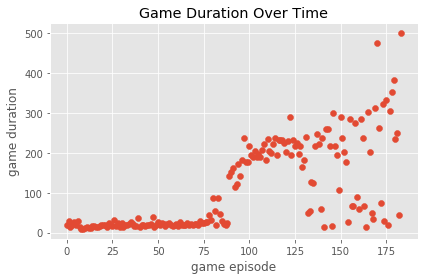

In [4]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

plt.scatter(range(i_episode), game_durations)
plt.title('Game Duration Over Time')
plt.xlabel('game episode')
plt.ylabel('game duration')
plt.tight_layout()